# DATA WRANGLING - `WERATEDOGS` TWITTER PAGE
***

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

***

## Introduction

>Data Wrangling is an important skill for any data enthusiast who wishes to derive meaning from data. Real world data rarely comes clean.Unclean data will lead to false outcomes, wrong decisions and the meaning or information derived will not be credible. Hence it is important to always wrangle data before using it. We will be using Python and its libraries to gather data from a variety of sources and in a variety of formats, assess its quality and tidiness, then clean it.

After Data Wrangling, we will see what data will speak to us!

## About Dataset
>The dataset that we will be wrangling (and analyzing and visualizing) is the tweet archive of Twitter user [@dog_rates](https://twitter.com/dog_rates), also known as [WeRateDogs](https://en.wikipedia.org/wiki/WeRateDogs). WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." WeRateDogs has over 4 million followers and has received international media coverage.

## Process

Data Wrangling has 3 major steps.
- Gather
- Assess
- Clean

We will go step by step. As we proceed we will re-assess and re-iterate the dataset if necessary

## DATA GATHERING

For our Analysis, we will get data from 3 sources.
1. Archive data - `WeRateDogs` tweet data archived in 'csv' file format. The file is not raw data but some preprocessing has already been done.
2. Tweet data - using `Archive` data, we will collect the complete tweet data from twitter and see if we can find some information that we can add for our analysis
3. Image predictions data - This data is available in cloud. We will download the data programatically and use in our analysis. The dataset contains predictions of a trained image classifier, that predicts the dog breed.

#### PRE-REQUISITES

In [1]:
# code added because 'seaborn' package in workspace
# is not latest and causes error in code
# if pip installs latest seaborn, please restart kernel and run all
# if package is up-to-date code will run just fine
!pip install --upgrade seaborn

    100% |████████████████████████████████| 215kB 1.8MB/s eta 0:00:01
    100% |████████████████████████████████| 12.9MB 35kB/s  eta 0:00:01  3% |█▏                              | 471kB 14.1MB/s eta 0:00:01    13% |████▌                           | 1.8MB 30.9MB/s eta 0:00:01    24% |███████▊                        | 3.1MB 18.8MB/s eta 0:00:01    34% |███████████                     | 4.4MB 22.7MB/s eta 0:00:01    54% |█████████████████▋              | 7.1MB 18.4MB/s eta 0:00:01
    100% |████████████████████████████████| 8.9MB 52kB/s  eta 0:00:01    42% |█████████████▊                  | 3.8MB 27.8MB/s eta 0:00:01    72% |███████████████████████         | 6.4MB 28.6MB/s eta 0:00:01    88% |████████████████████████████▎   | 7.9MB 30.7MB/s eta 0:00:01
    100% |████████████████████████████████| 31.2MB 13kB/s  eta 0:00:01  8% |██▊                             | 2.6MB 28.2MB/s eta 0:00:02    21% |██████▉                         | 6.6MB 26.8MB/s eta 0:00:01    25% |████████▏                 

In [2]:
# importing modules used in the project
import numpy as np
import pandas as pd
import requests
import json
import tweepy
import nltk
import re
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat
import datetime

# helps to create inline plots
%matplotlib inline

# set style of plot
sns.set(style='white')

# set column width for full text display
pd.set_option('display.max_colwidth', -1)

In [3]:
# downlaod nltk dependency modules
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [4]:
# set options for float and text
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

Now that the basic setup is done, we will begin.

#### LOAD ARCHIVE DATA FILE (CSV)

Archive data file is stored as `twitter-archive-enhanced.csv`.

In [5]:
# load `archive` data as dataframe
df_archive = pd.read_csv('twitter-archive-enhanced.csv')

In [6]:
# dataframe information
df_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

    Observation: 
    1. dimension - 2356 rows and 17 columns
    2. 181 records are retweets(from retweeted_status_id column)
    3. timestamp column is stored as `string`
    4. [in_reply_to_status_id,in_reply_to_user_id] columns have only 78 non-null values
    5. dog 'stages' are stored as separate columns

#### LOAD IMAGE PREDICTION DATA FROM URL

Image prediction data is stored as `image-predictions.tsv`. It is in `.tsv` format. We will download the dataset using `requests` module

In [7]:
# set URL
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

# get data from URL
response = requests.get(url)

In [8]:
# store data in file
with open(url.split('/')[-1],'wb') as outfile:
    outfile.write(response.content)

In [9]:
# read `tsv` file and load as dataframe
df_img = pd.read_csv('image-predictions.tsv',sep='\t')

In [10]:
# dataframe information
df_img.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


    Observation:
    1. dimension - 2075 rows and 12 columns
    2. top 3 predictions by classifier for each image is stored in separate columns.

#### LOAD TWEET DATA FROM TWITTER PAGE (JSON FILE)

We will be using the Twitter API `tweepy` to gather data from Twitter. The Twitter developer portal has information that can help in understanding data structure, variables and the method of data transfer.<br>
- [Twitter Developer Portal](https://developer.twitter.com/en/docs/basics/getting-started)

Tweepy documentation provides details on how to use `tweepy` application to connect to Twitter and gather data<br>
- [Tweepy Documentation](https://tweepy.readthedocs.io/en/v3.5.0/)

In [11]:
# set keys for OAuth
consumer_key = '***'
consumer_secret = '***'
access_token = '***'
access_secret = '***'

# create OAuth handler instance
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)

# set access token
auth.set_access_token(access_token, access_secret)

# open connection using API
api = tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True)

In [12]:
# list tweet_id's in `archive` dataset
id_list = list(df_archive.tweet_id)

In [13]:
# length of id list
len(id_list)

2356

Now that we got the tweet_id from `archive` dataset, we will query Twitter API for each ID and get data.

In [14]:
# initiate variables
data=[]
missing_id = {}
missing_id['error'] = []

# iterate for each tweet id
for _id in id_list:
    try:
        # get tweet data
        rec = api.get_status(_id,tweet_mode='extended')
        data.append(rec._json)
    except tweepy.TweepError:
        missing_id['error'].append({
            'id':_id,
            'error_text': tweepy.TweepError
        })

Rate limit reached. Sleeping for: 735
Rate limit reached. Sleeping for: 732


In [15]:
# number of ids missing
len(missing_id)

1

In [16]:
# length of dataset downloaded from twitter
len(data)

2342

In [17]:
# write tweet data to file
with open('tweet_json.txt','w') as outfile:
    json.dump(data,outfile)

The twitter data is available in `tweet_json.txt`. It is stored in `json` format. We will load the data from file.

In [18]:
# read `json` file
with open('tweet_json.txt','r') as file:
    data_json = json.load(file)

In [19]:
# load `json` data as dataframe
df_raw = pd.DataFrame.from_dict(data_json,orient='columns')

In [20]:
# dataframe information
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2342 entries, 0 to 2341
Data columns (total 32 columns):
contributors                     0 non-null object
coordinates                      0 non-null object
created_at                       2342 non-null object
display_text_range               2342 non-null object
entities                         2342 non-null object
extended_entities                2068 non-null object
favorite_count                   2342 non-null int64
favorited                        2342 non-null bool
full_text                        2342 non-null object
geo                              0 non-null object
id                               2342 non-null int64
id_str                           2342 non-null object
in_reply_to_screen_name          77 non-null object
in_reply_to_status_id            77 non-null float64
in_reply_to_status_id_str        77 non-null object
in_reply_to_user_id              77 non-null float64
in_reply_to_user_id_str          77 non-null obj

    Observation:
    1. dimension - 2341 rows and 32 columns
    2. many columns have less than 200 non-null values

In [21]:
# get top 1 row
df_raw.head(1)

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,retweet_count,retweeted,retweeted_status,source,truncated,user
0,None,None,Tue Aug 01 16:23:56 +0000 2017,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'url': 'https://t.co/MgUWQ76dJU', 'display_url': 'pic.twitter.com/MgUWQ76dJU', 'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1', 'type': 'photo', 'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'medium': {'w': 540, 'h': 528, 'resize': 'fit'}, 'small': {'w': 540, 'h': 528, 'resize': 'fit'}, 'large': {'w': 540, 'h': 528, 'resize': 'fit'}}}]}","{'media': [{'id': 892420639486877696, 'id_str': '892420639486877696', 'indices': [86, 109], 'media_url': 'http://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg', 'url': 'https://t.co/MgUWQ76dJU', 'display_url': 'pic.twitter.com/MgUWQ76dJU', 'expanded_url': 'https://twitter.com/dog_rates/status/892420643555336193/photo/1', 'type': 'photo', 'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'medium': {'w': 540, 'h': 528, 'resize': 'fit'}, 'small': {'w': 540, 'h': 528, 'resize': 'fit'}, 'large': {'w': 540, 'h': 528, 'resize': 'fit'}}}]}",38146,False,This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,None,...,NaN,nan,NaN,NaN,8346,False,NaN,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",False,"{'id': 4196983835, 'id_str': '4196983835', 'name': 'WeRateDogs™', 'screen_name': 'dog_rates', 'location': 'merch ⇨', 'description': 'Your Only Source For Professional Dog Ratings ⠀ ⠀IG, FB, Snapchat ⇨ WeRateDogs ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ Business: dogratingtwitter@gmail.com', 'url': 'https://t.co/N7sNNHAEXS', 'entities': {'url': {'urls': [{'url': 'https://t.co/N7sNNHAEXS', 'expanded_url': 'http://weratedogs.com', 'display_url': 'weratedogs.com', 'indices': [0, 23]}]}, 'description': {'urls': []}}, 'protected': False, 'followers_count': 7508228, 'friends_count': 11, 'listed_count': 5619, 'created_at': 'Sun Nov 15 21:41:29 +0000 2015', 'favourites_count': 140454, 'utc_offset': None, 'time_zone': None, 'geo_enabled': True, 'verified': True, 'statuses_count': 9381, 'lang': 'en', 'contributors_enabled': False, 'is_translator': False, 'is_translation_enabled': False, 'profile_background_color': '000000', 'profile_background_image_url': 'http://abs.twimg.com/images/themes/theme1/bg.png', 'profile_background_image_url_https': 'https://abs.twimg.com/images/themes/theme1/bg.png', 'profile_background_tile': False, 'profile_image_url': 'http://pbs.twimg.com/profile_images/1072659905235042304/nm3HWlPG_normal.jpg', 'profile_image_url_https': 'https://pbs.twimg.com/profile_images/1072659905235042304/nm3HWlPG_normal.jpg', 'profile_banner_url': 'https://pbs.twimg.com/profile_banners/4196983835/1544368760', 'profile_link_color': 'F5ABB5', 'profile_sidebar_border_color': '000000', 'profile_sidebar_fill_color': '000000', 'profile_text_color': '000000', 'profile_use_background_image': False, 'has_extended_profile': False, 'default_profile': False, 'default_profile_image': False, 'following': False, 'follow_request_sent': False, 'notifications': False, 'translator_type': 'none'}"


The dataframe contains more data which we will not be using for our analysis. We will only use required columns. `user` column looks interesting. Let's see

In [22]:
# display user record
df_raw.user[1]

{'id': 4196983835,
 'id_str': '4196983835',
 'name': 'WeRateDogs™',
 'screen_name': 'dog_rates',
 'location': 'merch  ⇨',
 'description': 'Your Only Source For Professional Dog Ratings ⠀ ⠀IG, FB, Snapchat ⇨ WeRateDogs ⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀ Business: dogratingtwitter@gmail.com',
 'url': 'https://t.co/N7sNNHAEXS',
 'entities': {'url': {'urls': [{'url': 'https://t.co/N7sNNHAEXS',
     'expanded_url': 'http://weratedogs.com',
     'display_url': 'weratedogs.com',
     'indices': [0, 23]}]},
  'description': {'urls': []}},
 'protected': False,
 'followers_count': 7508228,
 'friends_count': 11,
 'listed_count': 5619,
 'created_at': 'Sun Nov 15 21:41:29 +0000 2015',
 'favourites_count': 140454,
 'utc_offset': None,
 'time_zone': None,
 'geo_enabled': True,
 'verified': True,
 'statuses_count': 9381,
 'lang': 'en',
 'contributors_enabled': False,
 'is_translator': False,
 'is_translation_enabled': False,
 'profile_background_color': '000000',
 'profile_background_image_url': 'http://abs.twimg.com/image

This is actually an `user object` with user data. The Twitter documentation for `user objects` lists the description for each of these columns. Link below:
- [User Object Documentation](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/user-object)

We will get the user_id,user_name,followers_count from `user` column. But what do those columns mean?

- **id** : The integer representation of the unique identifier for this User
- **name** : The name of the user, as they’ve defined it. Not necessarily a person’s name
- **followers_count** : The number of followers the user currently has

In [23]:
# initiate variables
user_id = []
user_name = []
user_followers = []

# get all user data
user_data = df_raw.user

In [24]:
# get id, name, follower_count for every user
for user in user_data:
    user_id.append(user['id'])
    user_name.append(user['name'])
    user_followers.append(user['followers_count'])

In [25]:
#print values
print(len(user_id))
print(len(user_name))
print(len(user_followers))

2342
2342
2342


We will create a new dataframe that holds only necessary data columns like *id, retweet_count, favorite_count* columns from `df_raw` dataframe. Their meaning?

- **id** : The integer representation of the unique identifier for a Tweet
- **retweet_count** : Number of times the Tweet has been retweeted
- **favorite_count** : Indicates approximately how many times the Tweet has been liked by Twitter users

These details can be found in Twitter documentation for `Tweet objects`.
- [Tweet Object Documentation](https://developer.twitter.com/en/docs/tweets/data-dictionary/overview/tweet-object)

In [26]:
# create new dataframe
df_json = df_raw[['id','retweet_count','favorite_count']].copy()

In [27]:
# dataframe information
df_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2342 entries, 0 to 2341
Data columns (total 3 columns):
id                2342 non-null int64
retweet_count     2342 non-null int64
favorite_count    2342 non-null int64
dtypes: int64(3)
memory usage: 55.0 KB


In [28]:
df_json['user_id'] = user_id
df_json['user_name'] = user_name
df_json['user_followers_count'] = user_followers

In [29]:
# dataframe information
df_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2342 entries, 0 to 2341
Data columns (total 6 columns):
id                      2342 non-null int64
retweet_count           2342 non-null int64
favorite_count          2342 non-null int64
user_id                 2342 non-null int64
user_name               2342 non-null object
user_followers_count    2342 non-null int64
dtypes: int64(5), object(1)
memory usage: 109.9+ KB


In [30]:
# get top 5 rows
df_json.head()

,id,retweet_count,favorite_count,user_id,user_name,user_followers_count
0,892420643555336193,8346,38146,4196983835,WeRateDogs™,7508228
1,892177421306343426,6168,32716,4196983835,WeRateDogs™,7508228
2,891815181378084864,4082,24637,4196983835,WeRateDogs™,7508228
3,891689557279858688,8488,41491,4196983835,WeRateDogs™,7508228
4,891327558926688256,9182,39658,4196983835,WeRateDogs™,7508228


In [31]:
# delete to free up memory space - entries from recent to old
del user_id,user_name,user_followers
del user_data
del df_raw
del data_json
del response
del url

***

## DATA ASSESSING

Now that we have gathered our data from various sources, lets start the next step. We will be checking for *Quality* and *Tidiness* issues in our datasets. Lets define **Quality** and **Tidy**.

- **Quality:** issues with content. Low quality data is also known as dirty data.
- **Tidiness:** issues with structure that prevent easy analysis. Untidy data is also known as messy data.

In order for dat to be Tidy it should have the following qualities:
1. Each variable forms a column.
2. Each observation forms a row.
3. Each type of observational unit forms a table.

This resource from Hadley Wickham provides more clarity on Tidy data.
- [Tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html)

From our prior observations, we have identified the following issues.

**Image Prediction Dataset**

1. 281 records missing - has only 2075 records

**Archive Dataset**

1. 181 records are retweets(from *retweeted_status_id* column)


2. *timestamp* column is stored as **string**


3. *in_reply_to_status_id*,*in_reply_to_user_id* columns have only 78 non-null values


4. dog *'stages'* columns can be merged as single column

Let's check for other issues

In [32]:
# get top 5 rows
df_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,nan,nan,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,nan,nan,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,nan,nan,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",nan,nan,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,nan,nan,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,nan,nan,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,nan,nan,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,nan,nan,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,nan,nan,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",nan,nan,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


Lets checkout `source` column

In [33]:
# get count of unique source for tweets
df_archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                        91  
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                     33  
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>    11  
Name: source, dtype: int64

source column has only 4 unique values.

    Observation:
    1. source column can be simplified

In [34]:
# get last 5 rows
df_archive.tail()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2351,666049248165822465,nan,nan,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a 1949 1st generation vulpix. Enjoys sweat tea and Fox News. Cannot be phased. 5/10 https://t.co/4B7cOc1EDq,nan,nan,NaN,https://twitter.com/dog_rates/status/666049248165822465/photo/1,5,10,None,None,None,None,None
2352,666044226329800704,nan,nan,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a purebred Piers Morgan. Loves to Netflix and chill. Always looks like he forgot to unplug the iron. 6/10 https://t.co/DWnyCjf2mx,nan,nan,NaN,https://twitter.com/dog_rates/status/666044226329800704/photo/1,6,10,a,None,None,None,None
2353,666033412701032449,nan,nan,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here is a very happy pup. Big fan of well-maintained decks. Just look at that tongue. 9/10 would cuddle af https://t.co/y671yMhoiR,nan,nan,NaN,https://twitter.com/dog_rates/status/666033412701032449/photo/1,9,10,a,None,None,None,None
2354,666029285002620928,nan,nan,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is a western brown Mitsubishi terrier. Upset about leaf. Actually 2 dogs here. 7/10 would walk the shit out of https://t.co/r7mOb2m0UI,nan,nan,NaN,https://twitter.com/dog_rates/status/666029285002620928/photo/1,7,10,a,None,None,None,None
2355,666020888022790149,nan,nan,2015-11-15 22:32:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Here we have a Japanese Irish Setter. Lost eye in Vietnam (?). Big fan of relaxing on stair. 8/10 would pet https://t.co/BLDqew2Ijj,nan,nan,NaN,https://twitter.com/dog_rates/status/666020888022790149/photo/1,8,10,None,None,None,None,None


We can see that the name column has value *'a'* instead of proper names. Lets check if we have more values like that

In [35]:
# get count of unique names
df_archive.name.value_counts()

None         745
a            55 
Charlie      12 
Oliver       11 
Cooper       11 
Lucy         11 
Penny        10 
Lola         10 
Tucker       10 
Bo           9  
Winston      9  
the          8  
Sadie        8  
Daisy        7  
Toby         7  
an           7  
Buddy        7  
Bailey       7  
Stanley      6  
Oscar        6  
Rusty        6  
Scout        6  
Jack         6  
Leo          6  
Koda         6  
Dave         6  
Bella        6  
Milo         6  
Jax          6  
Gus          5  
            ..  
Severus      1  
Gabby        1  
Billl        1  
Darla        1  
Zuzu         1  
Jarvis       1  
Timber       1  
Dante        1  
Tuco         1  
Taco         1  
Alexander    1  
his          1  
Jersey       1  
Gòrdón       1  
Monkey       1  
Traviss      1  
Dallas       1  
Stuart       1  
Terrenth     1  
Emma         1  
Arlen        1  
Mason        1  
Fabio        1  
Lenox        1  
Hamrick      1  
Torque       1  
Combo        1  
Juckson      1

We can see that the `name` column has values like **a,the,an** in the list. Maybe there are more. We'll identify all such values

In [36]:
# get count of unique names that start with lower case
df_archive[df_archive.name.str.contains(r'^[a-z].*')].name.value_counts()

a               55
the             8 
an              7 
very            5 
quite           4 
just            4 
one             4 
getting         2 
mad             2 
not             2 
actually        2 
space           1 
life            1 
by              1 
this            1 
all             1 
old             1 
incredibly      1 
officially      1 
my              1 
his             1 
light           1 
unacceptable    1 
infuriating     1 
such            1 
Name: name, dtype: int64

There are 25 unique values.

    Observation:
    1. name column must be corrected

I'm curious about rating related columns. What about those column? will they have any issues?!

In [37]:
# get count of unique rating_numerator
df_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7       55 
14      54 
5       37 
6       32 
3       19 
4       17 
1       9  
2       9  
420     2  
0       2  
15      2  
75      2  
80      1  
20      1  
24      1  
26      1  
44      1  
50      1  
60      1  
165     1  
84      1  
88      1  
144     1  
182     1  
143     1  
666     1  
960     1  
1776    1  
17      1  
27      1  
45      1  
99      1  
121     1  
204     1  
Name: rating_numerator, dtype: int64

Let's check some suspicious values

In [38]:
df_archive[df_archive.rating_numerator==0]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
315,835152434251116546,nan,nan,2017-02-24 15:40:31 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",When you're so blinded by your systematic plagiarism that you forget what day it is. 0/10 https://t.co/YbEJPkg4Ag,nan,nan,NaN,"https://twitter.com/dog_rates/status/835152434251116546/photo/1,https://twitter.com/dog_rates/status/835152434251116546/photo/1,https://twitter.com/dog_rates/status/835152434251116546/photo/1",0,10,None,None,None,None,None
1016,746906459439529985,746885919387574272.000,4196983835.000,2016-06-26 03:22:31 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","PUPDATE: can't see any. Even if I could, I couldn't reach them to pet. 0/10 much disappointment https://t.co/c7WXaB2nqX",nan,nan,NaN,https://twitter.com/dog_rates/status/746906459439529985/photo/1,0,10,None,None,None,None,None


In [39]:
df_archive[df_archive.rating_numerator==75]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
340,832215909146226688,nan,nan,2017-02-16 13:11:49 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu…",786709082849828864.000,4196983835.000,2016-10-13 23:23:56 +0000,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None
695,786709082849828864,nan,nan,2016-10-13 23:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",nan,nan,NaN,https://twitter.com/dog_rates/status/786709082849828864/photo/1,75,10,Logan,None,None,None,None


We can see that the actual rating is *9.75/10* but the rating column has *75/10*

In [40]:
# get count of unique rating_denominator
df_archive.rating_denominator.value_counts()

10     2333
11     3   
50     3   
80     2   
20     2   
2      1   
16     1   
40     1   
70     1   
15     1   
90     1   
110    1   
120    1   
130    1   
150    1   
170    1   
7      1   
0      1   
Name: rating_denominator, dtype: int64

In [41]:
df_archive[df_archive.rating_denominator==11]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
784,775096608509886464,nan,nan,2016-09-11 22:20:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…",740373189193256960.000,4196983835.000,2016-06-08 02:41:38 +0000,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,None,None,None,None,None
1068,740373189193256964,nan,nan,2016-06-08 02:41:38 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",nan,nan,NaN,"https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,None,None,None,None,None
1662,682962037429899265,nan,nan,2016-01-01 16:30:13 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,nan,nan,NaN,https://twitter.com/dog_rates/status/682962037429899265/photo/1,7,11,Darrel,None,None,None,None


It is clear that the text speaks about *9/11* attack. But the rating columns have *9/11* instead of actual rating value *14/10*. In another case, the value is *7/11* instead of *10/10*

In [42]:
df_archive[df_archive.rating_denominator==2]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
2335,666287406224695296,nan,nan,2015-11-16 16:11:11 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,nan,nan,NaN,https://twitter.com/dog_rates/status/666287406224695296/photo/1,1,2,an,None,None,None,None


Similar to previous rows, the actual rating is *9/10* but rating column has *1/2*

    Observation:
    1. rating_numerator column must be corrected
    2. rating_denominator column must be corrected
    3. rating_numerator column should support float values

In [43]:
# get top 5 rows
df_img.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465,True,collie,0.157,True,Shetland_sheepdog,0.061,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.507,True,miniature_pinscher,0.074,True,Rhodesian_ridgeback,0.072,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596,True,malinois,0.139,True,bloodhound,0.116,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408,True,redbone,0.361,True,miniature_pinscher,0.223,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560,True,Rottweiler,0.244,True,Doberman,0.155,True


In [44]:
# get last 5 rows
df_img.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.556,True,English_springer,0.226,True,German_short-haired_pointer,0.175,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170,False,Labrador_retriever,0.168,True,spatula,0.041,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716,True,malamute,0.078,True,kelpie,0.031,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.324,True,Pekinese,0.091,True,papillon,0.069,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097,False,bagel,0.086,False,banana,0.076,False


We see that the prediction algorithm can predict non-dog values also. If the prediction is non-dog, the \_dog colum for p1,p2,p3 is *False*

    Observation:
    1. Prediction column can be simplified

In [45]:
# get top 5 rows
df_json.head()

,id,retweet_count,favorite_count,user_id,user_name,user_followers_count
0,892420643555336193,8346,38146,4196983835,WeRateDogs™,7508228
1,892177421306343426,6168,32716,4196983835,WeRateDogs™,7508228
2,891815181378084864,4082,24637,4196983835,WeRateDogs™,7508228
3,891689557279858688,8488,41491,4196983835,WeRateDogs™,7508228
4,891327558926688256,9182,39658,4196983835,WeRateDogs™,7508228


In [46]:
sum(df_json.id.duplicated())

0

In [47]:
# get count of unique user names
df_json.user_name.value_counts()

WeRateDogs™    2342
Name: user_name, dtype: int64

Looks like we only have 1 unique value in `user_name` column.

    Observation:
    1. user_name,user_id columns have only 1 unique value

In [48]:
# get count of unique followers_count
df_json.user_followers_count.value_counts()

7508274    263
7508228    201
7508327    188
7508233    177
7508269    175
7508326    173
7508231    136
7508270    121
7508272    110
7508229    105
7508273    100
7508235    76 
7508324    76 
7508268    68 
7508234    64 
7508230    62 
7508232    55 
7508328    46 
7508322    32 
7508267    25 
7508321    22 
7508271    20 
7508323    10 
7508275    8  
7508325    4  
7508799    4  
7508236    3  
7508844    3  
7508845    3  
7508898    2  
7508804    2  
7508846    2  
7508802    1  
7508892    1  
7508895    1  
7508801    1  
7508843    1  
7508897    1  
Name: user_followers_count, dtype: int64

Let's wrap out findings together

#### QUALITY ISSUES

##### `archive` table

1. `timestamp` column datatype is string - should be datetime


2. `source` column must be simplified


3. `rating_numerator` column must be corrected


4. `rating_denominator` column must be corrected


5. `rating_numerator` column should support float values


6. `name` column must be corrected


7. 181 rows are retweets (info from `retweeted_status_id` column)


8. `in_reply_to_status_id`,`in_reply_to_user_id columns` have only 78 non-null values - can be removed


9. `user_name`,`user_id` columns have only 1 unique value

##### `img` table

1. 281 records missing - has only 2075 records


#### TIDY ISSUES

1. number of retweets, favorites(likes), image details must be part of `archive` table. Single dataframe with all required information


2. dog 'stage' in 4 columns [ *doggo,floofer,pupper,puppo* ] can be simplified


3. prediction in 9 columns [ *prediction,conf,dog* ] can be simplified


4. new `hashtag` column can be created from text


5. new `gender` column can be created from text


6. column names are not clear


Although we have listed the identified issues from data assessment process, data cleaning will reveal more underlying problems that we might have missed to identify in our assessment. When we face such issues, we will clean them also in addition to the above identified issues.

***

## DATA CLEANING

    We have gathered and assessed our data. Now its time for action. Let's go!

First we will deal with **Tidy** issues because *Tidy* data makes cleaning easier. We will clean Tidy and Quality issues as per their importance and impact. Both these issues are inter-related to each other. Hence we will proceed cleaning along with the data structure and its flow.

We are going to merge all 3 dataframes into single dataframe. Before we begin, it is always good practise to create a clean copy of dataframe and work on it. In case, when needed the old dataframe is still untouched.

In [49]:
# copy dataframes
archive_clean = df_archive.copy()
json_clean = df_json.copy()
img_clean = df_img.copy()

### Tidy issue 1 : merge 3 dataframes into 1

we will merge 3 dataframes into 1 dataframe - `dog_ratings`

In [50]:
# merge archive and json dataframes
dog_ratings = pd.merge(archive_clean,json_clean,left_on='tweet_id',right_on='id',how='outer',
                       suffixes=('_archive','_json'))

In [51]:
# merge image dataframe
dog_ratings = pd.merge(dog_ratings,img_clean,on='tweet_id',how='left',
                       suffixes=('_archive','_img'))

In [52]:
# dataframe information
dog_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 34 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
id                            23

`tweet_id` is duplicated as `id`. We will remove that

In [53]:
# drop id column from dataframe
dog_ratings.drop('id',axis=1,inplace=True)

#### Test :

In [54]:
# dataframe information
dog_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 33 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
retweet_count                 23

***

### Quality issue 1: remove "Retweets"

In our combined dataframe, we will identify and remove retweet data since retweets are duplicates of existing tweets.

In [55]:
# get rows with text having 'RT@...'
dog_ratings[dog_ratings.text.str.contains(r'.*?RT.?@.*?')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
19,888202515573088257,nan,nan,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX,887473957103951872.000,4196983835.000,2017-07-19 00:47:34 +0000,"https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1,https://twitter.com/dog_rates/status/887473957103951883/photo/1",...,2.000,Pembroke,0.809,True,Rhodesian_ridgeback,0.055,True,beagle,0.039,True
32,886054160059072513,nan,nan,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @Athletics: 12/10 #BATP https://t.co/WxwJmvjfxo,886053734421102592.000,19607400.000,2017-07-15 02:44:07 +0000,"https://twitter.com/dog_rates/status/886053434075471873,https://twitter.com/dog_rates/status/886053434075471873",...,nan,NaN,nan,NaN,NaN,nan,NaN,NaN,nan,NaN
36,885311592912609280,nan,nan,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Lilly. She just parallel barked. Kindly requests a reward now. 13/10 would pet so well https://t.co/SATN4If5H5,830583320585068544.000,4196983835.000,2017-02-12 01:04:29 +0000,"https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1,https://twitter.com/dog_rates/status/830583320585068544/photo/1",...,1.000,Labrador_retriever,0.909,True,seat_belt,0.057,False,pug,0.012,True
68,879130579576475649,nan,nan,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Emmy. She was adopted today. Massive round of pupplause for Emmy and her new family. 14/10 for all involved https://…,878057613040115712.000,4196983835.000,2017-06-23 01:10:23 +0000,"https://twitter.com/dog_rates/status/878057613040115712/photo/1,https://twitter.com/dog_rates/status/878057613040115712/photo/1",...,nan,NaN,nan,NaN,NaN,nan,NaN,NaN,nan,NaN
73,878404777348136964,nan,nan,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","RT @dog_rates: Meet Shadow. In an attempt to reach maximum zooming borkdrive, he tore his ACL. Still 13/10 tho. Help him out below\n\nhttps:/…",878281511006478336.000,4196983835.000,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitter.com/dog_rates/status/878281511006478336/photo/1",...,nan,NaN,nan,NaN,NaN,nan,NaN,NaN,nan,NaN
74,878316110768087041,nan,nan,2017-06-23 18:17:33 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: Meet Terrance. He's being yelled at because he stapled the wrong stuff together. 11/10 hang in there Terrance https://t.co/i…,669000397445533696.000,4196983835.000,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397445533696/photo/1,...,nan,NaN,nan,NaN,NaN,nan,NaN,NaN,nan,NaN
78,877611172832227328,nan,nan,2017-06-21 19:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @rachel2195: @dog_rates the boyfriend and his soaking wet pupper h*cking love his new hat 14/10 https://t.co/dJx4Gzc50G,876850772322988032.000,512804507.000,2017-06-19 17:14:49 +0000,"https://twitter.com/rachel2195/status/876850772322988033/photo/1,https://twitter.com/rachel2195/status/876850772322988033/photo/1,https://twitter.com/rachel2195/status/8768507723229880

For Retweets, the text will have *'RT@'* in them. We searched the `text` column of the dataframe for such entries. We can see that there are **181** records. All these records have value in `retweeted_status_id` column.

In [56]:
# count
sum(dog_ratings.retweeted_status_id.notnull())

181

In [57]:
# get rows where retweeted_status is not null
dog_ratings[dog_ratings.retweeted_status_id.notnull()][['tweet_id','text','retweeted_status_id',
                                                        'retweeted_status_user_id'
                                                        ,'user_id','user_name']]

,tweet_id,text,retweeted_status_id,retweeted_status_user_id,user_id,user_name
19,888202515573088257,RT @dog_rates: This is Canela. She attempted some fancy porch pics. They were unsuccessful. 13/10 someone help her https://t.co/cLyzpcUcMX,887473957103951872.000,4196983835.000,nan,NaN
32,886054160059072513,RT @Athletics: 12/10 #BATP https://t.co/WxwJmvjfxo,886053734421102592.000,19607400.000,4196983835.000,WeRateDogs™
36,885311592912609280,RT @dog_rates: This is Lilly. She just parallel barked. Kindly requests a reward now. 13/10 would pet so well https://t.co/SATN4If5H5,830583320585068544.000,4196983835.000,4196983835.000,WeRateDogs™
68,879130579576475649,RT @dog_rates: This is Emmy. She was adopted today. Massive round of pupplause for Emmy and her new family. 14/10 for all involved https://…,878057613040115712.000,4196983835.000,4196983835.000,WeRateDogs™
73,878404777348136964,"RT @dog_rates: Meet Shadow. In an attempt to reach maximum zooming borkdrive, he tore his ACL. Still 13/10 tho. Help him out below\n\nhttps:/…",878281511006478336.000,4196983835.000,4196983835.000,WeRateDogs™
74,878316110768087041,RT @dog_rates: Meet Terrance. He's being yelled at because he stapled the wrong stuff together. 11/10 hang in there Terrance https://t.co/i…,669000397445533696.000,4196983835.000,4196983835.000,WeRateDogs™
78,877611172832227328,RT @rachel2195: @dog_rates the boyfriend and his soaking wet pupper h*cking love his new hat 14/10 https://t.co/dJx4Gzc50G,876850772322988032.000,512804507.000,4196983835.000,WeRateDogs™
91,874434818259525634,RT @dog_rates: This is Coco. At first I thought she was a cloud but clouds don't bork with such passion. 12/10 would hug softly https://t.c…,866334964761202688.000,4196983835.000,4196983835.000,WeRateDogs™
95,873697596434513921,RT @dog_rates: This is Walter. He won't start hydrotherapy without his favorite floatie. 14/10 keep it pup Walter https://t.co/r28jFx9uyF,868880397819494400.000,4196983835.000,nan,NaN
97,873337748698140672,RT @dog_rates: This is Sierra. She's one precious pupper. Absolute 12/10. Been in and out of ICU her whole life. Help Sierra below\n\nhttps:/…,873213775632977920.000,4196983835.000,4196983835.000,WeRateDogs™


We will check one entry from this output. Lets check the record with **index = 68**.<br>We will get the actual tweet from the dataframe which has `tweet_id`= 878057613040115712

In [58]:
# get row
dog_ratings[dog_ratings.tweet_id==878057613040115712]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
76,878057613040115712,nan,nan,2017-06-23 01:10:23 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Emmy. She was adopted today. Massive round of pupplause for Emmy and her new family. 14/10 for all involved https://t.co/cwtWnHMVpe,nan,nan,NaN,"https://twitter.com/dog_rates/status/878057613040115712/photo/1,https://twitter.com/dog_rates/status/878057613040115712/photo/1",...,1.000,French_bulldog,0.839,True,Boston_bull,0.079,True,toy_terrier,0.015,True


We can see that same data is repeated here. We can remove the Retweeted entries from dataframe

In [59]:
# drop retweets
dog_ratings.drop(dog_ratings[dog_ratings.retweeted_status_id.notnull()].index,inplace=True)

In [60]:
# reset index
dog_ratings.reset_index(drop=True,inplace=True)

We are resetting the `index` because with rows deleted, the index numbers will not be continuous

In [61]:
# dataframe information
dog_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 33 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
retweet_count                 2174 non

There is no need for Retweet related columns now. They can also be removed

In [62]:
# drop columns
dog_ratings.drop(['retweeted_status_id','retweeted_status_user_id','retweeted_status_timestamp'],
                 axis=1,inplace=True)

In [63]:
# dataframe information
dog_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 30 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null object
source                   2175 non-null object
text                     2175 non-null object
expanded_urls            2117 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     2175 non-null object
doggo                    2175 non-null object
floofer                  2175 non-null object
pupper                   2175 non-null object
puppo                    2175 non-null object
retweet_count            2174 non-null float64
favorite_count           2174 non-null float64
user_id                  2174 non-null float64
user_name                2174 non-null object
user_followers_count     2174 non-null float64
jpg_url             

#### Test:

In [64]:
# get rows with text having 'RT@...'
dog_ratings[dog_ratings.text.str.contains(r'.*?RT.?@.*?')]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog


***

### Tidy issue 2 : merge dog 'stage' columns  into single column

There are 4 columns with name - *'doggo', 'floofer', 'pupper', 'puppo'*  which actually is information. We can combine them resulting in 1 column.

In [65]:
# get count of unique values in each column
dog_ratings[['doggo', 'floofer', 'pupper', 'puppo']].apply(pd.value_counts)

,doggo,floofer,pupper,puppo
None,2088.000,2165.000,1941.000,2150.000
doggo,87.000,nan,nan,nan
floofer,nan,10.000,nan,nan
pupper,nan,nan,234.000,nan
puppo,nan,nan,nan,25.000


In [66]:
# get column list except 4 dog stage columns
column_list = dog_ratings.columns[0:10].append(dog_ratings.columns[14:30])

In [67]:
# initialize variable
value = ['doggo', 'floofer', 'pupper', 'puppo']

In [68]:
# combine 4 columns into 2
dog_ratings = pd.melt(dog_ratings,id_vars=column_list,value_vars=value
                      ,var_name='stages',value_name='dog_stage')

In [69]:
# drop 'stages' column --not needed
dog_ratings.drop('stages',axis=1,inplace=True)

In [70]:
# get count of unique dog_stage
dog_ratings.dog_stage.value_counts()

None       8344
pupper     234 
doggo      87  
puppo      25  
floofer    10  
Name: dog_stage, dtype: int64

We can see that the values have been transferred from columns to rows. But we have multiple records which were not part of the original dataframe.

In [71]:
dog_ratings.tweet_id.value_counts()

749075273010798592    4
700847567345688576    4
857029823797047296    4
710997087345876993    4
841320156043304961    4
729838605770891264    4
674739953134403584    4
747219827526344708    4
669603084620980224    4
672523490734551040    4
671362598324076544    4
805520635690676224    4
793241302385262592    4
796759840936919040    4
827933404142436356    4
669216679721873412    4
748346686624440324    4
762471784394268675    4
782598640137187329    4
699088579889332224    4
689993469801164801    4
832032802820481025    4
682393905736888321    4
676975532580409345    4
695816827381944320    4
754011816964026368    4
683449695444799489    4
686035780142297088    4
753026973505581056    4
692017291282812928    4
                     ..
850145622816686080    4
840698636975636481    4
686749460672679938    4
783391753726550016    4
707297311098011648    4
757741869644341248    4
844973813909606400    4
704113298707505153    4
709901256215666688    4
687664829264453632    4
8291415284005560

We will remove the duplicated records

In [72]:
# sort by dog_stage and drop duplicates
dog_ratings = dog_ratings.sort_values('dog_stage').drop_duplicates('tweet_id',keep='last')

In [73]:
# reset index
dog_ratings.reset_index(drop=True,inplace=True)

In [74]:
# get count of unique dog_stage
dog_ratings.dog_stage.value_counts()

None       1831
pupper     234 
doggo      75  
puppo      25  
floofer    10  
Name: dog_stage, dtype: int64

In [75]:
# count
sum(dog_ratings.tweet_id.duplicated())

0

#### Test :

This is our dataframe after replacing *'doggo', 'floofer', 'pupper', 'puppo'* columns with `dog_stage` column

In [76]:
# dataframe information
dog_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 27 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null object
source                   2175 non-null object
text                     2175 non-null object
expanded_urls            2117 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     2175 non-null object
retweet_count            2174 non-null float64
favorite_count           2174 non-null float64
user_id                  2174 non-null float64
user_name                2174 non-null object
user_followers_count     2174 non-null float64
jpg_url                  1994 non-null object
img_num                  1994 non-null float64
p1                       1994 non-null object
p1_conf                  1994 non-null float64
p1_dog            

***

### Tidy issue 3: merge prediction columns

There are 9 prediction columns - *p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog* but they can be combined into 2 columns.

- The \_dog columns are boolean, showing if the prediction was a dog or not
- The \_conf columns show the confidence level for prediction
- The p\_ columns show the actual prediction value

We will consolidate the columns to only hold the first 'dog' prediction for every tweet

In [77]:
# initialize variables
prediction = []
confidence = []

In [78]:
# -------------------------------------- #
# type: function
# name: get_prediction
# input: dataframe row
# output: None
#
# purpose: for every row of input, the 
# function will populate -
#     `prediction` list with the first 'dog' prediction
#     `confidence` list with the corresponding confidence
#
# if no 'dog' prediction was made, then
# 'Nan' and 0 values are populated respectively
# -------------------------------------- #

def get_prediction(df):
    if df.p1_dog:
        prediction.append(df.p1)
        confidence.append(df.p1_conf)
    elif df.p2_dog:
        prediction.append(df.p2)
        confidence.append(df.p2_conf)
    elif df.p3_dog:
        prediction.append(df.p3)
        confidence.append(df.p3_conf)
    else:
        prediction.append('NaN')
        confidence.append(0)

We have created a function that will convert the 9 columns into 2. We will apply the function to our dataframe and then use the populated lists for new columns in dataframe

In [79]:
# apply get_prediction function
dog_ratings.apply(get_prediction,axis=1)

# display length of list
print(len(prediction))

2175


In [80]:
# display length of list
print(len(confidence))

2175


In [81]:
# assign values to new columns
dog_ratings['prediction'] = prediction
dog_ratings['confidence'] = confidence

In [82]:
# print columns
dog_ratings.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'retweet_count', 'favorite_count',
       'user_id', 'user_name', 'user_followers_count', 'jpg_url', 'img_num',
       'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog', 'dog_stage', 'prediction', 'confidence'],
      dtype='object')

In [83]:
dog_ratings.prediction.value_counts()

NaN                               308
golden_retriever                  158
Labrador_retriever                108
Pembroke                          95 
Chihuahua                         91 
pug                               62 
toy_poodle                        51 
chow                              48 
Pomeranian                        42 
Samoyed                           42 
malamute                          33 
French_bulldog                    31 
Chesapeake_Bay_retriever          31 
cocker_spaniel                    30 
miniature_pinscher                25 
Eskimo_dog                        22 
Cardigan                          21 
Staffordshire_bullterrier         21 
German_shepherd                   21 
Siberian_husky                    20 
beagle                            20 
Shih-Tzu                          20 
Maltese_dog                       19 
Rottweiler                        19 
Shetland_sheepdog                 19 
Lakeland_terrier                  18 
kuvasz      

We can see the new columns `prediction`,`confidence` in our dataset. We can now remove image prediction columns.

    Observation:
    1. Prediction column has data in different formats

A close look at the column reveals that some are lowercase format while some are Camecase and some have '\_' while some have'-'. We will have to clean this for data to have a uniform format.

In [84]:
# drop columns
dog_ratings.drop(['img_num', 'p1', 'p1_conf', 'p1_dog',
                  'p2', 'p2_conf', 'p2_dog',
                  'p3', 'p3_conf', 'p3_dog'],axis=1,inplace=True)

#### Test:

In [85]:
# dataframe information
dog_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 19 columns):
tweet_id                 2175 non-null int64
in_reply_to_status_id    78 non-null float64
in_reply_to_user_id      78 non-null float64
timestamp                2175 non-null object
source                   2175 non-null object
text                     2175 non-null object
expanded_urls            2117 non-null object
rating_numerator         2175 non-null int64
rating_denominator       2175 non-null int64
name                     2175 non-null object
retweet_count            2174 non-null float64
favorite_count           2174 non-null float64
user_id                  2174 non-null float64
user_name                2174 non-null object
user_followers_count     2174 non-null float64
jpg_url                  1994 non-null object
dog_stage                2175 non-null object
prediction               1994 non-null object
confidence               1994 non-null float64
dtypes: float64(7),

***

### Quality issue 2: in_reply_ columns have <100 non-null value

As we can see, `in_reply_to_status_id` and `in_reply_to_user_id` columns have <100 non-null values. Do we need them?

- **in_reply_to_status_id** : If the Tweet is a reply, this field will contain the integer representation of the original Tweet’s ID
- **in_reply_to_user_id** : If the represented Tweet is a reply, this field will contain the integer representation of the original Tweet’s author ID

So, we need to check if the Tweet_ID found in `in_reply_to_status_id` is present in our dataframe. If it exists, then we need to see if any changes were done to rating.

In [86]:
# get number of unique values for each column
dog_ratings.nunique()

tweet_id                 2175
in_reply_to_status_id    77  
in_reply_to_user_id      31  
timestamp                2175
source                   4   
text                     2175
expanded_urls            2116
rating_numerator         40  
rating_denominator       18  
name                     956 
retweet_count            1739
favorite_count           1995
user_id                  1   
user_name                1   
user_followers_count     38  
jpg_url                  1994
dog_stage                5   
prediction               114 
confidence               1684
dtype: int64

In [87]:
# get all non-null status_id
status_id = dog_ratings[dog_ratings.in_reply_to_status_id.notnull()].in_reply_to_status_id.astype(np.int64)

In [88]:
# print length
len(status_id)

78

In [89]:
# tweet_id list
twt_id = dog_ratings.tweet_id

In [90]:
for _id in status_id:
    if _id in twt_id:
        print(_id)

In the above code we are checking if IDs in `status_id` are present in `twt_id` list or not. We can see that the IDs in `status_id` are not present in `twt_id` - meaning, we can remove those columns!

In [91]:
# drop columns
dog_ratings.drop(['in_reply_to_status_id','in_reply_to_user_id'],
                 axis=1,inplace=True)

#### Test:

In [92]:
# dataframe information
dog_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 17 columns):
tweet_id                2175 non-null int64
timestamp               2175 non-null object
source                  2175 non-null object
text                    2175 non-null object
expanded_urls           2117 non-null object
rating_numerator        2175 non-null int64
rating_denominator      2175 non-null int64
name                    2175 non-null object
retweet_count           2174 non-null float64
favorite_count          2174 non-null float64
user_id                 2174 non-null float64
user_name               2174 non-null object
user_followers_count    2174 non-null float64
jpg_url                 1994 non-null object
dog_stage               2175 non-null object
prediction              1994 non-null object
confidence              1994 non-null float64
dtypes: float64(5), int64(3), object(9)
memory usage: 288.9+ KB


***

### Quality issue 3: user_name,user_id columns have only 1 unique value

In [93]:
dog_ratings.nunique()

tweet_id                2175
timestamp               2175
source                  4   
text                    2175
expanded_urls           2116
rating_numerator        40  
rating_denominator      18  
name                    956 
retweet_count           1739
favorite_count          1995
user_id                 1   
user_name               1   
user_followers_count    38  
jpg_url                 1994
dog_stage               5   
prediction              114 
confidence              1684
dtype: int64

In [94]:
dog_ratings.user_name.value_counts()

WeRateDogs™    2174
Name: user_name, dtype: int64

In [95]:
dog_ratings.user_id.value_counts()

4196983835.000    2174
Name: user_id, dtype: int64

Since the columns contain only 1 unique value, we can remove those columns

In [96]:
# drop columns
dog_ratings.drop(['user_id','user_name'],
                 axis=1,inplace=True)

#### Test:

In [97]:
# dataframe information
dog_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 15 columns):
tweet_id                2175 non-null int64
timestamp               2175 non-null object
source                  2175 non-null object
text                    2175 non-null object
expanded_urls           2117 non-null object
rating_numerator        2175 non-null int64
rating_denominator      2175 non-null int64
name                    2175 non-null object
retweet_count           2174 non-null float64
favorite_count          2174 non-null float64
user_followers_count    2174 non-null float64
jpg_url                 1994 non-null object
dog_stage               2175 non-null object
prediction              1994 non-null object
confidence              1994 non-null float64
dtypes: float64(4), int64(3), object(8)
memory usage: 255.0+ KB


***

### Quality issue 4: source column must be simplified

In [98]:
dog_ratings.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2042
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                        91  
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                     31  
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>    11  
Name: source, dtype: int64

What is `source` column?

- **source** : the field shows the utility used to post the Tweet in an HTML-formatted string

In our dataset, we have only 4 sources. However, we dont need the HTNL-formatting. We will strip the HTML formatting and extract only text and store it in our column

In [99]:
# extract value and re-assign the column
dog_ratings.source = dog_ratings.source.str.extract(r'>(\D*)<',expand=False)

#### Test:

In [100]:
dog_ratings.source.value_counts()

Twitter for iPhone     2042
Vine - Make a Scene    91  
Twitter Web Client     31  
TweetDeck              11  
Name: source, dtype: int64

We can see that, after change the data is clear to read. It will help in visualization.

***

### Tidy issue 4: new HASHTAG column

The `text` column contains a wealth of information. we will try to dig in and see if we can find something.

- **#TAG(HashTag)** : They are dynamic, user-generated tagging that are used to *tag* messages and also helps other users to find messages quickly

There are some HashTags present in our dataset. We will extract such Tags and store it in `hashtag` column

In [101]:
# extract #hashtag values and assign to column
dog_ratings['hashtag'] = dog_ratings.text.str.extract(r'#(\w+)',expand=False)

In [102]:
# get count of unique hashtag
dog_ratings.hashtag.value_counts()

BarkWeek                 9
PrideMonth               3
Canada150                1
FinalFur                 1
K9VeteransDay            1
dogsatpollingstations    1
PrideMonthPuppo          1
ScienceMarch             1
WKCDogShow               1
NoDaysOff                1
WomensMarch              1
notallpuppers            1
BellLetsTalk             1
ImWithThor               1
Name: hashtag, dtype: int64

***

### Tweet Text - Data Extraction

In order to deal with rating, gender and dog names, we need to first extract information from `text` column. For this purpose, we will be using the NLTK (Natural Language Tool Kit) module.

NLTK is extensively used in NLP (Natural Language Processing). But for our analysis, we will use the NER (Named Entity Recognition) of NLTP to identify names, gender and rating

NLTK Documentation on NER provides us the required details.
- [NLTK NER Documentation](https://www.nltk.org/book/ch07.html)

Also [this](https://tim.mcnamara.nz/post/2650550090/extracting-names-with-6-lines-of-python-code) site helps us with coding for NLTK-NER

In [103]:
# initialize variables

# NER-labeled entity
labels_list = []

# gender
gender_list = []

# numbers entity
cardinal_list = []

# number of numbers entity
ncardinal_list = []

# numerators
numerator_list = []

# denominators
denominator_list = []

In [104]:
# pronouns lists
pronouns_male = ['he','his','him','himself']
pronouns_female = ['she','her','herself']

In [105]:
# -------------------------------------- #
# lambda expression : check membership element-wise
# -------------------------------------- #
any_in = lambda a,b: any(i in b for i in a)

In [106]:
# regex string for split
regex_split = re.compile(r'/')

In [107]:
# -------------------------------------- #
# type: function
# name: extract_entities
# input: text
# output: None
#
# purpose: for given input text extract 
# the following:
#    labels - Labeled Entities
#    numbers - Capture all rating
#    numerators - rating numerators
#    denominators - rating denominators
#    gender - dog gender
# -------------------------------------- #

def extract_entities(text):
    list1 = {}
    list2 = []
    list3 = []
    list4 = []
    list5 = []
    counter = 0
    
    # loop for each sentence
    for sent in nltk.sent_tokenize(text):
        
        # loop for POS tagged chunk words in sentence
        for chunk in nltk.ne_chunk(nltk.pos_tag(nltk.word_tokenize(sent))):
            
            # if chunk is labeled
            if hasattr(chunk, 'label'):
                list1[chunk.label()] = ''.join(c[0] for c in chunk.leaves())
            else:
                # if pronouns
                if ('PRP' in chunk) |('PRP$' in chunk):
                    list2.append(chunk[0].lower())
                
                # if number
                elif ('CD' in chunk):
                    
                    # if number in 'num/num' format
                    if regex_split.search(chunk[0]):
                        list3.append(chunk[0])
                        counter += 1
                        split_list = regex_split.split(chunk[0])
                        list4.append(split_list[0])
                        list5.append(split_list[1])
    
    # if sentence pronouns in male list
    if any_in(list2,pronouns_male):
        gender_list.append('Male')
        
    # if sentence pronouns in female list
    elif any_in(list2,pronouns_female):
        gender_list.append('Female')
        
    # if pronouns not in any list
    else:
        gender_list.append('NaN')
    
    # load variables
    labels_list.append(list1)
    cardinal_list.append(list3)
    ncardinal_list.append(counter)
    numerator_list.append(list4)
    denominator_list.append(list5)

In [108]:
# apply extract_entities for each tweet text in dataframe
for text in dog_ratings.text:
    extract_entities(text)

In [109]:
# display length
print(len(labels_list))
print(len(gender_list))
print(len(cardinal_list))
print(len(ncardinal_list))
print(len(numerator_list))
print(len(denominator_list))

2175
2175
2175
2175
2175
2175


With the new extracted data, we will create a new dataframe

In [110]:
df_extract = pd.DataFrame(dog_ratings.tweet_id)

In [111]:
df_extract['labels'] = labels_list
df_extract['gender'] = gender_list
df_extract['rating'] = cardinal_list
df_extract['number_of_rating'] = ncardinal_list
df_extract['numerator'] = numerator_list
df_extract['denominator'] = denominator_list

In [112]:
# get top 5 rows
df_extract.head()

,tweet_id,labels,gender,rating,number_of_rating,numerator,denominator
0,667443425659232256,{'GPE': 'Weird'},NaN,[6/10],1,[6],[10]
1,667453023279554560,"{'PERSON': 'Cupcake', 'ORGANIZATION': 'Cupcake'}",NaN,[11/10],1,[11],[10]
2,667455448082227200,"{'GPE': 'Simply', 'PERSON': 'Twips'}",NaN,[7/10s],1,[7],[10s]
3,667470559035432960,"{'PERSON': 'Kohl', 'GPE': 'Draws'}",Male,[11/10],1,[11],[10]
4,667491009379606528,"{'ORGANIZATION': 'JujitsuPythagoreans', 'GPE': 'Long'}",NaN,"[7/10, 8/10]",2,"[7, 8]","[10, 10]"


With our dataframe ready, now we'll fix issues

***

### Quality issue 5 : dog name column correction

The `name` column in `dog_ratings` dataframe needs correction as we have identified before.

In [113]:
# get count of unique names
dog_ratings.name.value_counts()

None        680
a           55 
Lucy        11 
Charlie     11 
Oliver      10 
Cooper      10 
Penny       9  
Tucker      9  
Winston     8  
the         8  
Lola        8  
Sadie       8  
Daisy       7  
Toby        7  
Jax         6  
Bailey      6  
Bella       6  
Oscar       6  
Koda        6  
Bo          6  
Stanley     6  
an          6  
Dave        5  
Leo         5  
Scout       5  
Chester     5  
Rusty       5  
Milo        5  
Louis       5  
Buddy       5  
           ..  
Doobert     1  
Severus     1  
Gerbald     1  
Ralphson    1  
Chesney     1  
Fabio       1  
Taco        1  
Sparky      1  
Henry       1  
Sailor      1  
Bauer       1  
Monkey      1  
Dallas      1  
Mattie      1  
Sweet       1  
Tuco        1  
Terrenth    1  
Arlen       1  
Mason       1  
Lenox       1  
Hamrick     1  
Bloop       1  
Torque      1  
Combo       1  
Juckson     1  
Emma        1  
Timber      1  
Julius      1  
Jarvis      1  
Reagan      1  
Name: name, Length: 956,

##### 1. None values :

First we will address the 'None' values. If names for these rows are available in our extracted dataframe, we will use those names.

In [114]:
# get index of 'None' value rows
a_index = dog_ratings[dog_ratings.name=='None'].index

In [115]:
# get rows
dog_ratings.loc[a_index]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,user_followers_count,jpg_url,dog_stage,prediction,confidence,hashtag
0,667443425659232256,2015-11-19 20:44:47 +0000,Twitter for iPhone,Exotic dog here. Long neck. Weird paws. Obsessed with bread. Waddles. Flies sometimes (wow!). Very happy dog. 6/10 https://t.co/rqO4I3nf2N,https://twitter.com/dog_rates/status/667443425659232256/photo/1,6,10,None,590.000,790.000,7508327.000,https://pbs.twimg.com/media/CUM8QZwW4AAVsBl.jpg,None,NaN,0.000,NaN
4,667491009379606528,2015-11-19 23:53:52 +0000,Twitter Web Client,Two dogs in this one. Both are rare Jujitsu Pythagoreans. One slightly whiter than other. Long legs. 7/10 and 8/10 https://t.co/ITxxcc4v9y,https://twitter.com/dog_rates/status/667491009379606528/photo/1,7,10,None,232.000,534.000,7508327.000,https://pbs.twimg.com/media/CUNniSlUYAEj1Jl.jpg,None,borzoi,0.852,NaN
7,667509364010450944,2015-11-20 01:06:48 +0000,Twitter Web Client,This a Norwegian Pewterschmidt named Tickles. Ears for days. 12/10 I care deeply for Tickles https://t.co/0aDF62KVP7,https://twitter.com/dog_rates/status/667509364010450944/photo/1,12,10,None,2166.000,6850.000,7508327.000,https://pbs.twimg.com/media/CUN4Or5UAAAa5K4.jpg,None,beagle,0.636,NaN
9,667524857454854144,2015-11-20 02:08:22 +0000,Twitter Web Client,Another topnotch dog. His name is Big Jumpy Rat. Massive ass feet. Superior tail. Jumps high af. 12/10 great pup https://t.co/seESNzgsdm,https://twitter.com/dog_rates/status/667524857454854144/photo/1,12,10,None,1130.000,1720.000,7508327.000,https://pbs.twimg.com/media/CUOGUfJW4AA_eni.jpg,None,Chesapeake_Bay_retriever,0.088,NaN
14,667437278097252352,2015-11-19 20:20:22 +0000,Twitter for iPhone,Never seen this breed before. Very pointy pup. Hurts when you cuddle. Still cute tho. 10/10 https://t.co/97HuBrVuOx,https://twitter.com/dog_rates/status/667437278097252352/photo/1,10,10,None,242.000,453.000,7508327.000,https://pbs.twimg.com/media/CUM2qWaWoAUZ06L.jpg,None,NaN,0.000,NaN
16,667724302356258817,2015-11-20 15:20:54 +0000,Twitter Web Client,What a dog to start the day with. Very calm. Likes to chill by pond. Corkscrews sticking out of head. Obedient. 7/10 https://t.co/0nIxPTDWAZ,https://twitter.com/dog_rates/status/667724302356258817/photo/1,7,10,None,326.000,488.000,7508327.000,https://pbs.twimg.com/media/CUQ7tv3W4AA3KlI.jpg,None,NaN,0.000,NaN
20,667782464991965184,2015-11-20 19:12:01 +0000,Twitter for iPhone,Super rare dog. Endangered (?). Thinks it's funny. Mocks everything I say. Colorful af. Has wings (dope). 9/10 https://t.co/BY8nQAMz0x,https://twitter.com/dog_rates/status/667782464991965184/photo/1,9,10,None,249.000,414.000,7508898.000,https://pbs.twimg.com/media/CURwm3cUkAARcO6.jpg,None,NaN,0.000,NaN
21,667793409583771648,2015-11-20 19:55:30 +0000,Twitter for iPhone,Dogs only please. Small cows and other non canines will not be tolerated. Sick tattoos tho 8/10 https://t.co/s1z7mX4c9O,https://twitter.com/dog_rates/status/667793409583771648/photo/1,8,10,None,336.000,709.000,7508327.000,https://pbs.twimg.com/media/CUR6jqVWsAEgGot.jpg,None,dalmatian,0.535,NaN
22,667801013445750784,2015-11-20 20:25:43 +0000,Twitter for iPhone,OMIGOD 12/10 https://t.co/SVMF4Frf1w,https://twitter.com/dog_rates/status/667801013445750784/photo/1,12,10,None,97.000,333.000,7508327.000,https://pbs.twimg.com/media/CUSBemVUEAAn-6V.jpg,None,flat-coated_retriever,0.508,NaN
24,667832474953625600,2015-11-20 22:30:44 +0000,Twitter for iPhone,THE EYES 12/10\n\nI'm sorry. These are supposed to be funny but your dogs are too adorable https://t.co/z1xPTgVLc7,https://twitter.com/dog_rates/status/667832474953625600/photo/1,12,10,None,63.000,293.000,7508327.000,https://pbs.twimg.com/media/CUSeGFNW4AAyyHC.jpg,None,miniature_pinscher,0.214,NaN


In [116]:
# get rows
df_extract.loc[a_index]

,tweet_id,labels,gender,rating,number_of_rating,numerator,denominator
0,667443425659232256,{'GPE': 'Weird'},NaN,[6/10],1,[6],[10]
4,667491009379606528,"{'ORGANIZATION': 'JujitsuPythagoreans', 'GPE': 'Long'}",NaN,"[7/10, 8/10]",2,"[7, 8]","[10, 10]"
7,667509364010450944,"{'GPE': 'Norwegian', 'PERSON': 'Tickles'}",NaN,[12/10],1,[12],[10]
9,667524857454854144,"{'PERSON': 'JumpyRat', 'GPE': 'Jumps'}",Male,[12/10],1,[12],[10]
14,667437278097252352,{},NaN,[10/10],1,[10],[10]
16,667724302356258817,{'GPE': 'Obedient'},NaN,[7/10],1,[7],[10]
20,667782464991965184,{'GPE': 'Has'},NaN,[9/10],1,[9],[10]
21,667793409583771648,{'GPE': 'Sick'},NaN,[8/10],1,[8],[10]
22,667801013445750784,{},NaN,[12/10],1,[12],[10]
24,667832474953625600,{'ORGANIZATION': 'EYES'},NaN,[12/10],1,[12],[10]


We will get names from 'PERSON' labels in `labels` column. Although the process is extensive and covers most cases, it is not error free. On visual assessment, we can find the following corrections

    1. for index = 9, df_extract.labels.PERSON = 'JumpyRat' but name = 'Big JumpyRat'
    2. for index = 2088, df_extract.labels.PERSON = 'Happy' but name = 'None'

We can manually correct these issues

In order to correct column values for a list of rows, we will define a function

In [117]:
# -------------------------------------- #
# type: function
# name: rename
# input: integer array
# output: None
#
# purpose: for given input array rename
# the `name` column
# -------------------------------------- #

def rename(array):
    for index in array:
        if 'PERSON' in df_extract.loc[index,'labels']:
            dog_ratings.loc[index,['name']] = df_extract.loc[index,'labels']['PERSON']
        else:
            dog_ratings.loc[index,['name']] = 'None'

We already have the index of 'None' value rows. Lets rename them.

In [118]:
# rename
rename(a_index)

We will also do manual correction for the issues identified from visual assessment

In [119]:
dog_ratings.loc[9,['name']]

name    JumpyRat
Name: 9, dtype: object

In [120]:
# set name
dog_ratings.loc[9,['name']] = 'Big JumpyRat'

In [121]:
# get count of unique names
dog_ratings.name.value_counts()

None        584
a           55 
Charlie     11 
Lucy        11 
Oliver      11 
Cooper      10 
Happy       9  
Tucker      9  
Penny       9  
the         8  
Winston     8  
Lola        8  
Sadie       8  
Toby        7  
Daisy       7  
Koda        6  
an          6  
Stanley     6  
Bella       6  
Bailey      6  
Oscar       6  
Jax         6  
Bo          6  
Reggie      5  
Leo         5  
Rusty       5  
Scout       5  
Dave        5  
Bentley     5  
Louis       5  
           ..  
Severus     1  
Ralphson    1  
Billl       1  
Chesney     1  
Saydee      1  
Fabio       1  
Terrenth    1  
Dante       1  
Taco        1  
Henry       1  
Sailor      1  
Bauer       1  
Monkey      1  
Dallas      1  
Mattie      1  
Sweet       1  
Tuco        1  
Arlen       1  
Sparky      1  
Mason       1  
Lenox       1  
Hamrick     1  
Bloop       1  
Torque      1  
Combo       1  
Juckson     1  
Emma        1  
Timber      1  
Jarvis      1  
Reagan      1  
Name: name, Length: 1017

We have corrected names for 'None' rows. Next we will check non-Noun values. For index=2088, name will be changed together with other names that must be changed to 'None'

#### 2. Non-Noun values :

In [122]:
# get counts of unique names that start with lower case
dog_ratings[dog_ratings.name.str.contains(r'^[a-z].*')].name.value_counts()

a               55
the             8 
an              6 
one             4 
very            4 
just            3 
quite           3 
not             2 
getting         2 
actually        2 
unacceptable    1 
all             1 
by              1 
life            1 
mad             1 
this            1 
light           1 
his             1 
space           1 
old             1 
incredibly      1 
officially      1 
my              1 
infuriating     1 
such            1 
Name: name, dtype: int64

These values are not-Noun or Names. We will see if our extracted dataframe can help.

In [123]:
# get index of unique names that start with lower case
a_index = dog_ratings[dog_ratings.name.str.contains(r'^[a-z].*')].index

In [124]:
dog_ratings.loc[a_index,'text']

3       This is a northern Wahoo named Kohl. He runs this town. Chases tumbleweeds. Draws gun wicked fast. 11/10 legendary https://t.co/J4vn2rOYFk                 
12      This is a southwest Coriander named Klint. Hat looks expensive. Still on house arrest :(\n9/10 https://t.co/IQTOMqDUIe                                     
19      This is a rare Hungarian Pinot named Jessiga. She is either mid-stroke or got stuck in the washing machine. 8/10 https://t.co/ZU0i0KJyqD                   
25      This is a Shotokon Macadamia mix named Cheryl. Sophisticated af. Looks like a disappointed librarian. Shh (lol) 9/10 https://t.co/J4GnJ5Swba               
40      This is a curly Ticonderoga named Pepe. No feet. Loves to jet ski. 11/10 would hug until forever https://t.co/cyDfaK8NBc                                   
57      This is a Dasani Kingfisher from Maine. His name is Daryl. Daryl doesn't like being swallowed by a panda. 8/10 https://t.co/jpaeu6LNmW                     
65      This is 

In [125]:
df_extract.loc[a_index]

,tweet_id,labels,gender,rating,number_of_rating,numerator,denominator
3,667470559035432960,"{'PERSON': 'Kohl', 'GPE': 'Draws'}",Male,[11/10],1,[11],[10]
12,667538891197542400,{'PERSON': 'Klint'},NaN,[9/10],1,[9],[10]
19,667773195014021121,"{'GPE': 'Hungarian', 'PERSON': 'Jessiga'}",Female,[8/10],1,[8],[10]
25,667861340749471744,"{'ORGANIZATION': 'ShotokonMacadamia', 'PERSON': 'Cheryl', 'GPE': 'Shh'}",NaN,[9/10],1,[9],[10]
40,666983947667116034,{'PERSON': 'Pepe'},NaN,[11/10],1,[11],[10]
57,667177989038297088,"{'ORGANIZATION': 'DasaniKingfisher', 'GPE': 'Maine', 'PERSON': 'Daryl'}",Male,[8/10],1,[8],[10]
65,666781792255496192,{'PERSON': 'Octaviath'},NaN,[10/10],1,[10],[10]
74,668171859951755264,"{'PERSON': 'HarryPotter', 'GPE': 'Huge'}",NaN,[7/10],1,[7],[10]
85,668466899341221888,{'GPE': 'Snazzy'},Female,[4/10],1,[4],[10]
89,666701168228331520,"{'PERSON': 'Johm', 'GPE': 'Enjoys'}",NaN,[8/10],1,[8],[10]


Similar to our previous correction, visual assessment shows the following corrections, which we will correct manually.

    1. for index - 74 name = Alfonso
    2. for index - 1826 name = O'Malley
    3. for index - 101,126,128,822,1098,1931,2102 name = None
    4. for index - 125 name = None
    5. for index 446,1769,1784 name = None
    6. 'None' is text in name

Lets rename!

In [126]:
# rename
rename(a_index)

In [127]:
# set name
dog_ratings.loc[74,['name']] = 'Alfonso'

In [128]:
# set name
dog_ratings.loc[1826,['name']] = "O'Malley"

In [129]:
# get count of unique names
dog_ratings.name.value_counts()

None         653
Lucy         11 
Oliver       11 
Charlie      11 
Cooper       10 
Penny        9  
Tucker       9  
Happy        9  
Lola         8  
Sadie        8  
Winston      8  
Daisy        7  
Toby         7  
Jax          6  
Koda         6  
Stanley      6  
Bo           6  
Oscar        6  
Bailey       6  
Bella        6  
Leo          5  
Zoey         5  
Louis        5  
Scout        5  
Chester      5  
Reggie       5  
Jerry        5  
Rusty        5  
Buddy        5  
Milo         5  
            ..  
Gerbald      1  
Ralphson     1  
Cupit        1  
Saydee       1  
Dante        1  
Sparky       1  
Taco         1  
Henry        1  
Sailor       1  
Bauer        1  
Monkey       1  
Octaviath    1  
Dallas       1  
Mattie       1  
Sweet        1  
Tuco         1  
Terrenth     1  
Arlen        1  
Mason        1  
Lenox        1  
Hamrick      1  
Bloop        1  
Torque       1  
Combo        1  
Juckson      1  
Emma         1  
Timber       1  
Fabio        1

In [130]:
a_index = [101,125,126,128,822,1098,1931,2102,125,446,1769,1784,2088]

In order to set a list of rows to 'None', we will define a function

In [131]:
# -------------------------------------- #
# type: function
# name: set_none
# input: dataframe,
#        index - array,
#        column - which column to set
#        fill - which value to set
#        column_type - string or number
#        ind - indicator
#              if ind=1, set to None or 0
#              else set to fill value
# output: None
#
# purpose: for given input array set the
# given value in the given column from the
# given dataframe
# -------------------------------------- #

def set_none(dataframe,index,column,fill='NaN',column_type='str',ind=0):
    if ind:
        if column_type == 'str':
            dataframe.loc[index,[column]] = None
        elif column_type == 'num':
            dataframe.loc[index,[column]] = 0
    else:
        if column_type == 'str':
            dataframe.loc[index,[column]] = fill
        elif column_type == 'num':
            dataframe.loc[index,[column]] = int(fill)

We have the list of indexes that must be set to 'None'. We will use the defines function.

In [132]:
set_none(dog_ratings,a_index,'name','None')

In [133]:
# get count of unique names
dog_ratings.name.value_counts()

None         665
Charlie      11 
Oliver       11 
Lucy         11 
Cooper       10 
Tucker       9  
Penny        9  
Winston      8  
Lola         8  
Sadie        8  
Happy        8  
Daisy        7  
Toby         7  
Jax          6  
Bella        6  
Bo           6  
Oscar        6  
Bailey       6  
Stanley      6  
Koda         6  
Scout        5  
Leo          5  
Reggie       5  
Jerry        5  
Rusty        5  
Dave         5  
Zoey         5  
Louis        5  
Milo         5  
Chester      5  
            ..  
Severus      1  
Gerbald      1  
Ralphson     1  
Chesney      1  
Saydee       1  
Sparky       1  
Terrenth     1  
Taco         1  
Henry        1  
Sailor       1  
Bauer        1  
Monkey       1  
Octaviath    1  
Dallas       1  
Mattie       1  
Sweet        1  
Tuco         1  
Arlen        1  
Jarvis       1  
Mason        1  
Lenox        1  
Hamrick      1  
Bloop        1  
Torque       1  
Combo        1  
Juckson      1  
Emma         1  
Timber       1

#### Test :

In [134]:
# get count of unique names that start with lower case
dog_ratings[dog_ratings.name.str.contains(r'^[a-z].*')].name.value_counts()

Series([], Name: name, dtype: int64)

All the non-Noun values have been replaced.

***

### Tidy issue 5 : new gender column

We have extracted gender from `text` column. We will add this column to `dog_ratings` dataframe

In [135]:
# get count of unique gender
df_extract.gender.value_counts()

Male      1077
NaN       748 
Female    350 
Name: gender, dtype: int64

In [136]:
dog_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 16 columns):
tweet_id                2175 non-null int64
timestamp               2175 non-null object
source                  2175 non-null object
text                    2175 non-null object
expanded_urls           2117 non-null object
rating_numerator        2175 non-null int64
rating_denominator      2175 non-null int64
name                    2175 non-null object
retweet_count           2174 non-null float64
favorite_count          2174 non-null float64
user_followers_count    2174 non-null float64
jpg_url                 1994 non-null object
dog_stage               2175 non-null object
prediction              1994 non-null object
confidence              1994 non-null float64
hashtag                 24 non-null object
dtypes: float64(4), int64(3), object(9)
memory usage: 272.0+ KB


In [137]:
# set gender
dog_ratings['gender'] = df_extract.gender

#### Test :

In [138]:
# get count of unique gender
dog_ratings.gender.value_counts()

Male      1077
NaN       748 
Female    350 
Name: gender, dtype: int64

***

### Quality issue 6,7 : rating column correction

As we have seen previously, rating columns (numerator, denominator) have incorrect values. We will correct using our extracted data

In [139]:
# change column datatype to str
dog_ratings.rating_numerator = dog_ratings.rating_numerator.astype(str)
dog_ratings.rating_denominator = dog_ratings.rating_denominator.astype(str)

We are changing the datatype for easy modification since extracted dataframe has the column numerator and denominator in text

In [140]:
# dataframe information
dog_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 17 columns):
tweet_id                2175 non-null int64
timestamp               2175 non-null object
source                  2175 non-null object
text                    2175 non-null object
expanded_urls           2117 non-null object
rating_numerator        2175 non-null object
rating_denominator      2175 non-null object
name                    2175 non-null object
retweet_count           2174 non-null float64
favorite_count          2174 non-null float64
user_followers_count    2174 non-null float64
jpg_url                 1994 non-null object
dog_stage               2175 non-null object
prediction              1994 non-null object
confidence              1994 non-null float64
hashtag                 24 non-null object
gender                  2175 non-null object
dtypes: float64(4), int64(1), object(12)
memory usage: 288.9+ KB


In [141]:
# get count of unique number_of_rating
df_extract.number_of_rating.value_counts()

1    2138
2    29  
0    7   
3    1   
Name: number_of_rating, dtype: int64

From the extract dataframe, the `number_of_rating` column contain the count of number/cardinal chunk in the Tweet text. We can see that the unique values are *{0,1,2,3}*

We will start with 0 cardinal chunks

#### 1. Zero Cardinal :

In [142]:
# get index of zero cardinal text
a_index = df_extract[df_extract.number_of_rating==0].index

In [143]:
a_index

Int64Index([328, 409, 621, 1753, 1775, 1798, 2126], dtype='int64')

In [144]:
dog_ratings.loc[a_index,['text','name','rating_numerator','rating_denominator']]

,text,name,rating_numerator,rating_denominator
328,Meet Sadie. She fell asleep on the beach and her friends buried her. 10/10 can't trust fellow puppers these days https://t.co/LoKVvc1xAW,Sadie,10,10
409,This is Hammond. He's a peculiar pup. Loves long walks. Bark barely audible. Too many legs. 3/10 must be rare https://t.co/NOIiRWr5Jf,Hammond,3,10
621,This is Layla. She's giving you a standing ovation.13/10 just magnificent (vid by @CSBrzezinski) https://t.co/KxYXHUHUi2,Layla,13,10
1753,This is Finn. He's very nervous for the game. Has a lot of money riding on it.10/10 would attempt to comfort https://t.co/CbtNfecWiT,Finn,10,10
1775,This is Crystal. She's flawless. Really wants to be a frat bro. 11/10 who does she even know here? https://t.co/WyqNFvEulG,Crystal,11,10
1798,This is Kreggory. He just took a look at his student debt. 10/10 can't even comprehend it https://t.co/XTsZTgilnT,Kreggory,10,10
2126,This is Milo. He doesn't understand your fancy human gestures. Will lick instead. 10/10 can't faze this pupper https://t.co/OhodPIDOpW,Milo,10,10


On visual assessment, we can see that no changes are needed for 'zero' cardinal records. We will move to rows having 3 numbers

#### 2. Three Cardinal :

In [145]:
# get index of three cardinal text
a_index = df_extract[df_extract.number_of_rating==3].index

In [146]:
df_extract.loc[a_index]

,tweet_id,labels,gender,rating,number_of_rating,numerator,denominator
749,672248013293752320,{'GPE': 'Much'},NaN,"[10/10, 7/10, 12/10]",3,"[10, 7, 12]","[10, 10, 10]"


In [147]:
dog_ratings.loc[a_index,['text','name','rating_numerator','rating_denominator']]

,text,name,rating_numerator,rating_denominator
749,10/10 for dog. 7/10 for cat. 12/10 for human. Much skill. Would pet all https://t.co/uhx5gfpx5k,None,10,10


The text has 3 ratings. However the existing rating values are good for the dog. Hence no changes are needed.

#### 3. Two Cardinal :

In [148]:
# get index of two cardinal text
a_index = df_extract[df_extract.number_of_rating==2].index

In [149]:
df_extract.loc[a_index]

,tweet_id,labels,gender,rating,number_of_rating,numerator,denominator
4,667491009379606528,"{'ORGANIZATION': 'JujitsuPythagoreans', 'GPE': 'Long'}",NaN,"[7/10, 8/10]",2,"[7, 8]","[10, 10]"
13,667544320556335104,{'GPE': 'Kial'},NaN,"[10/10, 4/10]",2,"[10, 4]","[10, 10]"
38,666835007768551424,"{'PERSON': 'Cupit', 'ORGANIZATION': 'RandPaul', 'GPE': 'Sick'}",NaN,"[10/10, 10/10]",2,"[10, 10]","[10, 10]"
46,667070482143944705,{},NaN,"[10/10, 10/10]",2,"[10, 10]","[10, 10]"
100,666287406224695296,{'GPE': 'Penis'},NaN,"[1/2, 9/10]",2,"[1, 9]","[2, 10]"
196,881633300179243008,{},NaN,"[17/10, 13/10s]",2,"[17, 13]","[10, 10s]"
226,691483041324204033,{},NaN,"[5/10, 10/10]",2,"[5, 10]","[10, 10]"
257,689835978131935233,"{'PERSON': 'Taco', 'ORGANIZATION': 'Fynn', 'GPE': 'Fynn'}",NaN,"[11/10, 10/10]",2,"[11, 10]","[10, 10]"
266,690400367696297985,{'PERSON': 'Eriq'},Male,"[10/10, 6/10]",2,"[10, 6]","[10, 10]"
312,694352839993344000,"{'PERSON': 'Meet', 'ORGANIZATION': 'Oliviér'}",Male,"[10/10, 5/10]",2,"[10, 5]","[10, 10]"


In [150]:
dog_ratings.loc[a_index,['text','name','rating_numerator','rating_denominator']]

,text,name,rating_numerator,rating_denominator
4,Two dogs in this one. Both are rare Jujitsu Pythagoreans. One slightly whiter than other. Long legs. 7/10 and 8/10 https://t.co/ITxxcc4v9y,None,7,10
13,"This is Kial. Kial is either wearing a cape, which would be rad, or flashing us, which would be rude. 10/10 or 4/10 https://t.co/8zcwIoiuqR",Kial,10,10
38,These are Peruvian Feldspars. Their names are Cupit and Prencer. Both resemble Rand Paul. Sick outfits 10/10 &amp; 10/10 https://t.co/ZnEMHBsAs1,Cupit,10,10
46,After much debate this dog is being upgraded to 10/10. I repeat 10/10,None,10,10
100,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,None,1,2
196,@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,None,17,10
226,When bae says they can't go out but you see them with someone else that same night. 5/10 &amp; 10/10 for heartbroken pup https://t.co/aenk0KpoWM,None,5,10
257,Meet Fynn &amp; Taco. Fynn is an all-powerful leaf lord and Taco is in the wrong place at the wrong time. 11/10 &amp; 10/10 https://t.co/MuqHPvtL8c,Fynn,11,10
266,This is Eriq. His friend just reminded him of last year's super bowl. Not cool friend\n10/10 for Eriq\n6/10 for friend https://t.co/PlEXTofdpf,Eriq,10,10
312,Meet Oliviér. He takes killer selfies. Has a dog of his own. It leaps at random &amp; can't bark for shit. 10/10 &amp; 5/10 https://t.co/6NgsQJuSBJ,Oliviér,10,10


On visual assessment, the below changes are the required changes to be done

    1. for index 100 rating=9/10{II}
    2. for index 196 rating=13/10{II}
    3. for index 226 rating=10/10{II}
    4. for index 366 rating=10/10{II}
    5. for index 500 rating=13/10{II}
    6. for index 527 rating=11/10{II}
    7. for index 777 rating=7/10{II}
    8. for index 1549 rating=13/10{II}
    9. for index 1563 rating=14/10{II}

{II} denotes the second element in the extracted array. Other rows found for the index have appropriate rating values. So we will change only the required rows.

In [151]:
a_index = [100,196,226,366,500,527,777,1549,1563]

In [152]:
df_extract.loc[100,'numerator'][1]

'9'

In [153]:
dog_ratings.loc[100,'rating_numerator']

'1'

In [154]:
for index in a_index:
    dog_ratings.loc[index,'rating_numerator'] = df_extract.loc[index,'numerator'][1]
    dog_ratings.loc[index,'rating_denominator'] = df_extract.loc[index,'denominator'][1]

#### Test :

In [155]:
dog_ratings.loc[a_index,['text','name','rating_numerator','rating_denominator']]

,text,name,rating_numerator,rating_denominator
100,This is an Albanian 3 1/2 legged Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv,None,9,10
196,@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,None,13,10s
226,When bae says they can't go out but you see them with someone else that same night. 5/10 &amp; 10/10 for heartbroken pup https://t.co/aenk0KpoWM,None,10,10
366,This is Darrel. He just robbed a 7/11 and is in a high speed police chase. Was just spotted by the helicopter 10/10 https://t.co/7EsP8LmSp5,Darrel,10,10
500,Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,None,13,10
527,This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,Bluebert,11,10
777,"Here we have Pancho and Peaches. Pancho is a Condoleezza Gryffindor, and Peaches is just an asshole. 10/10 &amp; 7/10 https://t.co/Lh1BsJrWPp",Peaches,7,10
1549,"@jonnysun @Lin_Manuel ok jomny I know you're excited but 960/00 isn't a valid rating, 13/10 is tho",Lin_Manuel,13,10
1563,"After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ",Bretagne,14,10


#### 4. One Cardinal :

In [156]:
a_index = df_extract[df_extract.number_of_rating==1].index

In [157]:
df_extract.loc[a_index]

,tweet_id,labels,gender,rating,number_of_rating,numerator,denominator
0,667443425659232256,{'GPE': 'Weird'},NaN,[6/10],1,[6],[10]
1,667453023279554560,"{'PERSON': 'Cupcake', 'ORGANIZATION': 'Cupcake'}",NaN,[11/10],1,[11],[10]
2,667455448082227200,"{'GPE': 'Simply', 'PERSON': 'Twips'}",NaN,[7/10s],1,[7],[10s]
3,667470559035432960,"{'PERSON': 'Kohl', 'GPE': 'Draws'}",Male,[11/10],1,[11],[10]
5,667495797102141441,"{'PERSON': 'Philippe', 'GPE': 'Hung', 'GSP': 'Russia'}",Male,[9/10],1,[9],[10]
6,667502640335572993,"{'GPE': 'Hall', 'PERSON': 'Oates', 'ORGANIZATION': 'Hall'}",NaN,[11/10s],1,[11],[10s]
7,667509364010450944,"{'GPE': 'Norwegian', 'PERSON': 'Tickles'}",NaN,[12/10],1,[12],[10]
8,667517642048163840,"{'PERSON': 'Milo', 'GPE': 'Dook'}",Male,[8/10s],1,[8],[10s]
9,667524857454854144,"{'PERSON': 'JumpyRat', 'GPE': 'Jumps'}",Male,[12/10],1,[12],[10]
10,667530908589760512,"{'PERSON': 'Meet', 'ORGANIZATION': 'Naphaniel'}",Male,[10/10],1,[10],[10]


In [158]:
dog_ratings.loc[a_index,['text','name','rating_numerator','rating_denominator']]

,text,name,rating_numerator,rating_denominator
0,Exotic dog here. Long neck. Weird paws. Obsessed with bread. Waddles. Flies sometimes (wow!). Very happy dog. 6/10 https://t.co/rqO4I3nf2N,None,6,10
1,Meet Cupcake. I would do unspeakable things for Cupcake. 11/10 https://t.co/6uLCWR9Efa,Cupcake,11,10
2,This is Reese and Twips. Reese protects Twips. Both think they're too good for seat belts. Simply reckless. 7/10s https://t.co/uLzRi1drVK,Reese,7,10
3,This is a northern Wahoo named Kohl. He runs this town. Chases tumbleweeds. Draws gun wicked fast. 11/10 legendary https://t.co/J4vn2rOYFk,Kohl,11,10
5,This is Philippe from Soviet Russia. Commanding leader. Misplaced other boot. Hung flag himself. 9/10 charismatic af https://t.co/5NhPV8E45i,Philippe,9,10
6,Say hello to Hall and Oates. Oates is winking and Hall is contemplating the artistic entropy of the universe. 11/10s https://t.co/n5Wtb5Hvsl,Hall,11,10
7,This a Norwegian Pewterschmidt named Tickles. Ears for days. 12/10 I care deeply for Tickles https://t.co/0aDF62KVP7,Tickles,12,10
8,This is Dook &amp; Milo. Dook is struggling to find who he really is and Milo is terrified of what that might be. 8/10s https://t.co/fh5KflzBR0,Dook,8,10
9,Another topnotch dog. His name is Big Jumpy Rat. Massive ass feet. Superior tail. Jumps high af. 12/10 great pup https://t.co/seESNzgsdm,Big JumpyRat,12,10
10,"Meet Naphaniel. He doesn't necessarily enjoy his day job, but he's damn good at it. 10/10 https://t.co/xoRWyQTcmy",Naphaniel,10,10


In [159]:
df_extract.loc[5,'numerator'][0]

'9'

In [160]:
dog_ratings.loc[5,'rating_numerator']

'9'

In [161]:
for index in a_index:
    dog_ratings.loc[index,'rating_numerator'] = df_extract.loc[index,'numerator'][0]
    dog_ratings.loc[index,'rating_denominator'] = df_extract.loc[index,'denominator'][0]

#### Test :

In [162]:
dog_ratings.loc[a_index,['text','name','rating_numerator','rating_denominator']]

,text,name,rating_numerator,rating_denominator
0,Exotic dog here. Long neck. Weird paws. Obsessed with bread. Waddles. Flies sometimes (wow!). Very happy dog. 6/10 https://t.co/rqO4I3nf2N,None,6,10
1,Meet Cupcake. I would do unspeakable things for Cupcake. 11/10 https://t.co/6uLCWR9Efa,Cupcake,11,10
2,This is Reese and Twips. Reese protects Twips. Both think they're too good for seat belts. Simply reckless. 7/10s https://t.co/uLzRi1drVK,Reese,7,10s
3,This is a northern Wahoo named Kohl. He runs this town. Chases tumbleweeds. Draws gun wicked fast. 11/10 legendary https://t.co/J4vn2rOYFk,Kohl,11,10
5,This is Philippe from Soviet Russia. Commanding leader. Misplaced other boot. Hung flag himself. 9/10 charismatic af https://t.co/5NhPV8E45i,Philippe,9,10
6,Say hello to Hall and Oates. Oates is winking and Hall is contemplating the artistic entropy of the universe. 11/10s https://t.co/n5Wtb5Hvsl,Hall,11,10s
7,This a Norwegian Pewterschmidt named Tickles. Ears for days. 12/10 I care deeply for Tickles https://t.co/0aDF62KVP7,Tickles,12,10
8,This is Dook &amp; Milo. Dook is struggling to find who he really is and Milo is terrified of what that might be. 8/10s https://t.co/fh5KflzBR0,Dook,8,10s
9,Another topnotch dog. His name is Big Jumpy Rat. Massive ass feet. Superior tail. Jumps high af. 12/10 great pup https://t.co/seESNzgsdm,Big JumpyRat,12,10
10,"Meet Naphaniel. He doesn't necessarily enjoy his day job, but he's damn good at it. 10/10 https://t.co/xoRWyQTcmy",Naphaniel,10,10


For all one cardinal rows, we have replaced with extract dataframe. However visual assessment helped to spot one issue.

    Observation:
    1. `rating_denominator` column has text

This text is because, it is found in extract dataframe. We will remove it.

***

### Quality issue 8 : rating_denominator column has text

In [163]:
# get rows where rating_numerator has value other than number
dog_ratings[dog_ratings.rating_numerator.str.contains(r'\D')]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,user_followers_count,jpg_url,dog_stage,prediction,confidence,hashtag,gender
203,883482846933004288,2017-07-08 00:28:19 +0000,Twitter for iPhone,"This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948","https://twitter.com/dog_rates/status/883482846933004288/photo/1,https://twitter.com/dog_rates/status/883482846933004288/photo/1",13.5,10,Bella,9774.000,45193.000,7508228.000,https://pbs.twimg.com/media/DELC9dZXUAADqUk.jpg,None,golden_retriever,0.943,NaN,Female
345,681340665377193984,2015-12-28 05:07:27 +0000,Twitter for iPhone,I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace,NaN,9.5,10,None,299.000,1723.000,7508274.000,NaN,None,NaN,nan,NaN,Male
957,680494726643068929,2015-12-25 21:06:00 +0000,Twitter for iPhone,Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD,https://twitter.com/dog_rates/status/680494726643068929/photo/1,11.26,10,None,518.000,1798.000,7508274.000,https://pbs.twimg.com/media/CXGaVxOWAAADjhF.jpg,None,kuvasz,0.439,NaN,NaN
1246,786709082849828864,2016-10-13 23:23:56 +0000,Twitter for iPhone,"This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS",https://twitter.com/dog_rates/status/786709082849828864/photo/1,9.75,10,Logan,6696.000,19504.000,7508233.000,https://pbs.twimg.com/media/CurzvFTXgAA2_AP.jpg,None,Pomeranian,0.467,NaN,Male
1986,778027034220126208,2016-09-20 00:24:34 +0000,Twitter for iPhone,This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq,https://twitter.com/dog_rates/status/778027034220126208/photo/1,11.27,10,Sophie,1775.000,7000.000,7508234.000,https://pbs.twimg.com/media/Cswbc2yWcAAVsCJ.jpg,pupper,clumber,0.947,NaN,Female


Although its a surprise, the above rows turned up because of '.' in the column Ex. '.' in '13.5'. we dont have to change any numerator values. Lets check denominator.

In [164]:
# get index of rows where rating_denominator has value other than number
a_index = dog_ratings[dog_ratings.rating_denominator.str.contains(r'\D')].index

In [165]:
dog_ratings.loc[a_index,['text','name','rating_numerator','rating_denominator']]

,text,name,rating_numerator,rating_denominator
2,This is Reese and Twips. Reese protects Twips. Both think they're too good for seat belts. Simply reckless. 7/10s https://t.co/uLzRi1drVK,Reese,7,10s
6,Say hello to Hall and Oates. Oates is winking and Hall is contemplating the artistic entropy of the universe. 11/10s https://t.co/n5Wtb5Hvsl,Hall,11,10s
8,This is Dook &amp; Milo. Dook is struggling to find who he really is and Milo is terrified of what that might be. 8/10s https://t.co/fh5KflzBR0,Dook,8,10s
73,Fun dogs here. Top one clearly an athlete. Bottom one very stable. Not very soft tho. 9/10s would still cuddle both https://t.co/79sHR36NsI,None,9,10s
90,2 rare dogs. They waddle (v inefficient). Sometimes slide on bellies. Right one wants to be aircraft Marshall. 9/10s https://t.co/P8bivfp5sU,None,9,10s
196,@roushfenway These are good dogs but 17/10 is an emotional impulse rating. More like 13/10s,None,13,10s
334,Gang of fearless hoofed puppers here. Straight savages. Elevated for extra terror. Front one has killed before 6/10s https://t.co/jkCb25OWfh,Gang,6,10s
362,Meet Joey and Izzy. Joey only has one ear that works and Izzy wants 2015 to be over already. Both great pups. 11/10s https://t.co/WgQTIQ93BB,Joey,11,10s
693,Pink dogs here. Unreasonably long necks. Left guy has only 1 leg. Quite nimble. Don't bark tho 4/10s would still pet https://t.co/QY5uvMmmQk,None,4,10s
699,Two miniature golden retrievers here. Webbed paws. Don't walk very efficiently. Can't catch a tennis ball. 4/10s https://t.co/WzVLdSHJU7,None,4,10s


We can see that rating_denominator has 's' appended to number. we'll remove it.

In [166]:
denom = dog_ratings.loc[a_index,'rating_denominator'].str.extract(r'(\d*)\D',expand=False)

In [167]:
denom.loc[2][0]

'1'

In [168]:
for index in a_index:
    dog_ratings.loc[index,'rating_denominator'] = denom.loc[index][0]

#### Test :

In [169]:
dog_ratings[dog_ratings.rating_denominator.str.contains(r'\D')]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,user_followers_count,jpg_url,dog_stage,prediction,confidence,hashtag,gender


***

### Quality issue 9 : rating_numerator column should support float values

Since we have finished loading the columns, we can convert rating columns to float.

In [170]:
dog_ratings.rating_numerator = dog_ratings.rating_numerator.astype(np.float64)
dog_ratings.rating_denominator = dog_ratings.rating_denominator.astype(np.float64)

In [171]:
# get count of unique rating_denominator
dog_ratings.rating_denominator.value_counts()

10.000     2140
1.000      19  
50.000     2   
80.000     2   
150.000    1   
70.000     1   
90.000     1   
170.000    1   
110.000    1   
130.000    1   
15.000     1   
7.000      1   
120.000    1   
20.000     1   
16.000     1   
40.000     1   
Name: rating_denominator, dtype: int64

In [172]:
# get count of unique rating_numerator
dog_ratings.rating_numerator.value_counts()

12.000      500
10.000      443
11.000      427
13.000      310
9.000       156
8.000       98 
7.000       54 
14.000      44 
5.000       33 
6.000       32 
3.000       19 
4.000       16 
2.000       9  
1.000       7  
0.000       2  
420.000     2  
20.000      1  
13.500      1  
44.000      1  
9.500       1  
143.000     1  
80.000      1  
1776.000    1  
99.000      1  
165.000     1  
204.000     1  
9.750       1  
45.000      1  
666.000     1  
182.000     1  
121.000     1  
11.270      1  
11.260      1  
15.000      1  
84.000      1  
24.000      1  
88.000      1  
144.000     1  
60.000      1  
Name: rating_numerator, dtype: int64

In [173]:
# dataframe information
dog_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 17 columns):
tweet_id                2175 non-null int64
timestamp               2175 non-null object
source                  2175 non-null object
text                    2175 non-null object
expanded_urls           2117 non-null object
rating_numerator        2175 non-null float64
rating_denominator      2175 non-null float64
name                    2175 non-null object
retweet_count           2174 non-null float64
favorite_count          2174 non-null float64
user_followers_count    2174 non-null float64
jpg_url                 1994 non-null object
dog_stage               2175 non-null object
prediction              1994 non-null object
confidence              1994 non-null float64
hashtag                 24 non-null object
gender                  2175 non-null object
dtypes: float64(6), int64(1), object(10)
memory usage: 288.9+ KB


***

### Quality issue 10: prediction column data format

In [174]:
dog_ratings.prediction.unique()

array(['NaN', 'Labrador_retriever', 'Tibetan_terrier', 'toy_poodle',
       'borzoi', 'Chihuahua', 'beagle', 'Italian_greyhound',
       'Chesapeake_Bay_retriever', 'golden_retriever', 'Pembroke',
       'Yorkshire_terrier', 'Pomeranian', 'kuvasz',
       'West_Highland_white_terrier', 'dalmatian',
       'flat-coated_retriever', 'miniature_pinscher', 'malamute',
       'Rottweiler', 'papillon', 'English_setter', 'miniature_schnauzer',
       'Maltese_dog', 'Airedale', nan, 'Saint_Bernard', 'giant_schnauzer',
       'soft-coated_wheaten_terrier', 'vizsla', 'Siberian_husky',
       'Norwegian_elkhound', 'boxer', 'Blenheim_spaniel', 'chow',
       'miniature_poodle', 'Eskimo_dog', 'Gordon_setter', 'Walker_hound',
       'pug', 'bloodhound', 'Lhasa', 'Newfoundland',
       'black-and-tan_coonhound', 'toy_terrier', 'Irish_terrier',
       'curly-coated_retriever', 'Ibizan_hound', 'Border_collie',
       'German_shepherd', 'Bernese_mountain_dog', 'Rhodesian_ridgeback',
       'redbone', 'co

In [175]:
dog_ratings['prediction'] = dog_ratings.prediction.str.replace('_',' ').str.title()

In [176]:
dog_ratings.prediction.unique()

array(['Nan', 'Labrador Retriever', 'Tibetan Terrier', 'Toy Poodle',
       'Borzoi', 'Chihuahua', 'Beagle', 'Italian Greyhound',
       'Chesapeake Bay Retriever', 'Golden Retriever', 'Pembroke',
       'Yorkshire Terrier', 'Pomeranian', 'Kuvasz',
       'West Highland White Terrier', 'Dalmatian',
       'Flat-Coated Retriever', 'Miniature Pinscher', 'Malamute',
       'Rottweiler', 'Papillon', 'English Setter', 'Miniature Schnauzer',
       'Maltese Dog', 'Airedale', nan, 'Saint Bernard', 'Giant Schnauzer',
       'Soft-Coated Wheaten Terrier', 'Vizsla', 'Siberian Husky',
       'Norwegian Elkhound', 'Boxer', 'Blenheim Spaniel', 'Chow',
       'Miniature Poodle', 'Eskimo Dog', 'Gordon Setter', 'Walker Hound',
       'Pug', 'Bloodhound', 'Lhasa', 'Newfoundland',
       'Black-And-Tan Coonhound', 'Toy Terrier', 'Irish Terrier',
       'Curly-Coated Retriever', 'Ibizan Hound', 'Border Collie',
       'German Shepherd', 'Bernese Mountain Dog', 'Rhodesian Ridgeback',
       'Redbone', 'Co

In [177]:
dog_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 17 columns):
tweet_id                2175 non-null int64
timestamp               2175 non-null object
source                  2175 non-null object
text                    2175 non-null object
expanded_urls           2117 non-null object
rating_numerator        2175 non-null float64
rating_denominator      2175 non-null float64
name                    2175 non-null object
retweet_count           2174 non-null float64
favorite_count          2174 non-null float64
user_followers_count    2174 non-null float64
jpg_url                 1994 non-null object
dog_stage               2175 non-null object
prediction              1994 non-null object
confidence              1994 non-null float64
hashtag                 24 non-null object
gender                  2175 non-null object
dtypes: float64(6), int64(1), object(10)
memory usage: 288.9+ KB


### Quality issue 11: improper datatypes

Now that our process is nearly complete, we will standardize None values and set proper datatypes

#### gender

In [178]:
dog_ratings.gender.value_counts()

Male      1077
NaN       748 
Female    350 
Name: gender, dtype: int64

In [179]:
a_index = dog_ratings[dog_ratings.gender=='NaN'].index

In [180]:
set_none(dog_ratings,a_index,'gender',ind=1)

In [181]:
dog_ratings.gender.value_counts()

Male      1077
Female    350 
Name: gender, dtype: int64

***
#### prediction :

In [182]:
dog_ratings.prediction.value_counts()

Nan                            308
Golden Retriever               158
Labrador Retriever             108
Pembroke                       95 
Chihuahua                      91 
Pug                            62 
Toy Poodle                     51 
Chow                           48 
Pomeranian                     42 
Samoyed                        42 
Malamute                       33 
Chesapeake Bay Retriever       31 
French Bulldog                 31 
Cocker Spaniel                 30 
Miniature Pinscher             25 
Eskimo Dog                     22 
German Shepherd                21 
Cardigan                       21 
Staffordshire Bullterrier      21 
Beagle                         20 
Shih-Tzu                       20 
Siberian Husky                 20 
Rottweiler                     19 
Shetland Sheepdog              19 
Maltese Dog                    19 
Lakeland Terrier               18 
Kuvasz                         18 
Basset                         17 
Italian Greyhound   

In [183]:
a_index = dog_ratings[dog_ratings.prediction=='Nan'].index

In [184]:
set_none(dog_ratings,a_index,'prediction',ind=1)

In [185]:
dog_ratings.prediction.value_counts()

Golden Retriever                  158
Labrador Retriever                108
Pembroke                          95 
Chihuahua                         91 
Pug                               62 
Toy Poodle                        51 
Chow                              48 
Pomeranian                        42 
Samoyed                           42 
Malamute                          33 
French Bulldog                    31 
Chesapeake Bay Retriever          31 
Cocker Spaniel                    30 
Miniature Pinscher                25 
Eskimo Dog                        22 
Cardigan                          21 
Staffordshire Bullterrier         21 
German Shepherd                   21 
Siberian Husky                    20 
Shih-Tzu                          20 
Beagle                            20 
Shetland Sheepdog                 19 
Rottweiler                        19 
Maltese Dog                       19 
Kuvasz                            18 
Lakeland Terrier                  18 
Basset      

***

#### hashtag

In [186]:
a_index = dog_ratings[dog_ratings.hashtag.isnull()].index

In [187]:
set_none(dog_ratings,a_index,'hashtag',ind=1)

In [188]:
dog_ratings[dog_ratings.hashtag.isnull()]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,user_followers_count,jpg_url,dog_stage,prediction,confidence,hashtag,gender
0,667443425659232256,2015-11-19 20:44:47 +0000,Twitter for iPhone,Exotic dog here. Long neck. Weird paws. Obsessed with bread. Waddles. Flies sometimes (wow!). Very happy dog. 6/10 https://t.co/rqO4I3nf2N,https://twitter.com/dog_rates/status/667443425659232256/photo/1,6.000,10.000,None,590.000,790.000,7508327.000,https://pbs.twimg.com/media/CUM8QZwW4AAVsBl.jpg,None,None,0.000,None,None
1,667453023279554560,2015-11-19 21:22:56 +0000,Twitter Web Client,Meet Cupcake. I would do unspeakable things for Cupcake. 11/10 https://t.co/6uLCWR9Efa,https://twitter.com/dog_rates/status/667453023279554560/photo/1,11.000,10.000,Cupcake,91.000,315.000,7508327.000,https://pbs.twimg.com/media/CUNE_OSUwAAdHhX.jpg,None,Labrador Retriever,0.826,None,None
2,667455448082227200,2015-11-19 21:32:34 +0000,Twitter Web Client,This is Reese and Twips. Reese protects Twips. Both think they're too good for seat belts. Simply reckless. 7/10s https://t.co/uLzRi1drVK,https://twitter.com/dog_rates/status/667455448082227200/photo/1,7.000,1.000,Reese,60.000,194.000,7508327.000,https://pbs.twimg.com/media/CUNHMXTU8AAS3HH.jpg,None,Tibetan Terrier,0.676,None,None
3,667470559035432960,2015-11-19 22:32:36 +0000,Twitter Web Client,This is a northern Wahoo named Kohl. He runs this town. Chases tumbleweeds. Draws gun wicked fast. 11/10 legendary https://t.co/J4vn2rOYFk,https://twitter.com/dog_rates/status/667470559035432960/photo/1,11.000,10.000,Kohl,100.000,258.000,7508327.000,https://pbs.twimg.com/media/CUNU78YWEAECmpB.jpg,None,Toy Poodle,0.304,None,Male
4,667491009379606528,2015-11-19 23:53:52 +0000,Twitter Web Client,Two dogs in this one. Both are rare Jujitsu Pythagoreans. One slightly whiter than other. Long legs. 7/10 and 8/10 https://t.co/ITxxcc4v9y,https://twitter.com/dog_rates/status/667491009379606528/photo/1,7.000,10.000,None,232.000,534.000,7508327.000,https://pbs.twimg.com/media/CUNniSlUYAEj1Jl.jpg,None,Borzoi,0.852,None,None
5,667495797102141441,2015-11-20 00:12:54 +0000,Twitter Web Client,This is Philippe from Soviet Russia. Commanding leader. Misplaced other boot. Hung flag himself. 9/10 charismatic af https://t.co/5NhPV8E45i,https://twitter.com/dog_rates/status/667495797102141441/photo/1,9.000,10.000,Philippe,276.000,527.000,7508327.000,https://pbs.twimg.com/media/CUNr4-7UwAAg2lq.jpg,None,Chihuahua,0.144,None,Male
6,667502640335572993,2015-11-20 00:40:05 +0000,Twitter Web Client,Say hello to Hall and Oates. Oates is winking and Hall is contemplating the artistic entropy of the universe. 11/10s https://t.co/n5Wtb5Hvsl,https://twitter.com/dog_rates/status/667502640335572993/photo/1,11.000,1.000,Hall,222.000,538.000,7508327.000,https://pbs.twimg.com/media/CUNyHTMUYAAQVch.jpg,None,Labrador Retriever,0.997,None,None
7,667509364010450944,2015-11-20 01:06:48 +0000,Twitter Web Client,This a Norwegian Pewterschmidt named Tickles. Ears for days. 12/10 I care deeply for Tickles https://t.co/0aDF62KVP7,https://twitter.com/dog_rates/status/667509364010450944/photo/1,12.000,10.000,Tickles,2166.000,6850.000,7508327.000,https://pbs.twimg.com/media/CUN4Or5UAAAa5K4.jpg,None,Beagle,0.636,None,None
8,667517642048163840,2015-11-20 01:39:42 +0000,Twitter Web Client,This is Dook &amp; Milo. Dook is struggling to find who he really is and Milo is terrified of what that might be. 8/10s https://t.co/fh5KflzBR0,https://twitter.com/dog_rates/status/667517642048163840/photo/1,8.000,1.000,Dook,195.000,372.000,7508327.000,https://pbs.twimg.com/media/CUN_wiBUkAAakT0.jpg,None,Italian Greyhound,0.125,None,Male
9,667524857454854144,2015-11-20 02:08:22 +0000,Twitter Web Client,Another topnotch dog. His name is Big Jumpy Rat. Massive ass feet. Superior tail. Jumps high af. 12/10 great pup https://t.co/seESNzgsdm,https://twitter.com/dog_rates/status/667524857454854144/photo/1,12.000,10.000,Big JumpyRat,

***

#### dog_stage

In [189]:
dog_ratings.dog_stage.value_counts()

None       1831
pupper     234 
doggo      75  
puppo      25  
floofer    10  
Name: dog_stage, dtype: int64

In [190]:
a_index = dog_ratings[dog_ratings.dog_stage=='None'].index

In [191]:
set_none(dog_ratings,a_index,'dog_stage',ind=1)

In [192]:
dog_ratings.dog_stage.value_counts()

pupper     234
doggo      75 
puppo      25 
floofer    10 
Name: dog_stage, dtype: int64

***

#### name

In [193]:
dog_ratings.name.value_counts()

None         665
Charlie      11 
Oliver       11 
Lucy         11 
Cooper       10 
Tucker       9  
Penny        9  
Winston      8  
Lola         8  
Sadie        8  
Happy        8  
Daisy        7  
Toby         7  
Jax          6  
Bella        6  
Bo           6  
Oscar        6  
Bailey       6  
Stanley      6  
Koda         6  
Scout        5  
Leo          5  
Reggie       5  
Jerry        5  
Rusty        5  
Dave         5  
Zoey         5  
Louis        5  
Milo         5  
Chester      5  
            ..  
Severus      1  
Gerbald      1  
Ralphson     1  
Chesney      1  
Saydee       1  
Sparky       1  
Terrenth     1  
Taco         1  
Henry        1  
Sailor       1  
Bauer        1  
Monkey       1  
Octaviath    1  
Dallas       1  
Mattie       1  
Sweet        1  
Tuco         1  
Arlen        1  
Jarvis       1  
Mason        1  
Lenox        1  
Hamrick      1  
Bloop        1  
Torque       1  
Combo        1  
Juckson      1  
Emma         1  
Timber       1

In [194]:
a_index = dog_ratings[dog_ratings.name=='None'].index

In [195]:
set_none(dog_ratings,a_index,'name',ind=1)

In [196]:
dog_ratings.name.value_counts()

Lucy         11
Charlie      11
Oliver       11
Cooper       10
Penny        9 
Tucker       9 
Lola         8 
Happy        8 
Sadie        8 
Winston      8 
Daisy        7 
Toby         7 
Oscar        6 
Stanley      6 
Jax          6 
Koda         6 
Bella        6 
Bailey       6 
Bo           6 
Milo         5 
Rusty        5 
Zoey         5 
Dave         5 
Scout        5 
Leo          5 
Louis        5 
Chester      5 
Bentley      5 
Jerry        5 
Reggie       5 
            .. 
Gerbald      1 
Ralphson     1 
Billl        1 
Cupit        1 
Chesney      1 
Saydee       1 
Arlen        1 
Henry        1 
Sailor       1 
Bauer        1 
Monkey       1 
Octaviath    1 
Dallas       1 
Mattie       1 
Sweet        1 
Tuco         1 
Terrenth     1 
Mason        1 
Sparky       1 
Lenox        1 
Hamrick      1 
Bloop        1 
Torque       1 
Combo        1 
Juckson      1 
Emma         1 
Timber       1 
Fabio        1 
Jarvis       1 
Reagan       1 
Name: name, Length: 1011

***

### datatypes

In [197]:
dog_ratings.dtypes

tweet_id                int64  
timestamp               object 
source                  object 
text                    object 
expanded_urls           object 
rating_numerator        float64
rating_denominator      float64
name                    object 
retweet_count           float64
favorite_count          float64
user_followers_count    float64
jpg_url                 object 
dog_stage               object 
prediction              object 
confidence              float64
hashtag                 object 
gender                  object 
dtype: object

    The following datatype changes should be made:
    1. timestamp to datetime
    2. source to categorical
    3. dog_stage to categorical
    4. gender to categorical

In [198]:
dog_ratings.timestamp = pd.to_datetime(dog_ratings.timestamp,
                                       infer_datetime_format=True)

In [199]:
dog_ratings.source = dog_ratings.source.astype('category')

In [200]:
dog_ratings.dog_stage = dog_ratings.dog_stage.astype('category')

In [201]:
dog_ratings.gender = dog_ratings.gender.astype('category')

In [202]:
dog_ratings.dtypes

tweet_id                int64         
timestamp               datetime64[ns]
source                  category      
text                    object        
expanded_urls           object        
rating_numerator        float64       
rating_denominator      float64       
name                    object        
retweet_count           float64       
favorite_count          float64       
user_followers_count    float64       
jpg_url                 object        
dog_stage               category      
prediction              object        
confidence              float64       
hashtag                 object        
gender                  category      
dtype: object

### Tidy issue 6 : proper column names

We will set proper names for column. This will help in understanding the dataset.

In [203]:
dog_ratings.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'retweet_count',
       'favorite_count', 'user_followers_count', 'jpg_url', 'dog_stage',
       'prediction', 'confidence', 'hashtag', 'gender'],
      dtype='object')

In [204]:
column_name = {'timestamp': 'tweet_date',
               'source': 'tweet_source',
               'text': 'tweet_text',
               'expanded_urls': 'tweet_url',
               'name':'dog_name',
               'favorite_count': 'likes_count',
               'jpg_url': 'tweet_picture_url',
               'prediction' : 'dog_breed_prediction',
               'confidence': 'prediction_confidence',
               'gender':'dog_gender'}

In [205]:
dog_ratings = dog_ratings.rename(columns = column_name)

In [206]:
dog_ratings.columns

Index(['tweet_id', 'tweet_date', 'tweet_source', 'tweet_text', 'tweet_url',
       'rating_numerator', 'rating_denominator', 'dog_name', 'retweet_count',
       'likes_count', 'user_followers_count', 'tweet_picture_url', 'dog_stage',
       'dog_breed_prediction', 'prediction_confidence', 'hashtag',
       'dog_gender'],
      dtype='object')

## Wrap up

With our dataframe all cleaned up, its time to store it for further data analysis and visualizations

In [207]:
dog_ratings.to_csv('twitter_archive_master.csv',index=False,encoding='utf-8')

#### Test:

In [208]:
df = pd.read_csv('twitter_archive_master.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 17 columns):
tweet_id                 2175 non-null int64
tweet_date               2175 non-null object
tweet_source             2175 non-null object
tweet_text               2175 non-null object
tweet_url                2117 non-null object
rating_numerator         2175 non-null float64
rating_denominator       2175 non-null float64
dog_name                 1510 non-null object
retweet_count            2174 non-null float64
likes_count              2174 non-null float64
user_followers_count     2174 non-null float64
tweet_picture_url        1994 non-null object
dog_stage                344 non-null object
dog_breed_prediction     1686 non-null object
prediction_confidence    1994 non-null float64
hashtag                  24 non-null object
dog_gender               1427 non-null object
dtypes: float64(6), int64(1), object(10)
memory usage: 288.9+ KB


# ANALYSIS AND VISUALIZATION OF `WERATEDOGS` TWITTER DATA

## Introduction

>Data Analysis and Visualization are the final phases where the cleaned data is mined for information and insights. We have wrangled our data by gathering from different sources, assessing and cleaning the dataset. With our dataset now ready for analysis, we will start mining!

## Data Load

### IMPORT DATA

We have stored the wrangled data in `twitter_archive_master.csv` file. We will load the data using pandas.

In [209]:
# load dataset
df = pd.read_csv('twitter_archive_master.csv',encoding='utf-8')

In [210]:
# dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 17 columns):
tweet_id                 2175 non-null int64
tweet_date               2175 non-null object
tweet_source             2175 non-null object
tweet_text               2175 non-null object
tweet_url                2117 non-null object
rating_numerator         2175 non-null float64
rating_denominator       2175 non-null float64
dog_name                 1510 non-null object
retweet_count            2174 non-null float64
likes_count              2174 non-null float64
user_followers_count     2174 non-null float64
tweet_picture_url        1994 non-null object
dog_stage                344 non-null object
dog_breed_prediction     1686 non-null object
prediction_confidence    1994 non-null float64
hashtag                  24 non-null object
dog_gender               1427 non-null object
dtypes: float64(6), int64(1), object(10)
memory usage: 288.9+ KB


In [211]:
# sample rows
df.head()

,tweet_id,tweet_date,tweet_source,tweet_text,tweet_url,rating_numerator,rating_denominator,dog_name,retweet_count,likes_count,user_followers_count,tweet_picture_url,dog_stage,dog_breed_prediction,prediction_confidence,hashtag,dog_gender
0,667443425659232256,2015-11-19 20:44:47,Twitter for iPhone,Exotic dog here. Long neck. Weird paws. Obsessed with bread. Waddles. Flies sometimes (wow!). Very happy dog. 6/10 https://t.co/rqO4I3nf2N,https://twitter.com/dog_rates/status/667443425659232256/photo/1,6.000,10.000,NaN,590.000,790.000,7508327.000,https://pbs.twimg.com/media/CUM8QZwW4AAVsBl.jpg,NaN,NaN,0.000,NaN,NaN
1,667453023279554560,2015-11-19 21:22:56,Twitter Web Client,Meet Cupcake. I would do unspeakable things for Cupcake. 11/10 https://t.co/6uLCWR9Efa,https://twitter.com/dog_rates/status/667453023279554560/photo/1,11.000,10.000,Cupcake,91.000,315.000,7508327.000,https://pbs.twimg.com/media/CUNE_OSUwAAdHhX.jpg,NaN,Labrador Retriever,0.826,NaN,NaN
2,667455448082227200,2015-11-19 21:32:34,Twitter Web Client,This is Reese and Twips. Reese protects Twips. Both think they're too good for seat belts. Simply reckless. 7/10s https://t.co/uLzRi1drVK,https://twitter.com/dog_rates/status/667455448082227200/photo/1,7.000,1.000,Reese,60.000,194.000,7508327.000,https://pbs.twimg.com/media/CUNHMXTU8AAS3HH.jpg,NaN,Tibetan Terrier,0.676,NaN,NaN
3,667470559035432960,2015-11-19 22:32:36,Twitter Web Client,This is a northern Wahoo named Kohl. He runs this town. Chases tumbleweeds. Draws gun wicked fast. 11/10 legendary https://t.co/J4vn2rOYFk,https://twitter.com/dog_rates/status/667470559035432960/photo/1,11.000,10.000,Kohl,100.000,258.000,7508327.000,https://pbs.twimg.com/media/CUNU78YWEAECmpB.jpg,NaN,Toy Poodle,0.304,NaN,Male
4,667491009379606528,2015-11-19 23:53:52,Twitter Web Client,Two dogs in this one. Both are rare Jujitsu Pythagoreans. One slightly whiter than other. Long legs. 7/10 and 8/10 https://t.co/ITxxcc4v9y,https://twitter.com/dog_rates/status/667491009379606528/photo/1,7.000,10.000,NaN,232.000,534.000,7508327.000,https://pbs.twimg.com/media/CUNniSlUYAEj1Jl.jpg,NaN,Borzoi,0.852,NaN,NaN


The dataset has *2175 rows* and *17 columns*. The datatypes for some columns can be changed which will help in data analysis and plotting. Right datatype is important.

In [212]:
# convert datatype
df.tweet_date = pd.to_datetime(df.tweet_date, infer_datetime_format=True)
df.tweet_source = df.tweet_source.astype('category')
df.dog_stage = df.dog_stage.astype('category')
df.dog_gender = df.dog_gender.astype('category')

In [213]:
# dataframe information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 17 columns):
tweet_id                 2175 non-null int64
tweet_date               2175 non-null datetime64[ns]
tweet_source             2175 non-null category
tweet_text               2175 non-null object
tweet_url                2117 non-null object
rating_numerator         2175 non-null float64
rating_denominator       2175 non-null float64
dog_name                 1510 non-null object
retweet_count            2174 non-null float64
likes_count              2174 non-null float64
user_followers_count     2174 non-null float64
tweet_picture_url        1994 non-null object
dog_stage                344 non-null category
dog_breed_prediction     1686 non-null object
prediction_confidence    1994 non-null float64
hashtag                  24 non-null object
dog_gender               1427 non-null category
dtypes: category(3), datetime64[ns](1), float64(6), int64(1), object(6)
memory usage: 244.8+ KB

With our dataset ready, let's analyze

## UNI-VARIATE ANALYSIS

We will start with single variable analysis

### GENDER

In [214]:
gender_counts = df.dog_gender.value_counts()

In [215]:
gender_counts

Male      1077
Female    350 
Name: dog_gender, dtype: int64

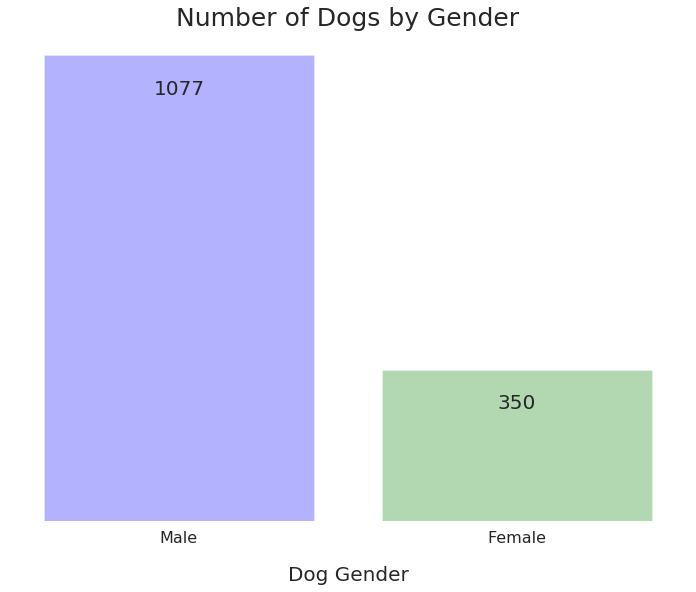

In [216]:
# set plot size
fig,ax = plt.subplots(1,1,figsize=(12,9));

# Remove the plot frame lines. They are unnecessary here.
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# set plot title,labels..etc
plt.title('Number of Dogs by Gender',fontsize=25);
plt.xlabel('Dog Gender',fontsize=20,labelpad=20);
plt.xticks(fontsize=16);
plt.yticks(visible=False);

# plot
bar1 = plt.bar(x=list(gender_counts.index), height=gender_counts.values,alpha=0.3,
                  color=['blue','green']);

# add text to plot
for rect in bar1:
    h = rect.get_height()
    loc = rect.get_x()+rect.get_width()/2.0
    plt.text(loc, h-100, '%d' % int(h), fontdict={'fontsize':20},
             ha='center', va='bottom');

    Observation:
    1. There are more 'Male' dogs than 'Female' dogs in our dataset.

### DOG STAGE

'Dog Stages' in our dataset represent how dogs are called in `Doggo Lingo`.


>DoggoLingo tends to operate in terms of free indirect discourse; the speaker is a human admiring (or mirin’) a dog, but the vocabulary is implied to be the dog’s own idiom. In keeping with old cultural beliefs about what goes on in the canine brain, the vocabulary of DoggoLingo is upbeat, joyful, and clueless in a relentlessly friendly way. (Inside of a dog it’s too dark to read? No way, Groucho – inside of a dog we see nothing but light.)<br>- [Oxford Dictionary](https://blog.oxforddictionaries.com/2017/08/01/doggolingo/)

In various stages of growth, Dogs are called by different names. Some that are found in our dataset are
- **pupper** - younger dogs
- **puppo** - adolescent dogs
- **doggo** - mature dogs
- **floofer** - dogs with excess fur or old dogs

With this information, lets see the dog stages in our dataset.

In [217]:
df.dog_stage.value_counts()

pupper     234
doggo      75 
puppo      25 
floofer    10 
Name: dog_stage, dtype: int64

In [218]:
stages = df.dog_stage.value_counts()

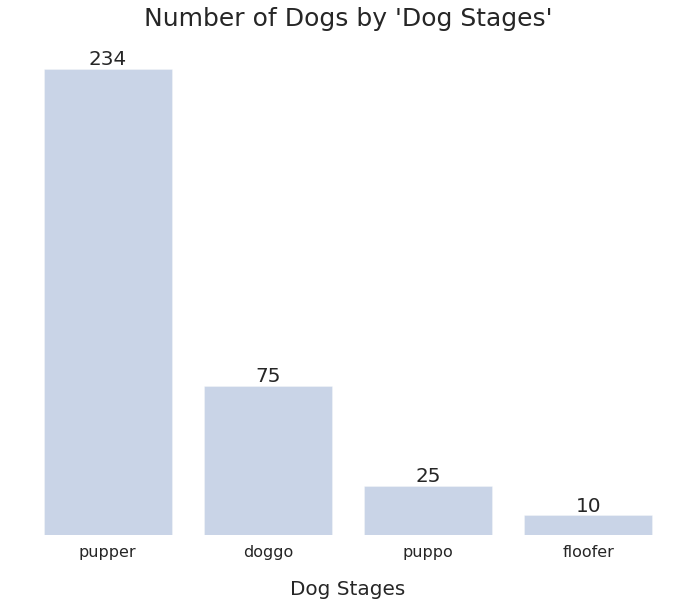

In [219]:
# set plot size
fig,ax = plt.subplots(1,1,figsize=(12,9));

# Remove the plot frame lines. They are unnecessary here.
ax.spines['top'].set_visible(False);
ax.spines['bottom'].set_visible(False);
ax.spines['right'].set_visible(False);
ax.spines['left'].set_visible(False);

# set plot title,labels..etc
plt.title('Number of Dogs by \'Dog Stages\'',fontsize=25,pad=20);
plt.xlabel('Dog Stages',fontsize=20,labelpad=20);
plt.xticks(fontsize=16);
plt.yticks(visible=False);

# plot
bar1 = plt.bar(x=list(stages.index), height=stages.values,alpha=0.3);

# add text to plot
for rect in bar1:
    h = rect.get_height()
    loc = rect.get_x()+rect.get_width()/2.0
    plt.text(loc, h, '%d' % int(h), fontdict={'fontsize':20},
             ha='center', va='bottom');

    Observation:
    1. Although less than 350 rows have dog stages, most of the dogs are `puppers`

### DOG NAME

Dog names are the names given to dogs. Its how they're called.

In [220]:
# get unique values count
df.dog_name.nunique()

1011

In [221]:
# get top 10
df.dog_name.value_counts()[:10]

Lucy       11
Charlie    11
Oliver     11
Cooper     10
Penny      9 
Tucker     9 
Lola       8 
Happy      8 
Sadie      8 
Winston    8 
Name: dog_name, dtype: int64

There are 1011 unique names and the most common or top 10 names are listed above. Remember that during **Data Wrangling**, we cleaned dog name for one dog which had name as 'Happy' but the tweet text did not have dog name. It had some wishes for occasion or celebration like *'Happy Christmas..etc'*.

We see that there are 8 rows with dog name as 'Happy'. Lets checkout.

In [222]:
df[df.dog_name=='Happy']['tweet_text']

220     Happy Saturday here's a dog in a mailbox. 12/10 https://t.co/MM7tb4HpEY                                                   
259     Happy Wednesday here's a pup wearing a beret. 12/10 please enjoy https://t.co/MXedEzSHIf                                  
288     Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ                              
443     Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1                             
1113    Happy Friday. Here's some golden puppers. 12/10 for all https://t.co/wNkqAED6lG                                           
1213    Happy New Year from the squad! 13/10 for all https://t.co/9njRxyUd5L                                                      
1316    This is Happy. He's a bathtub reviewer. Seems to be pleased with this one. 12/10 https://t.co/Ln89R4FP7v                  
2016    Happy New Year from your fav holiday squad! 🎉 12/10 for all\n\nHere's to a 

As doubted, only 1 dog has the name 'Happy'. Other texts do not have dog names. We will correct it by setting the values to None. We will set name for the 1 dog at index 1316 manually

In [223]:
# get index
a_index = df[df.dog_name=='Happy'].index

In [224]:
# set value
df.loc[a_index,'dog_name'] = None
df.loc[1316,'dog_name'] = 'Happy'

#### Test

In [225]:
# get top 10
df.dog_name.value_counts()[:10]

Oliver     11
Lucy       11
Charlie    11
Cooper     10
Tucker     9 
Penny      9 
Lola       8 
Sadie      8 
Winston    8 
Toby       7 
Name: dog_name, dtype: int64

With that being corrected, we will save the dataset.

In [226]:
# save dataset
df.to_csv('twitter_archive_master.csv',index=False,encoding='utf-8')

We will also plot the top 10 names

In [227]:
# get top 10
top_names = df.dog_name.value_counts()[:10]

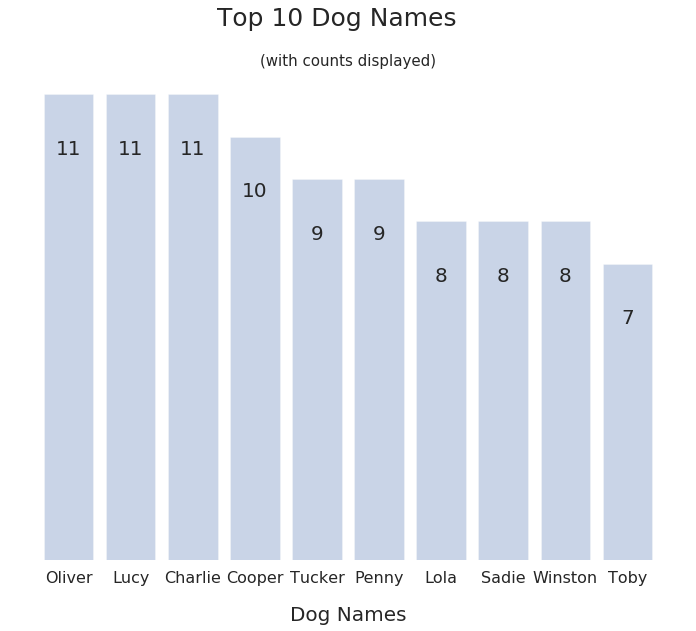

In [228]:
# set plot size
fig,ax = plt.subplots(1,1,figsize=(12,9));

# Remove the plot frame lines. They are unnecessary here.
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# set plot title,labels..etc
plt.suptitle('Top 10 Dog Names', fontsize=25);
plt.title('(with counts displayed)', fontsize=15);
plt.xlabel('Dog Names',fontsize=20,labelpad=20);
plt.xticks(fontsize=16);
plt.yticks(visible=False);

# plot
bar1 = plt.bar(x=list(top_names.index), height=top_names.values,alpha=0.3)

# add text to plot
for rect in bar1:
    h = rect.get_height()
    loc = rect.get_x()+rect.get_width()/2.0
    plt.text(loc, h-1.5, '%d' % int(h), fontdict={'fontsize':20},
             ha='center', va='bottom')

### RETWEETS

#### What is it?

>A Retweet is a re-posting of a Tweet. Twitter's Retweet feature helps you and others quickly share that Tweet with all of your followers. You can Retweet your own Tweets or Tweets from someone else.<br> -[Twitter FAQ](https://help.twitter.com/en/using-twitter/retweet-faqs)

The Retweet count shows how many times the particular Tweet was retweeted by others.

In [229]:
df.retweet_count.describe()

count   2174.000 
mean    2653.149 
std     4699.773 
min     0.000    
25%     574.250  
50%     1269.500 
75%     3038.750 
max     83899.000
Name: retweet_count, dtype: float64

In [230]:
df.retweet_count.quantile(0.99)

20312.87999999999

There seems to be a huge gap between 99% value and Max value. We will use 99% as our limit and analyze the dataset for those values

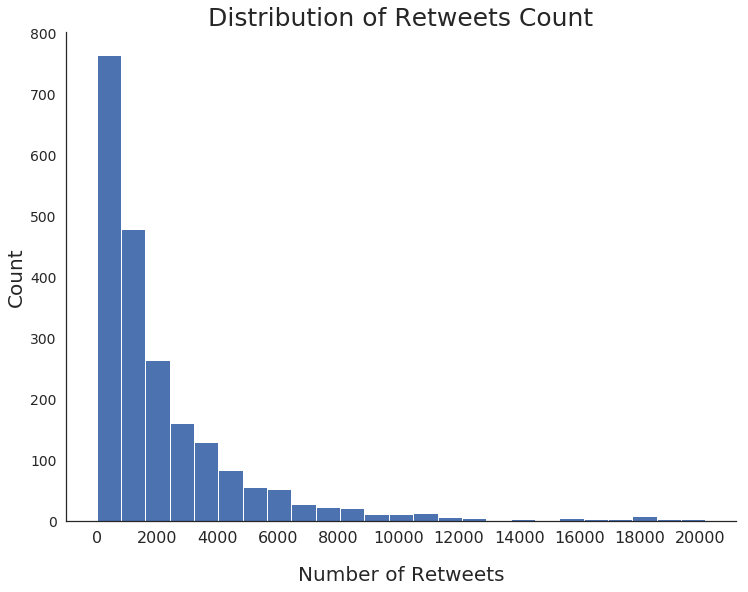

In [231]:
# set plot size
fig,ax = plt.subplots(1,1,figsize=(12,9));

# Remove the plot frame lines. They are unnecessary here.
ax.spines['top'].set_visible(False);
ax.spines['right'].set_visible(False);

# set plot title,labels..etc
plt.title('Distribution of Retweets Count',fontsize=25);
plt.xlabel('Number of Retweets',fontsize=20,labelpad=20);
plt.ylabel('Count',fontsize=20);
plt.xticks(range(0,21000,2000),fontsize=16);
plt.yticks(fontsize=14);

# plot
fig = plt.hist(df.loc[df.retweet_count<=20318,'retweet_count'],bins=25);

The distribution is skewed. Most Tweets are retweeted less than 2000 times(but that is still a huge number!)

### LIKES

>Likes are represented by a small heart and are used to show appreciation for a Tweet or a Moment.<br>-[Twitter FAQ](https://help.twitter.com/en/using-twitter/liking-tweets-and-moments)

Likes count in our dataset shows howmany times the particular Tweet was liked by others

In [232]:
df.likes_count.describe()

count   2174.000  
mean    8601.411  
std     12620.550 
min     51.000    
25%     1829.750  
50%     3882.500  
75%     10694.500 
max     164665.000
Name: likes_count, dtype: float64

In [233]:
df.likes_count.quantile(0.99)

55286.159999999996

Similar to Retweets, even in Likes, there is a huge gap between 99% and Maximum value. We will use 99% data for analysis

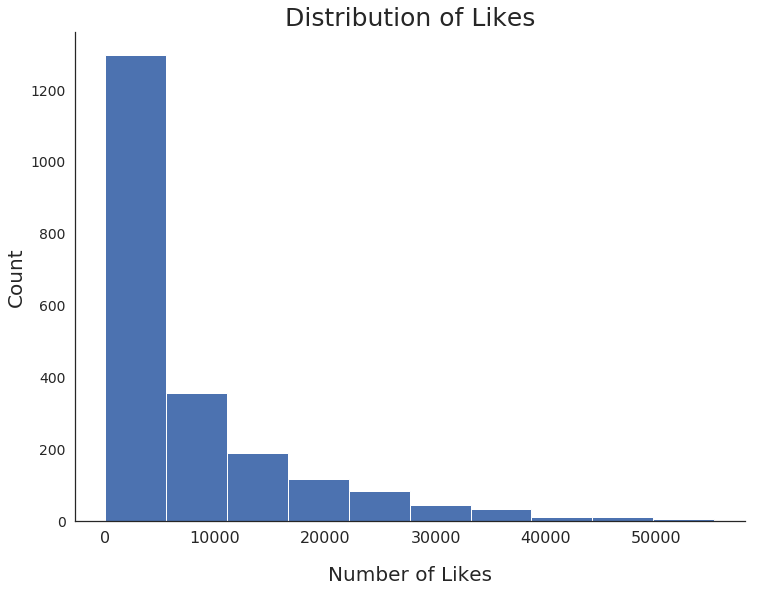

In [234]:
# set plot size
fig,ax = plt.subplots(1,1,figsize=(12,9));

# Remove the plot frame lines. They are unnecessary here.
ax.spines['top'].set_visible(False);
ax.spines['right'].set_visible(False);

# set plot title,labels..etc
plt.title('Distribution of Likes',fontsize=25);
plt.xlabel('Number of Likes',fontsize=20,labelpad=20);
plt.ylabel('Count',fontsize=20);
plt.xticks(fontsize=16);
plt.yticks(fontsize=14);

# plot
fig = plt.hist(df.loc[df.likes_count<=55312,'likes_count']);

The distribution is similar to Retweets. It is skewed right with more values in the lower end of the spectrum.

### DOG BREED

Every Tweet image in the Twitter archive for `WERATEDOGS` was passed through a neural network that can classify breeds of dogs and its outcome is what we have in the consolidated breed prediction and prediction confidence columns

In [235]:
# get top 10
df.dog_breed_prediction.value_counts()[:10]

Golden Retriever      158
Labrador Retriever    108
Pembroke              95 
Chihuahua             91 
Pug                   62 
Toy Poodle            51 
Chow                  48 
Pomeranian            42 
Samoyed               42 
Malamute              33 
Name: dog_breed_prediction, dtype: int64

In [236]:
top_breeds = df.dog_breed_prediction.value_counts()[:10]

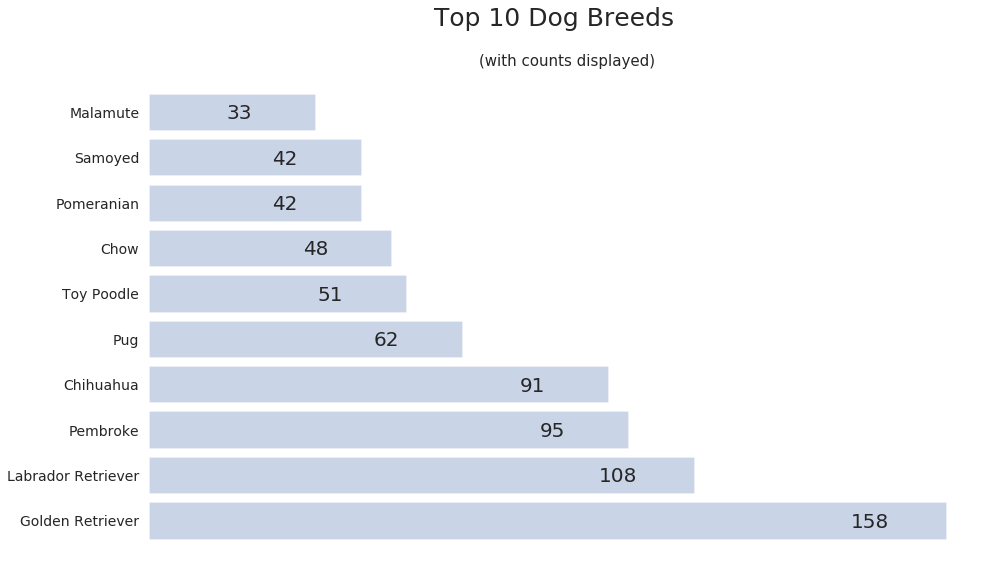

In [237]:
# set plot size
fig,ax = plt.subplots(1,1,figsize=(15,9));

# Remove the plot frame lines. They are unnecessary here.
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# set plot title,labels..etc
plt.suptitle('Top 10 Dog Breeds',fontsize=25);
plt.title('(with counts displayed)',fontsize=15);
plt.xticks(visible=False);
plt.yticks(fontsize=14);

# plot
bar1 = plt.barh(y=list(top_breeds.index), width=top_breeds.values,alpha=0.3)

# add text to plot
for rect in bar1:
    w = rect.get_width()
    loc = rect.get_y()+rect.get_height()/5
    plt.text(w-15, loc, '%d' % int(w), fontdict={'fontsize':20},
             ha='center', va='bottom')

    Observation:
    1. The most common breed of dog found in the dataset is 'Golden Retriever'. Now who's a good doggo?!

### PREDICTION CONFIDENCE

This column shows how confident the algorithm is in its prediction

In [238]:
round(df.loc[df.dog_breed_prediction.notnull(),'prediction_confidence'],2).describe()

count   1686.000
mean    0.550   
std     0.299   
min     0.000   
25%     0.300   
50%     0.550   
75%     0.820   
max     1.000   
Name: prediction_confidence, dtype: float64

In [239]:
round(df.loc[df.dog_breed_prediction.notnull(),'prediction_confidence'],2).value_counts()

0.990    48
1.000    36
0.980    34
0.950    32
0.960    31
0.970    26
0.380    25
0.410    23
0.870    21
0.290    21
0.610    21
0.840    21
0.520    21
0.510    21
0.330    20
0.000    20
0.880    20
0.910    20
0.480    20
0.810    20
0.370    20
0.430    20
0.800    19
0.740    19
0.660    19
0.770    19
0.620    19
0.460    19
0.550    18
0.250    18
         ..
0.500    13
0.050    13
0.140    13
0.240    13
0.100    13
0.390    13
0.630    13
0.570    13
0.680    13
0.170    13
0.310    13
0.060    12
0.450    12
0.850    12
0.160    12
0.040    11
0.690    11
0.010    11
0.560    11
0.080    11
0.150    11
0.120    11
0.190    11
0.020    11
0.070    10
0.490    10
0.640    10
0.210    9 
0.230    8 
0.650    7 
Name: prediction_confidence, Length: 101, dtype: int64

Most predictions(around 48) have confidence as 0.99, followed by 36 predictions with confidence 1

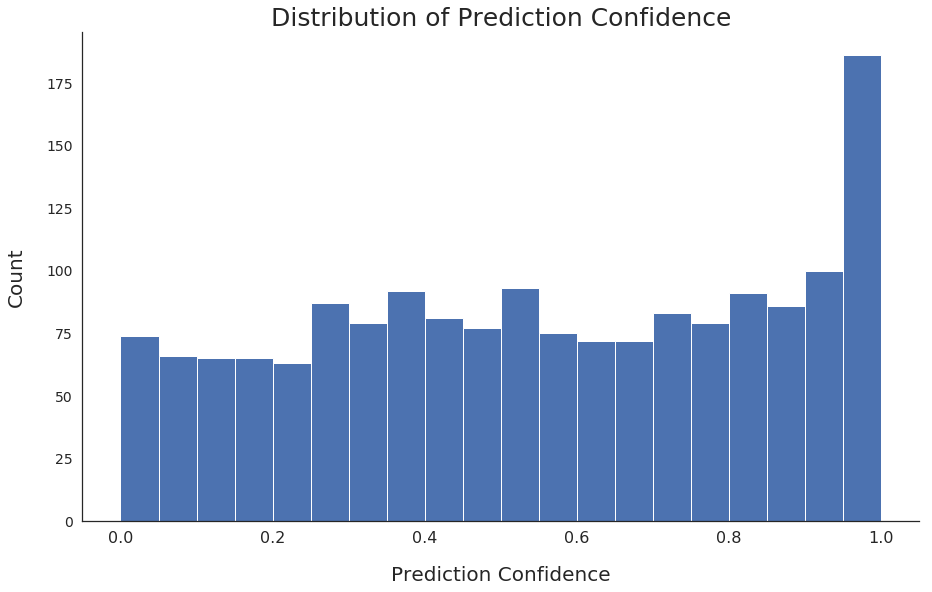

In [240]:
# set plot size
fig,ax = plt.subplots(1,1,figsize=(15,9));

# Remove the plot frame lines. They are unnecessary here.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# set plot title,labels..etc
plt.title('Distribution of Prediction Confidence',fontsize=25);
plt.xlabel('Prediction Confidence',fontsize=20,labelpad=20);
plt.ylabel('Count',fontsize=20,labelpad=20);
plt.xticks(fontsize=16);
plt.yticks(fontsize=14);

# plot
fig = plt.hist(df.loc[df.dog_breed_prediction.notnull(),'prediction_confidence'],
               bins=20);

### HASHTAG

the HashTag column has value if any **#HashTag** was specified in the Tweet text. Only 24 non-null values are available in the dataset which is not a very good number but we will still see how the tweets are tagged.

In [241]:
df.hashtag.value_counts()

BarkWeek                 9
PrideMonth               3
Canada150                1
FinalFur                 1
K9VeteransDay            1
dogsatpollingstations    1
PrideMonthPuppo          1
ScienceMarch             1
WKCDogShow               1
NoDaysOff                1
WomensMarch              1
notallpuppers            1
BellLetsTalk             1
ImWithThor               1
Name: hashtag, dtype: int64

In [242]:
# get counts
hashtags = df.hashtag.value_counts()

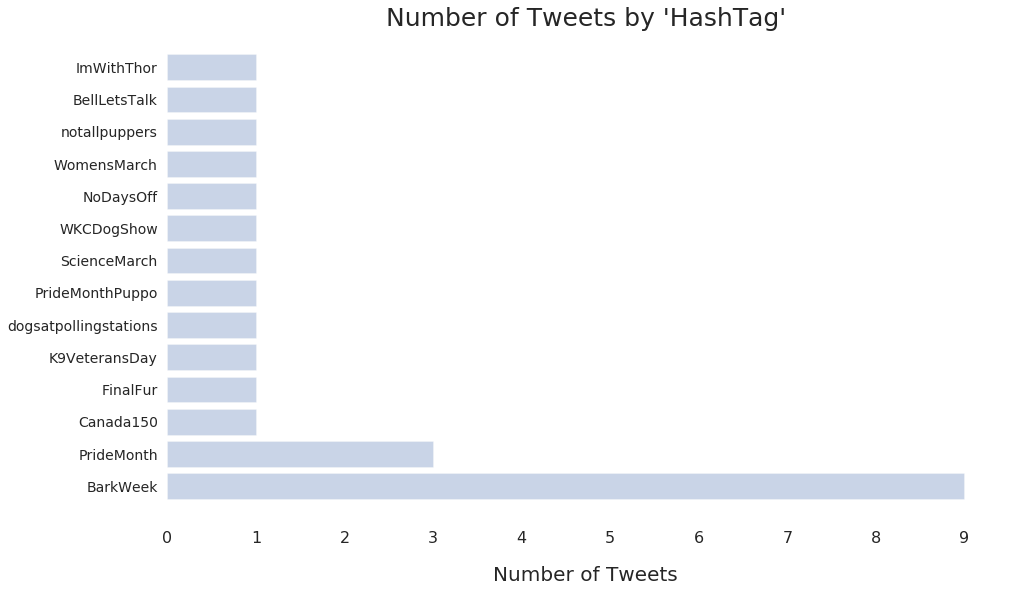

In [243]:
# set plot size
fig,ax = plt.subplots(1,1,figsize=(15,9));

# Remove the plot frame lines. They are unnecessary here.
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# set plot title,labels..etc
plt.title('Number of Tweets by \'HashTag\'',fontsize=25);
plt.xlabel('Number of Tweets',fontsize=20,labelpad=20);
plt.xticks(range(0,10),fontsize=16);
plt.yticks(fontsize=14);

# plot
bar1 = plt.barh(y=list(hashtags.index), width=hashtags.values,alpha=0.3);


Most tweets with **#HashTag** is for **BarkWeek**.

### RATING

It is the rating given to doggo in the Tweet picture! 

Ratings are given in the format *numerator/denominator* with denominator mostly 10 and numerator almost always greater than 10. Why? **They're all good Dogs friend!**


In [244]:
df.rating_numerator.describe()

count   2175.000
mean    12.734  
std     43.156  
min     0.000   
25%     10.000  
50%     11.000  
75%     12.000  
max     1776.000
Name: rating_numerator, dtype: float64

In [245]:
df.rating_numerator.quantile(0.99)

14.0

99% ratings are below 15. the Maximum value however is 1776. We will limit to 99% dataset for analysis.

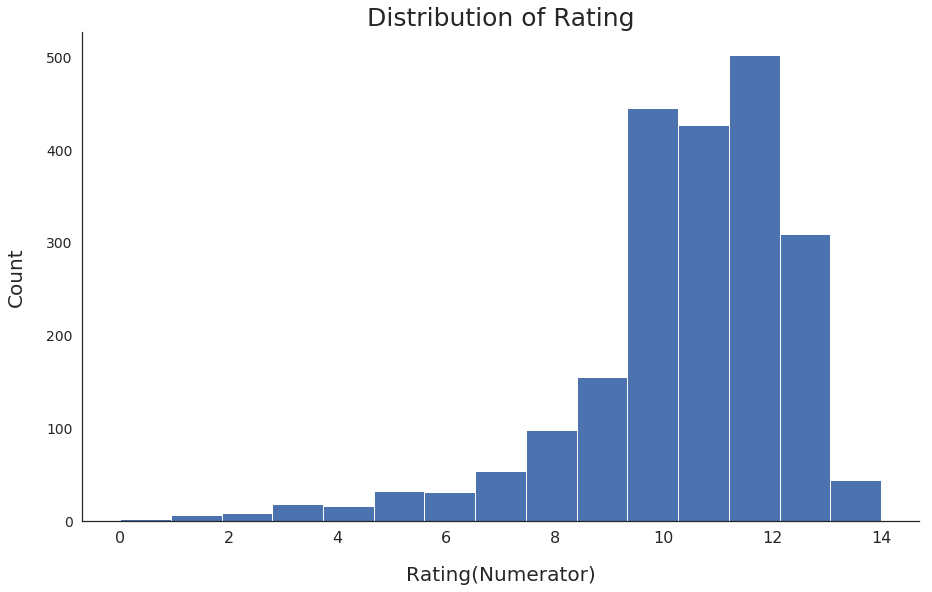

In [246]:
# set plot size
fig,ax = plt.subplots(1,1,figsize=(15,9));

# Remove the plot frame lines. They are unnecessary here.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# set plot title,labels..etc
plt.title('Distribution of Rating',fontsize=25);
plt.ylabel('Count',fontsize=20,labelpad=20);
plt.xlabel('Rating(Numerator)',fontsize=20,labelpad=20);
plt.xticks(fontsize=16);
plt.yticks(fontsize=14);

# plot
fig = plt.hist(df.loc[df.rating_numerator<=14,'rating_numerator'],bins=15);

As expected, the distribuion is left skewed with most values in the upper end of the spectrum with the most common value - *12*

In [247]:
df.rating_denominator.describe()

count   2175.000
mean    10.399  
std     7.014   
min     1.000   
25%     10.000  
50%     10.000  
75%     10.000  
max     170.000 
Name: rating_denominator, dtype: float64

In [248]:
df.rating_denominator.quantile(0.99)

10.0

## BI-VARIATE ANALYSIS

We have seen single variables and their properties. Lets check how they relate to each other

### GENDER AND LIKES

Does gender influence the number of likes a dog gets?

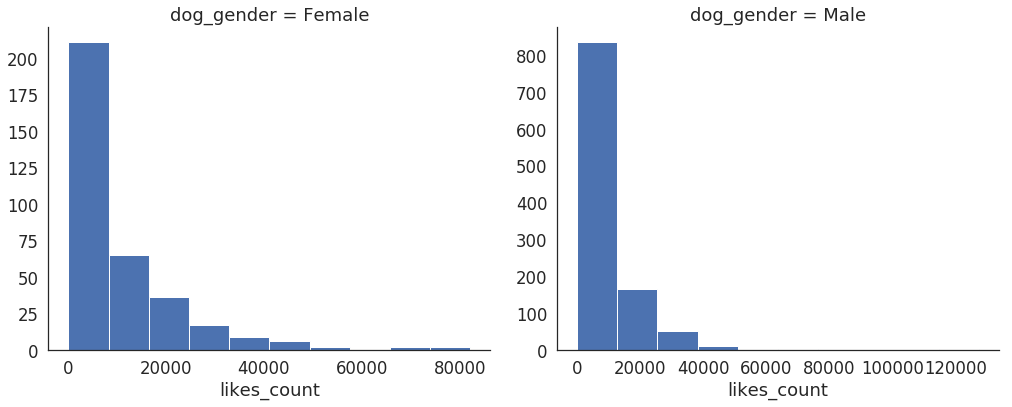

In [249]:
with sns.plotting_context("notebook",font_scale=1.5):
    g = sns.FacetGrid(df,col='dog_gender',sharex=False,sharey=False, 
                      height=6,aspect=1.2);
    
    # plot histogram
    g.map(plt.hist,'likes_count');

We know that there are more 'Male' dogs in the dataset than 'Female' dogs. That is what we see represented in the y-axis. Lets check other descriptors.

In [250]:
df.groupby('dog_gender')['likes_count'].describe()

,count,mean,std,min,25%,50%,75%,max
dog_gender,,,,,,,,
Female,350.000,10587.380,12568.343,105.000,2738.000,5600.000,14398.750,82127.000
Male,1076.000,8753.968,11564.871,111.000,2122.250,4458.500,11495.000,127368.000


Here we can see that 'Female' dogs have better values than 'Male' dogs at 25,50 and 75% intervals. I think we should plot to see it clearly.

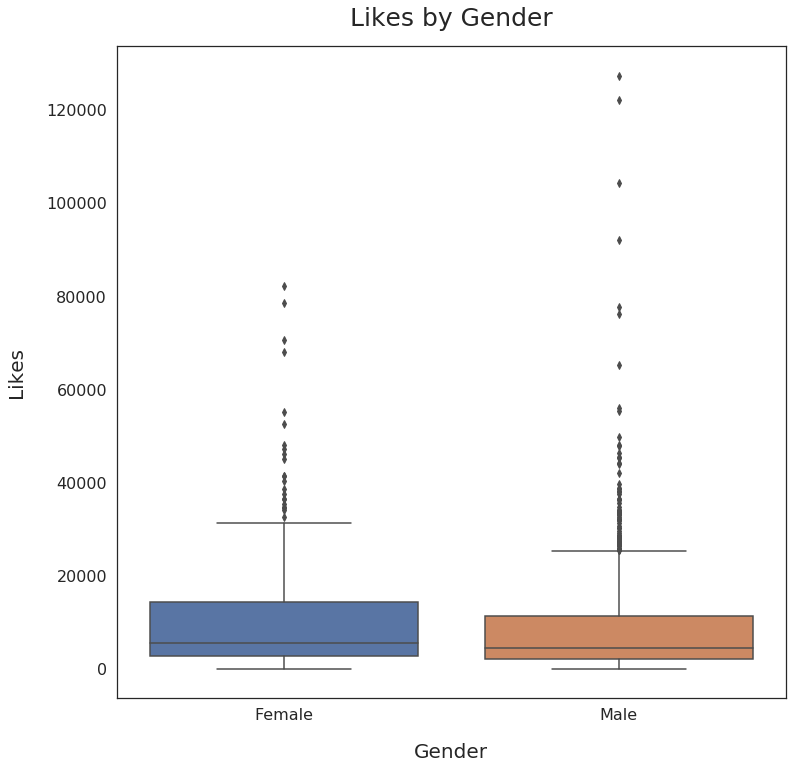

In [251]:
# set plot size
fig,ax = plt.subplots(1,1,figsize=(12,12));

# plot
fig = sns.boxplot(data=df, x='dog_gender', y='likes_count');

# set plot title,labels..etc
fig.set_title('Likes by Gender',fontsize=25,pad=20);
fig.set_ylabel('Likes',fontsize=20,labelpad=20);
fig.set_xlabel('Gender',fontsize=20,labelpad=20);
fig.tick_params(labelsize=16);

There are significant amount of outliers, we will concentrate on IQR values.

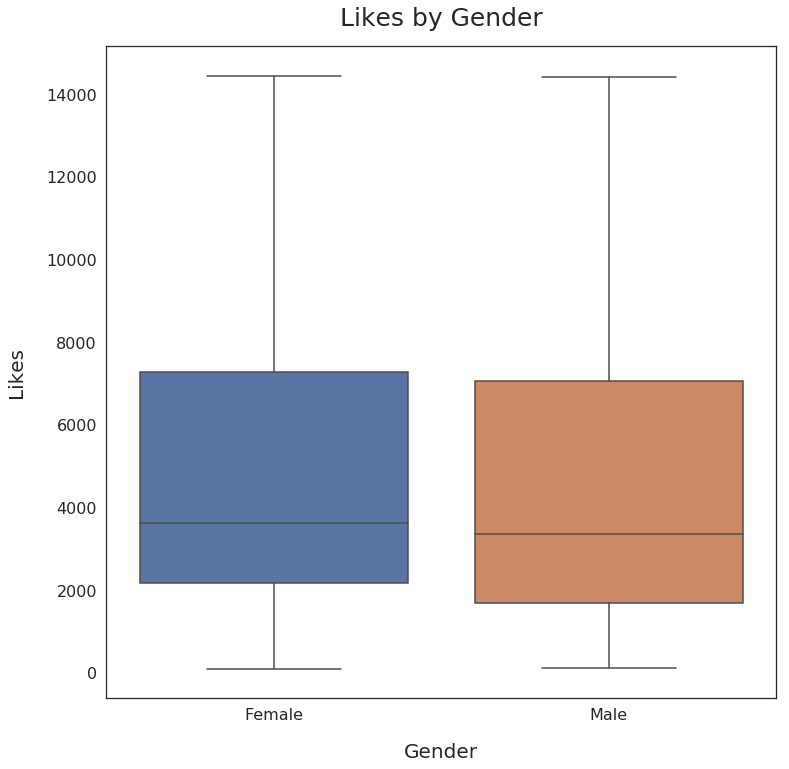

In [252]:
# set plot size
fig,ax = plt.subplots(1,1,figsize=(12,12));

# plot
fig = sns.boxplot(data=df[df.likes_count<=14500],
                  x='dog_gender', y='likes_count');

# set plot title,labels..etc
fig.set_title('Likes by Gender',fontsize=25,pad=20);
fig.set_ylabel('Likes',fontsize=20,labelpad=20);
fig.set_xlabel('Gender',fontsize=20,labelpad=20);
fig.tick_params(labelsize=16);

In [253]:
df.groupby('dog_gender')['likes_count'].quantile(0.99)

dog_gender
Female   61741.650
Male     47945.750
Name: likes_count, dtype: float64

Yes. Although the difference is not much, 'Female' dogs get a slight advantage

### RATING BY GENDER

We will check if dog ratings vary by dog gender

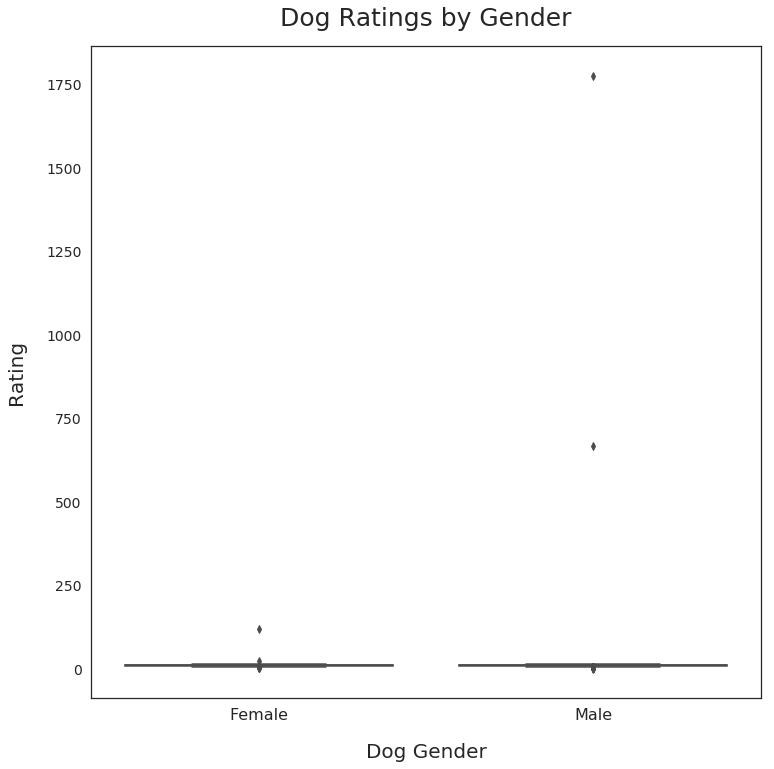

In [254]:
# set plot size
fig,ax = plt.subplots(1,1,figsize=(12,12));

# plot
fig = sns.boxplot(df.dog_gender,df.rating_numerator);

# set plot title,labels..etc
fig.set_title('Dog Ratings by Gender',fontsize=25,pad=20);
fig.set_xlabel('Dog Gender',fontsize=20,labelpad=20);
fig.set_ylabel('Rating',fontsize=20,labelpad=20);
plt.xticks(fontsize=16);
plt.yticks(fontsize=14);

We see that the plot is not clear due to outliers. We'll remove outliers and concentrate on IQR which is what we are interested in

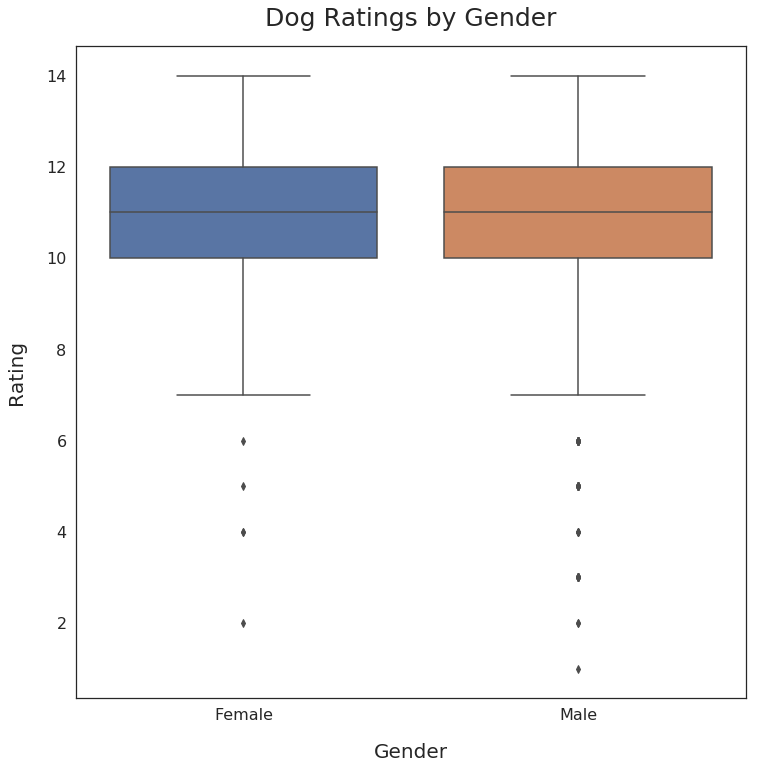

In [255]:
# set plot size
fig,ax = plt.subplots(1,1,figsize=(12,12));

# plot
fig = sns.boxplot(data=df[df.rating_numerator<20],
            x='dog_gender',y='rating_numerator');

# set plot title,labels..etc
fig.set_title('Dog Ratings by Gender',fontsize=25,pad=20);
fig.set_ylabel('Rating',fontsize=20,labelpad=20);
fig.set_xlabel('Gender',fontsize=20,labelpad=20);
fig.tick_params(labelsize=16);

In [256]:
df.groupby('dog_gender')['rating_numerator'].describe()

,count,mean,std,min,25%,50%,75%,max
dog_gender,,,,,,,,
Female,350.000,11.562,6.114,2.000,10.000,11.000,12.000,121.000
Male,1077.000,12.826,57.401,1.000,10.000,11.000,12.000,1776.000


    Observation:
    1. From the boxplot, we find that gender has less influence in rating, since both genders have similar    characteristics.

### RATING BY 'DOG STAGE'

Does 'Stage' influence the ratings given? We all love a cute *pupper*! who doesn't!

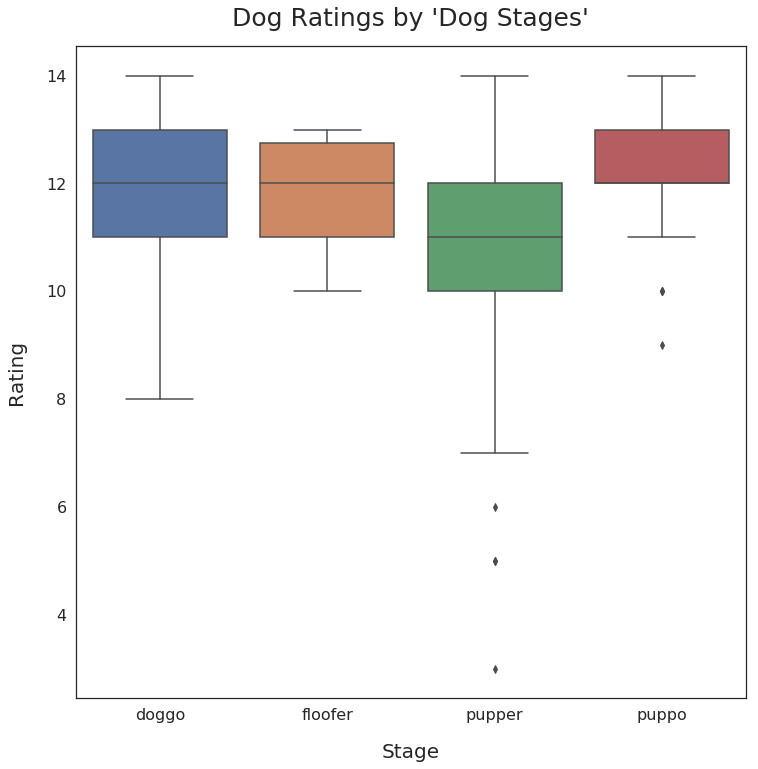

In [257]:
# set plot size
fig,ax = plt.subplots(1,1,figsize=(12,12));

# plot
fig = sns.boxplot(data=df,
                  x='dog_stage',y='rating_numerator');

# set plot title,labels..etc
fig.set_title('Dog Ratings by \'Dog Stages\'',fontsize=25,pad=20);
fig.set_ylabel('Rating',fontsize=20,labelpad=20);
fig.set_xlabel('Stage',fontsize=20,labelpad=20);
fig.tick_params(labelsize=16);

The plot is interesting. We were expecting **puppies** to get better ratings than older dogs. But *doggos* have better ratings than *puppers* in this dataset.

In [258]:
df.groupby('dog_stage')['rating_numerator'].describe()

,count,mean,std,min,25%,50%,75%,max
dog_stage,,,,,,,,
doggo,75.000,11.853,1.430,8.000,11.000,12.000,13.000,14.000
floofer,10.000,11.800,1.033,10.000,11.000,12.000,12.750,13.000
pupper,234.000,10.753,1.733,3.000,10.000,11.000,12.000,14.000
puppo,25.000,12.080,1.256,9.000,12.000,12.000,13.000,14.000


    Observation:
    1. Want better rating. Get a `Doggo`!

### RATING AND LIKES

Good ratings usually mean, the picture is good. There must be relationship between likes and rating. Lets check

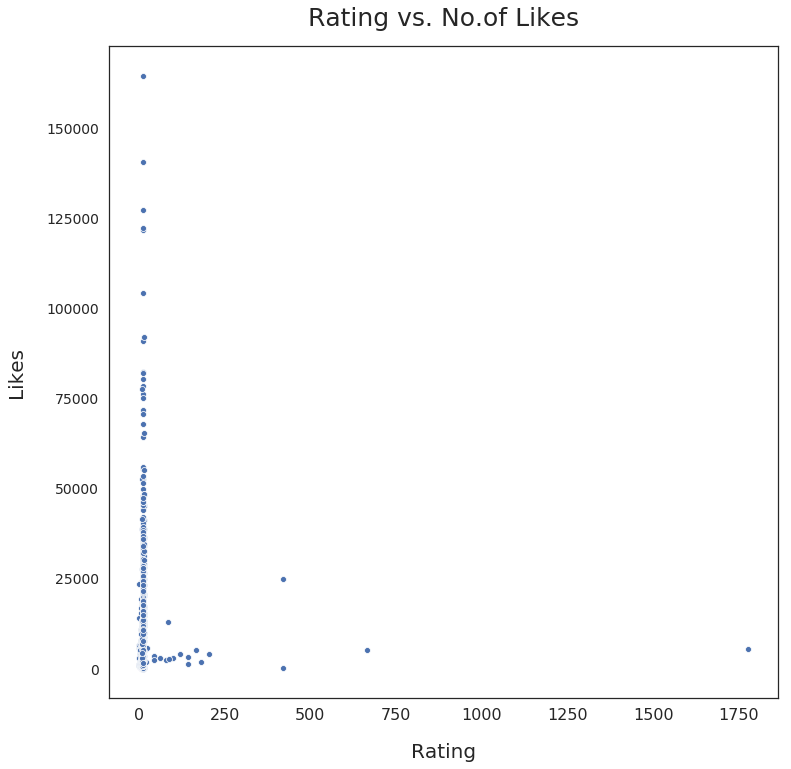

In [259]:
# set plot size
fig,ax = plt.subplots(1,1,figsize=(12,12));

# plot
fig = sns.scatterplot(data=df,
                      x='rating_numerator',y='likes_count');

# set plot title,labels..etc
plt.title('Rating vs. No.of Likes',fontsize=25,pad=20);
plt.ylabel('Likes',fontsize=20,labelpad=20);
plt.xlabel('Rating',fontsize=20,labelpad=20);
plt.xticks(fontsize=16);
plt.yticks(fontsize=14);

Again, the plot is surprising. Looks like the relationship is not that strong! we can even presume there is no relationship here.

Hmm..what if we check for 99% rating instead of all ratings? Lets see

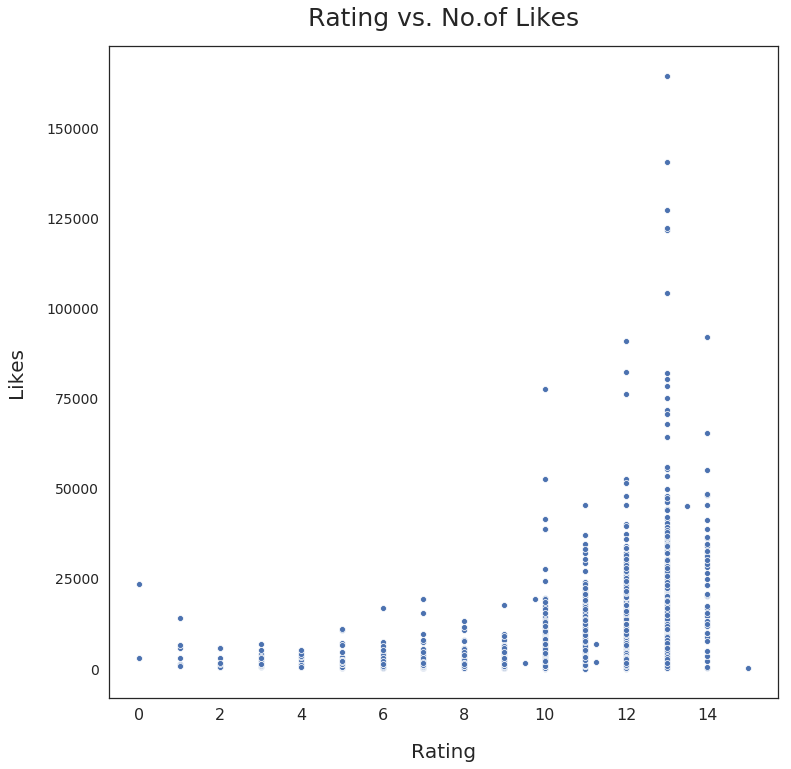

In [260]:
# set plot size
fig,ax = plt.subplots(1,1,figsize=(12,12));

# plot
fig = sns.scatterplot(data=df[df.rating_numerator<20],
                      x='rating_numerator',y='likes_count');

# set plot title,labels..etc
plt.title('Rating vs. No.of Likes',fontsize=25,pad=20);
plt.ylabel('Likes',fontsize=20,labelpad=20);
plt.xlabel('Rating',fontsize=20,labelpad=20);
plt.xticks(fontsize=16);
plt.yticks(fontsize=14);

Ah! now we can see some pattern. Although not strong, there seems to be a relationship between rating and likes. There is a **weak positive correlation** between rating and likes. Lets calculate correlation and find out if this is true.

#### WITH OUTLIERS

In [261]:
rating = df.loc[df.likes_count.notnull(),'rating_numerator']
likes = df.loc[df.likes_count.notnull(),'likes_count']

# calculate pearson's correlation
stat.pearsonr(rating,likes)

(0.009525448745059058, 0.6571222198194941)

When we calculate correlation for dataset with all rating values

    Pearson's r = 0.00953
              p = 0.65681

#### WITHOUT OUTLIERS
What we will do now, is that we will filter the dataset for 99% rating values and check correlation.

In [262]:
rating = df.loc[(df.rating_numerator<20) &
                (df.likes_count.notnull()),
                'rating_numerator']
likes = df.loc[(df.rating_numerator<20) & 
               (df.likes_count.notnull()),
               'likes_count']

# calculate pearson's correlation
stat.pearsonr(rating,likes)

(0.3761047292927029, 2.264167097712275e-73)

In [263]:
format(2.2125073488121478e-73,'0.8f')

'0.00000000'

It is clear now. The result from calculation is

    Pearson's r = 0.37613
              p = 0.00000

The results are statistically significant! There is **weak positive correlation** between rating and likes.

### RATING BY RETWEETS

Do Tweets with good ratings get more Retweets? Lets answer that question!

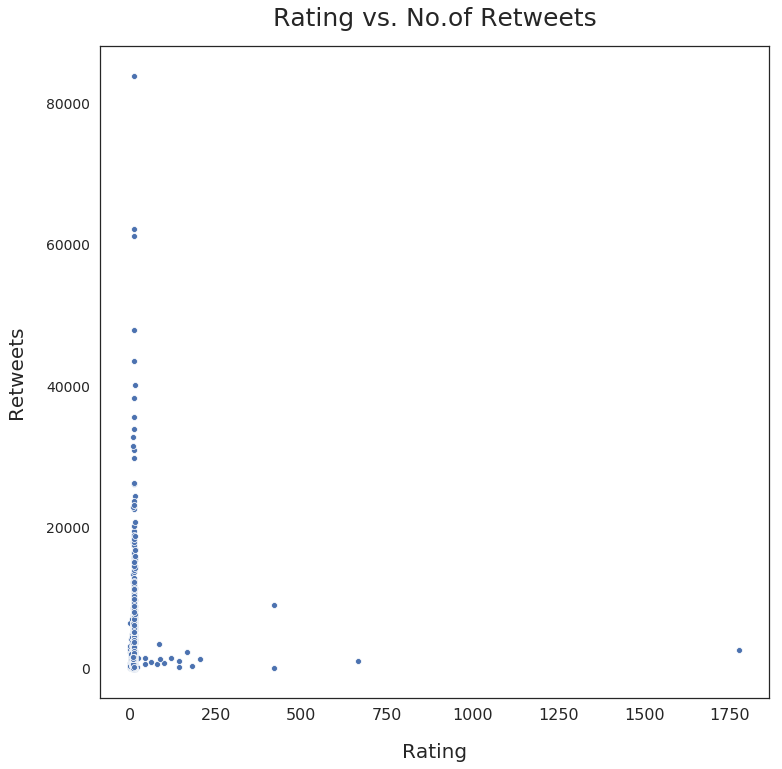

In [264]:
# set plot size
fig,ax = plt.subplots(1,1,figsize=(12,12));

# plot
fig = sns.scatterplot(data=df,
                  x=df.rating_numerator,y=df.retweet_count);

# set plot title,labels..etc
plt.title('Rating vs. No.of Retweets',fontsize=25,pad=20);
plt.ylabel('Retweets',fontsize=20,labelpad=20);
plt.xlabel('Rating',fontsize=20,labelpad=20);
plt.xticks(fontsize=16);
plt.yticks(fontsize=14);

The plot is similar to 'Likes'. We will follow the same procedure.

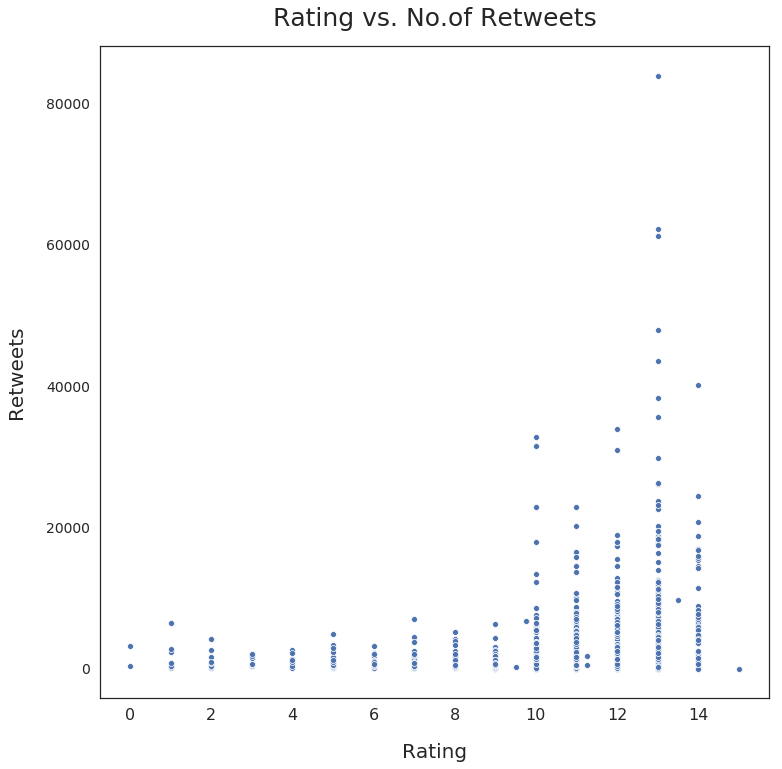

In [265]:
# set plot size
fig,ax = plt.subplots(1,1,figsize=(12,12));

# plot
fig = sns.scatterplot(data=df[df.rating_numerator<20],
                  x='rating_numerator',y='retweet_count');

# set plot title,labels..etc
plt.title('Rating vs. No.of Retweets',fontsize=25,pad=20);
plt.ylabel('Retweets',fontsize=20,labelpad=20);
plt.xlabel('Rating',fontsize=20,labelpad=20);
plt.xticks(fontsize=16);
plt.yticks(fontsize=14);

Hmm, even this plot looks similar to 'Likes' plot. We will also calculate correlation coefficient.

##### WITH OUTLIERS

In [266]:
rating = df.loc[df.retweet_count.notnull(),'rating_numerator']
retweets = df.loc[df.retweet_count.notnull(),'retweet_count']

# calculate pearson's correlation
stat.pearsonr(rating,retweets)

(0.011252036512937057, 0.6000321619237172)

##### WITHOUT OUTLIERS

In [267]:
rating = df.loc[(df.rating_numerator<20) &
                (df.retweet_count.notnull()),
                'rating_numerator']
retweets = df.loc[(df.rating_numerator<20) & 
               (df.retweet_count.notnull()),
               'retweet_count']

# calculate pearson's correlation
stat.pearsonr(rating,retweets)

(0.2883327086898317, 1.565500179360463e-42)

In [268]:
format(1.5571211996591263e-42,'0.8f')

'0.00000000'

Similar to 'Likes', the outcome of correlation without outliers is

    Pearson's r = 0.28834
              p = 0.00000

The result is statistically significant, but the relationship is not as strong as 'Likes'

### LIKES AND RETWEETS

As we have already observed in our plotting, 'Likes' and 'Retweets' have many similarities. There should be **high correlation** between the 2 columns. We need to check and find out.

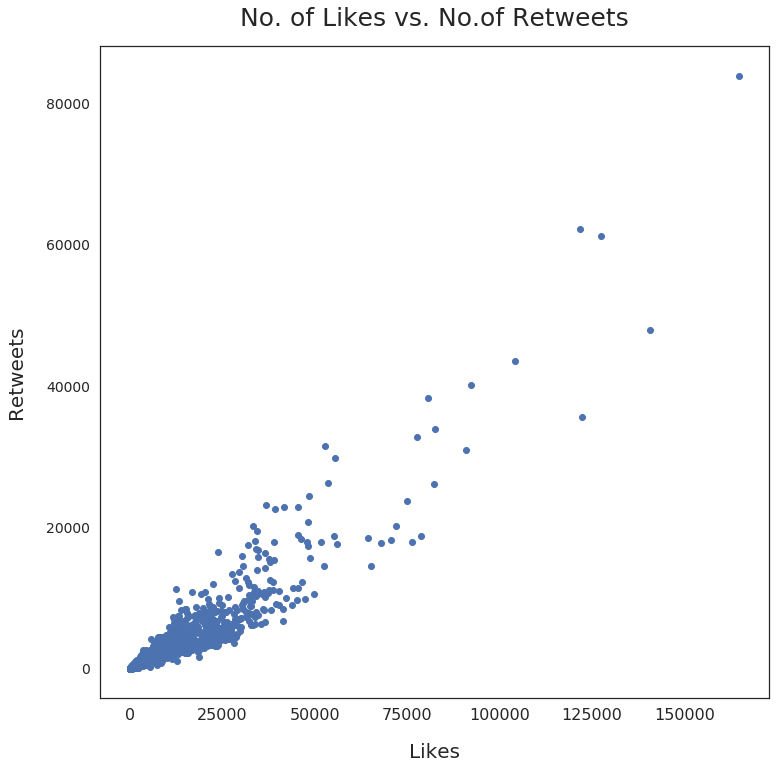

In [269]:
# set plot size
fig,ax = plt.subplots(1,1,figsize=(12,12));

# plot
ax.scatter(x=df.likes_count,y=df.retweet_count);

# set plot title,labels..etc
plt.title('No. of Likes vs. No.of Retweets',fontsize=25,pad=20);
plt.ylabel('Retweets',fontsize=20,labelpad=20);
plt.xlabel('Likes',fontsize=20,labelpad=20);
plt.xticks(fontsize=16);
plt.yticks(fontsize=14);

Yes! we can visually see that with increasing likes, retweets increase. Lets also plot the regression line.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


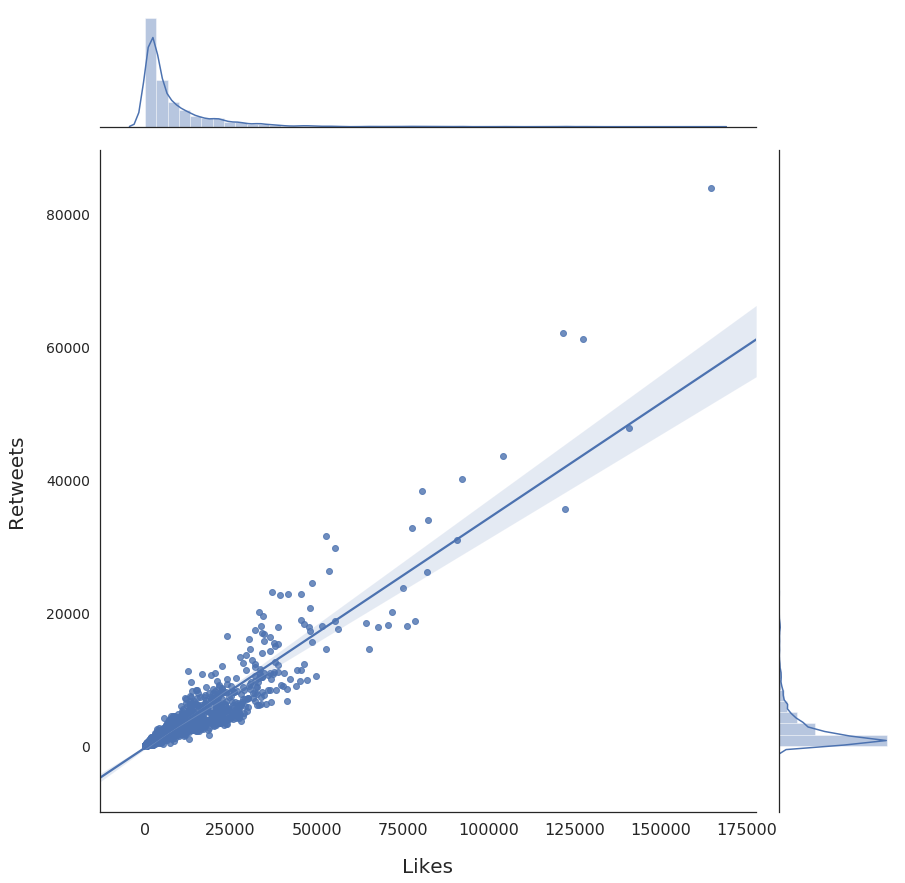

In [270]:
# plot
fig = sns.jointplot(data=df, height=12,
                    x = 'likes_count',
                    y = 'retweet_count',kind='reg');

# set plot title,labels..etc
plt.ylabel('Retweets',fontsize=20,labelpad=20);
plt.xlabel('Likes',fontsize=20,labelpad=20);
plt.xticks(fontsize=16);
plt.yticks(fontsize=14);

Lets also calculate correlation coefficient

In [271]:
likes = df[df.likes_count.notnull()]['likes_count']
retweets = df[df.retweet_count.notnull()]['retweet_count']

# calculate pearson's correlation
stat.pearsonr(likes,retweets)

(0.9276761692213316, 0.0)

    With r~0.93 and p=0.0, the result is statistically significant showing that there is strong relationship between likes and retweets

### RATING AND TWEET DATE

How do ratings vary by month? by year?

In [272]:
df_new = df.loc[df.rating_numerator<20,['tweet_date','rating_numerator']]

#### BY MONTH

In [273]:
df_new.groupby(df_new.tweet_date.dt.month).describe()

rating_numerator                                               
                      count   mean   std   min    25%    50%    75%    max
tweet_date                                                                
1          261.000          10.797 1.963 3.000 10.000 11.000 12.000 14.000
2          195.000          10.800 2.179 0.000 10.000 11.000 12.000 14.000
3          189.000          11.106 1.851 3.000 10.000 12.000 12.000 15.000
4          107.000          11.439 1.632 3.000 11.000 12.000 13.000 14.000
5          104.000          11.712 1.492 6.000 11.000 12.000 13.000 14.000
6          144.000          11.160 1.995 0.000 10.000 12.000 13.000 14.000
7          148.000          11.584 1.661 4.000 11.000 12.000 13.000 14.000
8          65.000           11.077 1.584 4.000 10.000 11.000 12.000 14.000
9          69.000           11.250 1.621 3.000 11.000 11.000 12.000 14.000
10         73.000           11.750 0.932 9.750 11.000 12.000 12.000 14.000
11         357.000          9.429  2.514 1.000 8.000  10.000 11.000 14.000
12         444.000          9.923  2.297 1.000 9.000  10.000 11.445 14.000

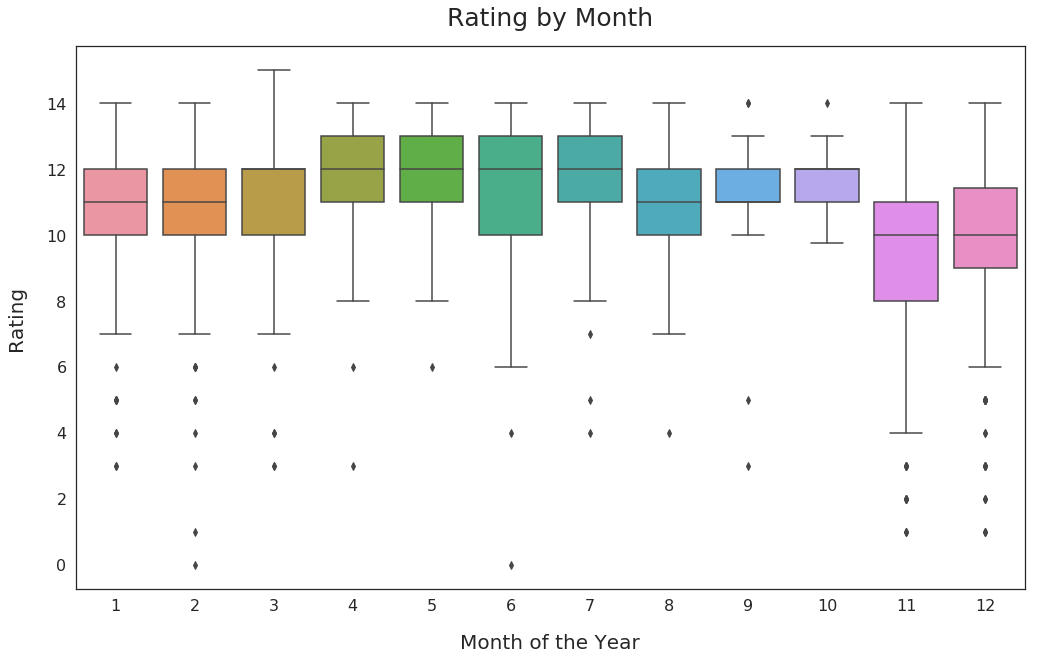

In [274]:
# set plot size
fig,ax = plt.subplots(1,1,figsize=(17,10));

# plot
fig = sns.boxplot(df_new.tweet_date.dt.month,y=df_new.rating_numerator);

# set plot title,labels..etc
plt.title('Rating by Month',fontsize=25,pad=20);
fig.set_ylabel('Rating',fontsize=20,labelpad=20);
fig.set_xlabel('Month of the Year',fontsize=20,labelpad=20);
fig.tick_params(labelsize=16);

The months April, May, June and July seem to have higher ratings on average than other months! doggo's do enjoy a cool summer I guess! :D

#### BY YEAR

In [275]:
df_new.groupby(df_new.tweet_date.dt.year).describe()

rating_numerator                                               
                      count   mean   std   min    25%    50%    75%    max
tweet_date                                                                
2015       685.000          9.321  2.376 1.000 8.000  10.000 11.000 13.000
2016       1076.000         10.798 1.798 0.000 10.000 11.000 12.000 14.000
2017       395.000          12.427 1.148 0.000 12.000 13.000 13.000 15.000

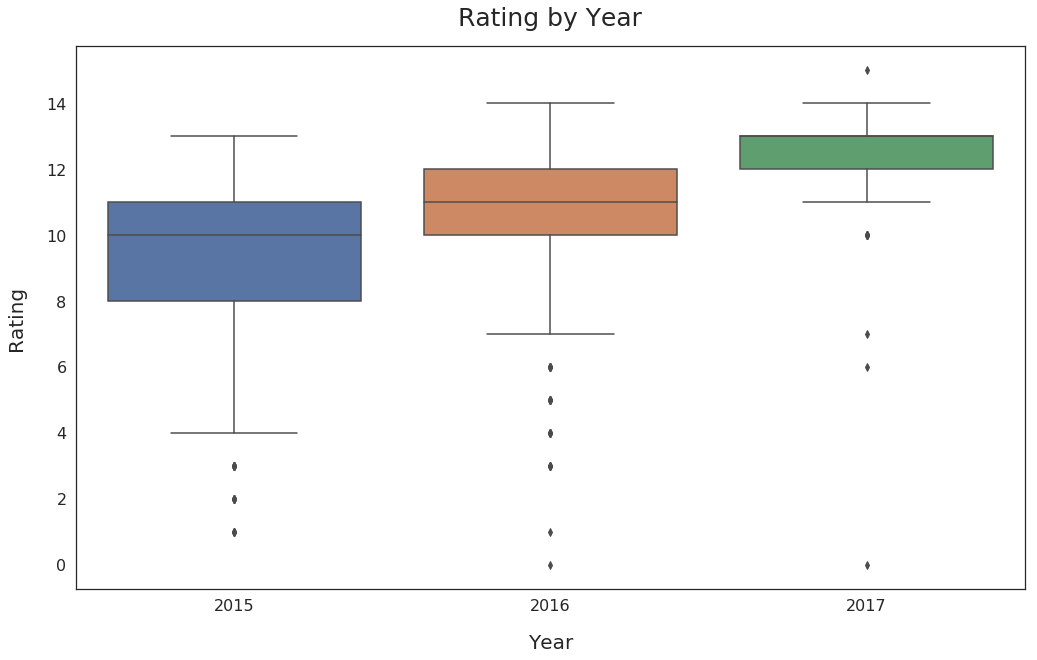

In [276]:
# set plot size
fig,ax = plt.subplots(1,1,figsize=(17,10));

# plot
fig = sns.boxplot(df_new.tweet_date.dt.year,y=df_new.rating_numerator);

# set plot title,labels..etc
plt.title('Rating by Year',fontsize=25,pad=20);
fig.set_ylabel('Rating',fontsize=20,labelpad=20);
fig.set_xlabel('Year',fontsize=20,labelpad=20);
fig.tick_params(labelsize=16);

There is increase in ratings with increase in year. Seriously?! Good work guys, good work!!

### RATING AND BREED

Does a particular dog breed get more ratings on average? 

In [277]:
df.groupby('dog_breed_prediction')['rating_numerator'].describe()

,count,mean,std,min,25%,50%,75%,max
dog_breed_prediction,,,,,,,,
Afghan Hound,3.000,9.667,5.774,3.000,8.000,13.000,13.000,13.000
Airedale,12.000,9.833,2.250,6.000,9.250,10.500,11.250,12.000
American Staffordshire Terrier,16.000,10.312,3.071,0.000,10.000,11.000,12.000,13.000
Appenzeller,2.000,11.000,2.828,9.000,10.000,11.000,12.000,13.000
Australian Terrier,2.000,11.500,2.121,10.000,10.750,11.500,12.250,13.000
Basenji,9.000,10.333,1.118,8.000,10.000,10.000,11.000,12.000
Basset,17.000,10.706,2.201,5.000,10.000,11.000,12.000,13.000
Beagle,20.000,10.150,1.531,6.000,9.750,10.000,11.000,13.000
Bedlington Terrier,6.000,10.333,3.141,6.000,8.250,10.500,12.750,14.000


For our calculation, we will select the Median rating, since it represents a fair estimate than the Mean.

In [278]:
pred_rating = df.groupby('dog_breed_prediction')['rating_numerator'].quantile(0.50)

In [279]:
pred_rating.sort_values(ascending=False,inplace=True)

#### TOP 10

In [280]:
pred_rating[:10]

dog_breed_prediction
Afghan Hound            13.000
Bouvier Des Flandres    13.000
Saluki                  13.000
Rottweiler              12.000
Irish Water Spaniel     12.000
Flat-Coated Retriever   12.000
Pekinese                12.000
Pembroke                12.000
Eskimo Dog              12.000
Norfolk Terrier         12.000
Name: rating_numerator, dtype: float64

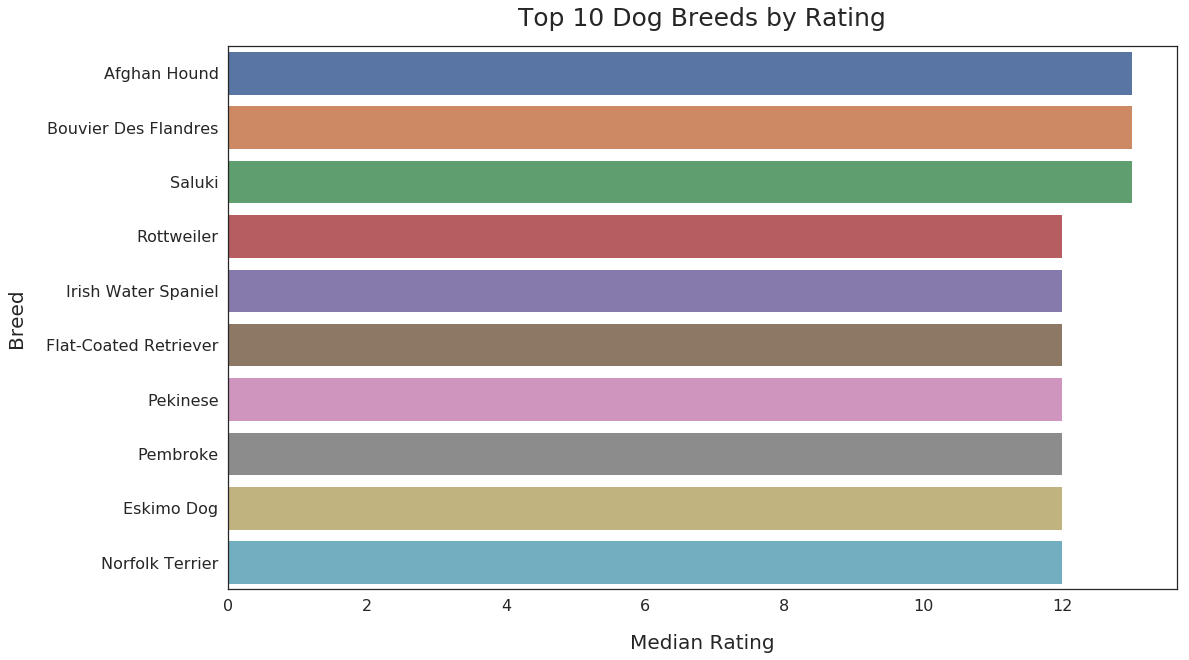

In [281]:
# set plot size
fig,ax = plt.subplots(1,1,figsize=(17,10));

# plot
fig = sns.barplot(x=pred_rating[:10].values,y=pred_rating[:10].index);

# set plot title,labels..etc
fig.set_title('Top 10 Dog Breeds by Rating',fontsize=25,pad=20);
fig.set_ylabel('Breed',fontsize=20,labelpad=20);
fig.set_xlabel('Median Rating',fontsize=20,labelpad=20);
fig.tick_params(labelsize=16);

Are you planning to get a dog? get one of these!

#### BOTTOM 10

In [282]:
pred_rating[-10:]

dog_breed_prediction
Ibizan Hound             10.000
Welsh Springer Spaniel   9.500 
Dalmatian                9.500 
English Setter           9.500 
Scottish Deerhound       9.500 
Yorkshire Terrier        9.500 
Curly-Coated Retriever   9.000 
Scotch Terrier           9.000 
Tibetan Terrier          9.000 
Japanese Spaniel         5.000 
Name: rating_numerator, dtype: float64

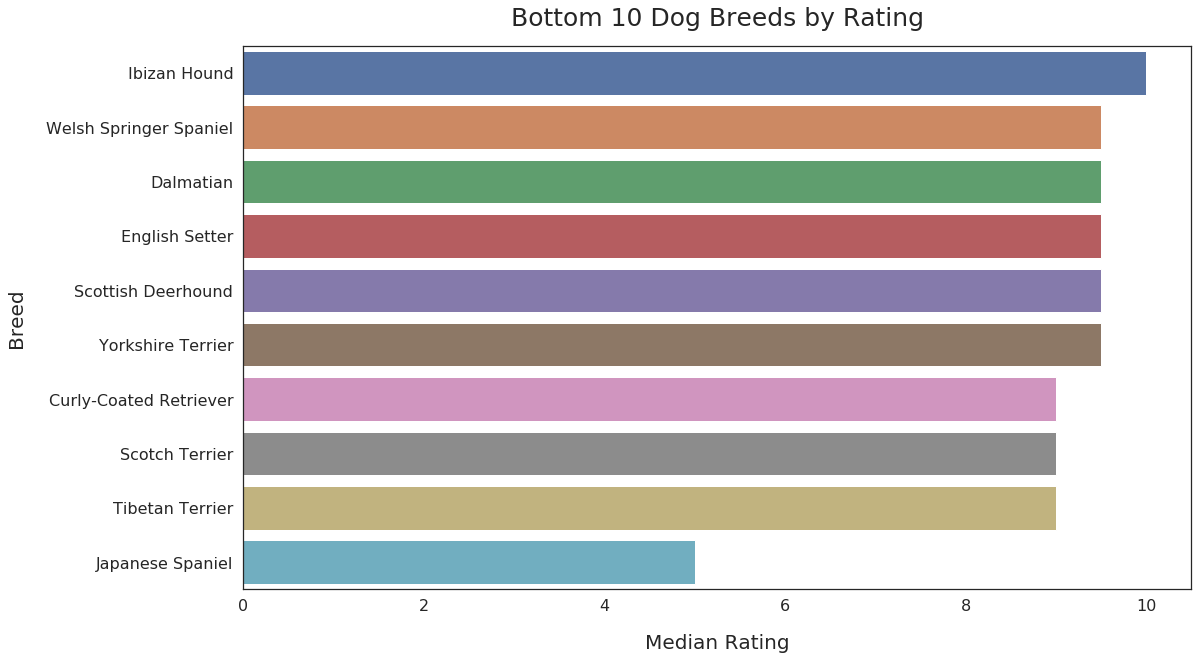

In [283]:
# set plot size
fig,ax = plt.subplots(1,1,figsize=(17,10));

# plot
fig = sns.barplot(x=pred_rating[-10:].values,y=pred_rating[-10:].index);

# set plot title,labels..etc
fig.set_title('Bottom 10 Dog Breeds by Rating',fontsize=25,pad=20);
fig.set_ylabel('Breed',fontsize=20,labelpad=20);
fig.set_xlabel('Median Rating',fontsize=20,labelpad=20);
fig.tick_params(labelsize=16);

These are dogs with low median rating score. I'm surprised to see 3 breeds of 'Terriers' in this list. Maybe they're all *not so* good dogs Brent!...Just kidding!

### BREED AND PREDICTION CONFIDENCE

Is it easy to predict some dog breeds than others? We'll see which dog breeds have high confidence value

In [284]:
df.groupby('dog_breed_prediction')['prediction_confidence'].describe()

,count,mean,std,min,25%,50%,75%,max
dog_breed_prediction,,,,,,,,
Afghan Hound,3.000,0.434,0.414,0.124,0.199,0.275,0.589,0.904
Airedale,12.000,0.584,0.246,0.169,0.447,0.539,0.807,0.945
American Staffordshire Terrier,16.000,0.527,0.327,0.013,0.255,0.546,0.836,0.937
Appenzeller,2.000,0.504,0.229,0.342,0.423,0.504,0.585,0.666
Australian Terrier,2.000,0.308,0.142,0.207,0.257,0.308,0.358,0.408
Basenji,9.000,0.420,0.324,0.055,0.183,0.344,0.749,0.877
Basset,17.000,0.522,0.324,0.000,0.320,0.556,0.814,0.995
Beagle,20.000,0.489,0.321,0.000,0.309,0.433,0.723,0.993
Bedlington Terrier,6.000,0.286,0.141,0.015,0.287,0.311,0.378,0.399


In [285]:
pred_conf = df.groupby('dog_breed_prediction')['prediction_confidence'].mean()

In [286]:
pred_conf.sort_values(ascending=False,inplace=True)

#### TOP 5

In [287]:
pred_conf.head()

dog_breed_prediction
Komondor           0.973
Clumber            0.947
Keeshond           0.844
Bull Mastiff       0.816
Brittany Spaniel   0.776
Name: prediction_confidence, dtype: float64

These are dogs with high prediction confidence values

#### BOTTOM 5

In [288]:
pred_conf.tail()

dog_breed_prediction
Cairn                  0.262
Norwich Terrier        0.247
Scottish Deerhound     0.144
Bouvier Des Flandres   0.083
Irish Wolfhound        0.063
Name: prediction_confidence, dtype: float64

These are dogs with less prediction confidence value. I see 1 'Terrier'...here too!

## MULTI-VARIATE ANALYSIS

We have seen single variable characteristics, we've also seen how 2 variables relate to each other. Now we'll pull in more variables and check out their relationships

### RATING BY GENDER AND DOG STAGE

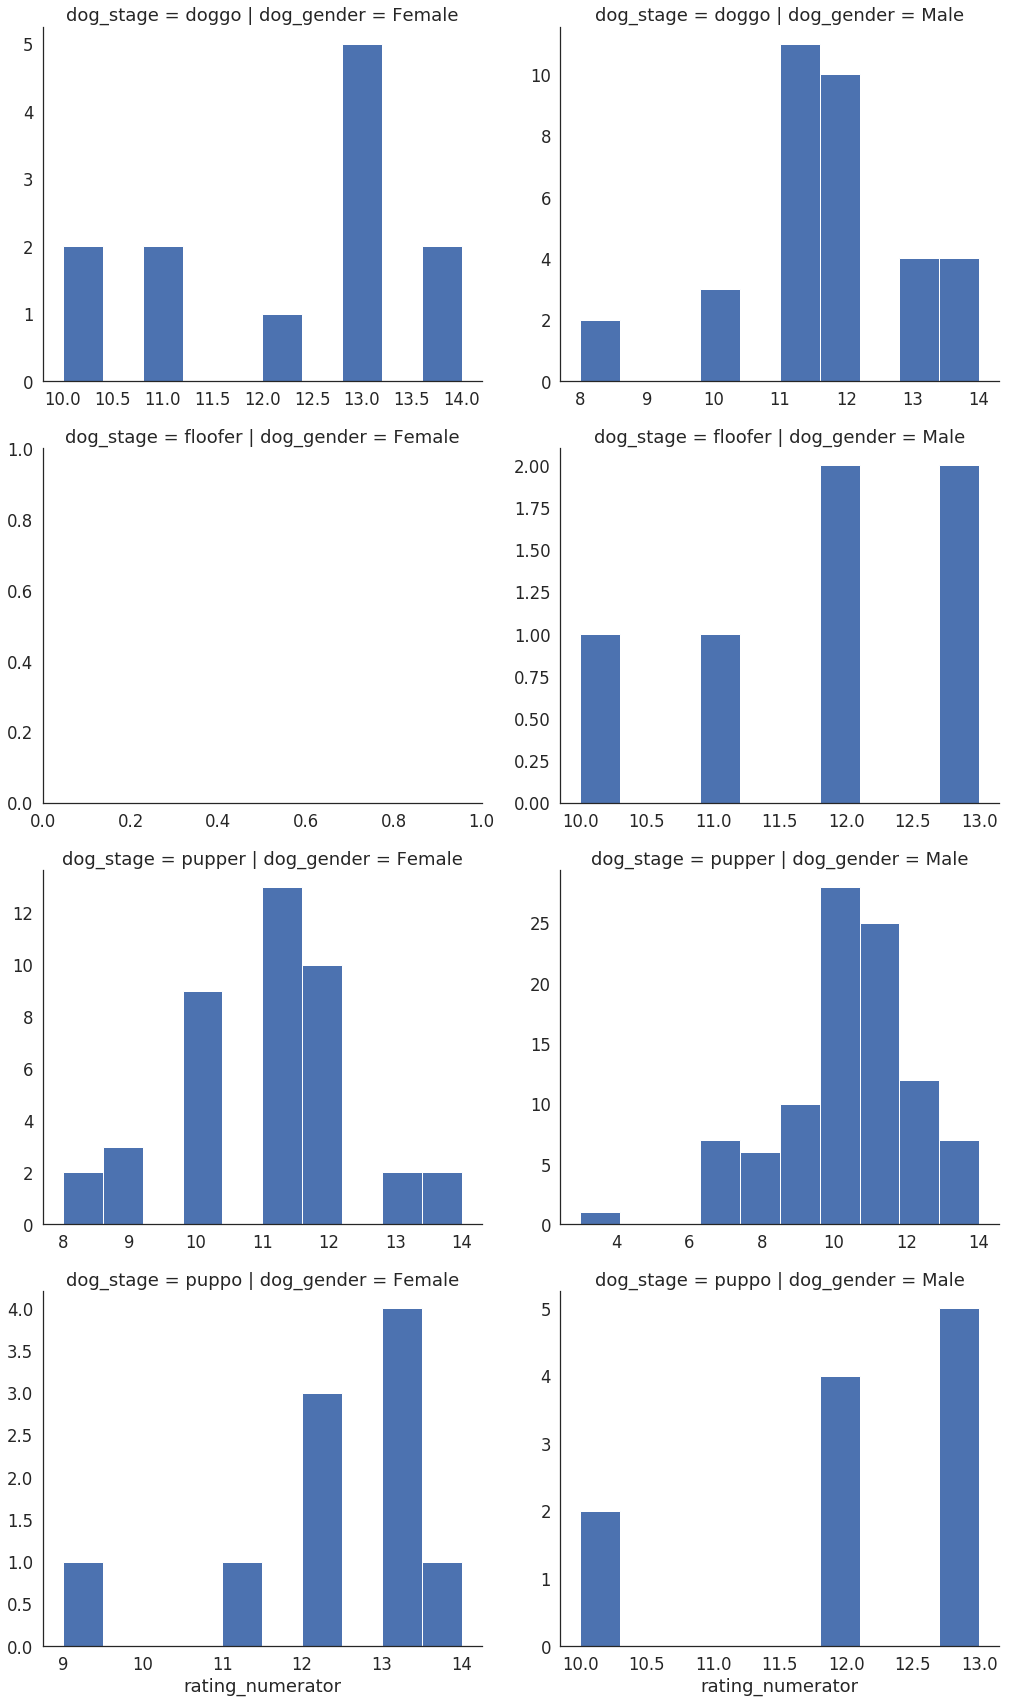

In [289]:
# set font-size for this plot
with sns.plotting_context("notebook",font_scale=1.5):
    g = sns.FacetGrid(df, row="dog_stage", col="dog_gender",
                      height=6, aspect=1.2, 
                      sharex=False, sharey=False);
    
    # plot histogram
    g = g.map(plt.hist, "rating_numerator");


The plot shows a lot of information.
- We can see *puppers* got low ratings. they've been bad bois!
- There are no plots for 'Female' floofers
- 'Female' doggos and puppos have better ratings than their counterparts

In [290]:
df.set_index('tweet_date',inplace=True)

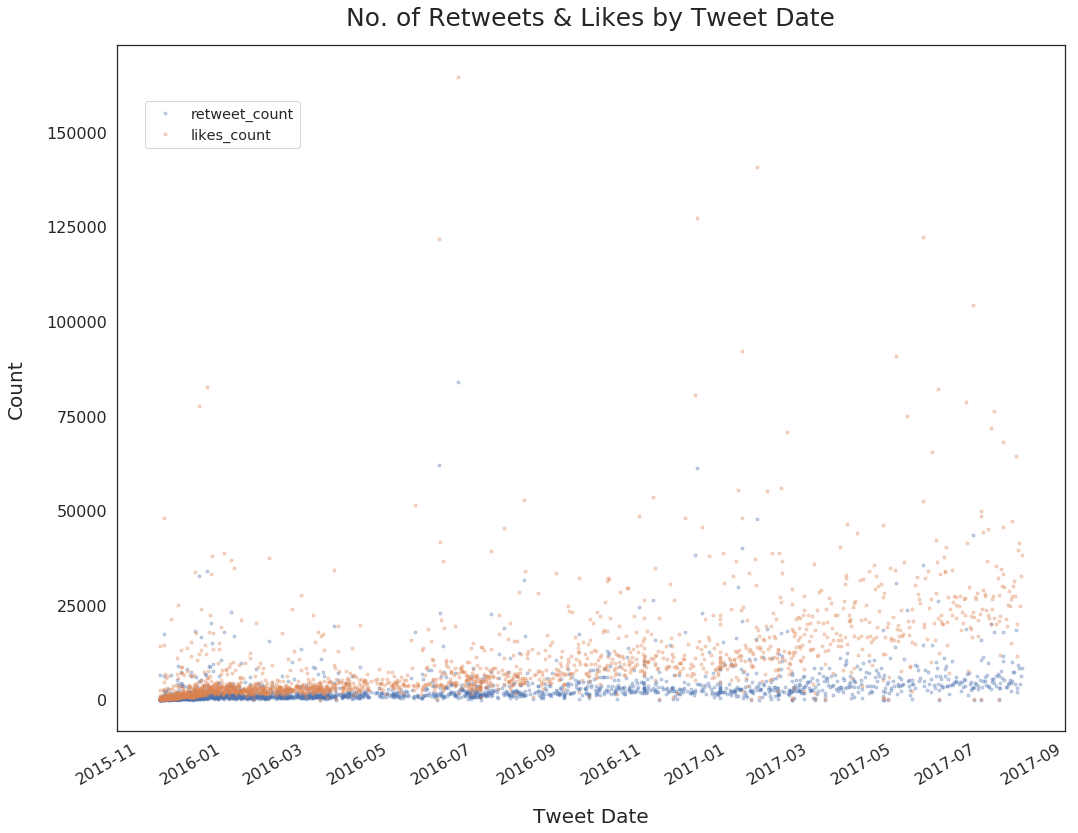

In [291]:
#plot
fig = df[['retweet_count','likes_count']].plot(style='.',alpha=0.3,figsize=(17,14),
                                              fontsize=16);

# set plot title,labels..etc
plt.title('No. of Retweets & Likes by Tweet Date',fontsize=25,pad=20);
plt.xlabel('Tweet Date',fontsize=20,labelpad=20);
plt.ylabel('Count',fontsize=20,labelpad=20);

# get legend handles
patches, labels = fig.get_legend_handles_labels();

# set legend
fig.legend(patches, labels, loc=(0.03,0.85),fontsize='x-large');

The number of likes and retweets are clustered at 2015 but as year progresses, they become more dispersed

## Conclusion

Planning to get a dog? get 'Female' puppos. You can watch them grow. Spend time with them. Take pictures and send it to [@dog_rates](https://twitter.com/dog_rates). You'll have a better chance of getting a better rating.

But really...who cares about rating! Get any dog, cause they're all good dogs friend!

## References

1. https://stackoverflow.com/questions/40489821/how-to-write-text-above-the-bars-on-a-bar-plot-python
2. https://stackoverflow.com/questions/25328003/how-can-i-change-the-font-size-using-seaborn-facetgrid/27714134#27714134
3. https://stackoverflow.com/questions/21151450/how-can-i-add-a-table-of-contents-to-an-ipython-notebook

Thanks to `kmahelona` who has provided code for TOC content creation which I've used in my notebook. Visit his [GITHUB PAGE](https://github.com/kmahelona/ipython_notebook_goodies) for details.

In [2]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>